# Notebook 1: Búsqueda y Recolección del Corpus sobre Cambio Climático

## Construcción de un Grafo de Conocimiento para Adaptación Climática

---

**Serie de Notebooks:** Este es el primero de cinco notebooks que conforman un proyecto completo de construcción de un grafo de conocimiento sobre medidas de adaptación al cambio climático.

| Notebook | Tema |
|----------|------|
| **1 (actual)** | Búsqueda y Recolección del Corpus desde Múltiples Fuentes |
| 2 | Preprocesamiento de Textos y NLP para Documentos Climáticos |
| 3 | Extracción de Entidades y Relaciones con LLM |
| 4 | Definición de la Ontología del Dominio Climático |
| 5 | Construcción del Grafo en Neo4j |

---

## 1. Introducción: El Desafío de Documentar la Adaptación Climática

### 1.1 ¿Por qué un corpus sobre adaptación climática?

El cambio climático representa uno de los mayores desafíos de nuestra era, y la literatura sobre estrategias de adaptación se encuentra dispersa en una multiplicidad de fuentes: artículos científicos revisados por pares, informes gubernamentales, documentos de organizaciones internacionales, bases de datos de proyectos implementados, y literatura gris de diversa índole. Esta fragmentación dificulta enormemente la tarea de cualquier investigador, gestor de políticas públicas o profesional que necesite obtener una visión comprehensiva del estado del conocimiento.

La construcción de un **grafo de conocimiento** nos permite integrar esta información heterogénea en una estructura consultable. Pero antes de construir el grafo, necesitamos el corpus: la colección de documentos de la cual extraeremos el conocimiento. Este notebook aborda precisamente esa primera etapa fundamental.

### 1.2 El paisaje de fuentes de datos climáticos

A diferencia de dominios científicos más acotados donde una sola base de datos (como arXiv para física o PubMed para biomedicina) puede cubrir la mayor parte de la literatura relevante, el campo de adaptación climática requiere consultar múltiples repositorios complementarios. Cada fuente tiene características distintivas que determinan qué tipo de conocimiento aporta al corpus.

Las **fuentes científicas** como arXiv, Semantic Scholar y OpenAlex proporcionan acceso a la investigación académica más reciente. Aquí encontramos los avances metodológicos, los estudios de caso documentados con rigor científico, y las evaluaciones de efectividad de intervenciones. El lenguaje es técnico y la información suele incluir datos cuantitativos sobre resultados.

Las **fuentes institucionales** como los informes del IPCC, los documentos del Banco Mundial o las bases de datos de agencias ambientales (EPA, NOAA, NASA) aportan una perspectiva diferente. Estos documentos suelen sintetizar el conocimiento científico existente, traducirlo a recomendaciones de política, y contextualizarlo dentro de marcos de gobernanza específicos. El lenguaje tiende a ser más accesible, pero la información puede ser menos granular.

Las **fuentes de proyectos y casos** como Climate-ADAPT (la plataforma europea de adaptación) o las bases de datos del Fondo Verde para el Clima documentan intervenciones concretas: qué se hizo, dónde, con qué recursos, y con qué resultados. Esta información práctica es invaluable para entender cómo se implementan las medidas de adaptación en contextos reales.

### 1.3 Objetivos de aprendizaje de este notebook

Al completar este notebook, habrás desarrollado competencias para:

Primero, **diseñar estrategias de búsqueda** que capturen literatura relevante minimizando el ruido. Esto implica entender cómo funcionan las APIs de diferentes repositorios, qué sintaxis de búsqueda soportan, y cómo combinar términos para maximizar la precisión sin sacrificar demasiada cobertura.

Segundo, **implementar código robusto** para la recolección automatizada de datos. Los scripts que desarrollaremos manejan errores de conexión, respetan los límites de uso de las APIs, y estructuran los datos de manera consistente independientemente de su fuente original.

Tercero, **evaluar la calidad del corpus** resultante mediante análisis exploratorios. Antes de proceder a extraer conocimiento, necesitamos entender qué hemos recolectado: su distribución temporal, su cobertura temática, sus posibles sesgos.

Cuarto, **documentar el proceso** de manera que sea reproducible. La ciencia abierta requiere que otros investigadores puedan replicar nuestros pasos y verificar nuestros resultados.

## 2. Configuración del Entorno de Trabajo

### 2.1 Instalación de dependencias

Antes de comenzar la recolección de datos, necesitamos instalar las bibliotecas que utilizaremos. Cada una cumple una función específica en nuestro flujo de trabajo: `arxiv` para acceder al repositorio de preprints, `requests` para realizar llamadas HTTP a las diversas APIs, `pandas` para estructurar y manipular los datos tabulares, y las bibliotecas de visualización para el análisis exploratorio.

In [ ]:
# Instalación de dependencias necesarias
# La opción --quiet reduce la verbosidad de la salida

!pip install arxiv pandas matplotlib seaborn wordcloud python-dateutil tqdm requests beautifulsoup4 lxml --quiet

print("✅ Dependencias instaladas correctamente")
print("\n📦 Bibliotecas instaladas:")
print("   • arxiv: Acceso a la API de arXiv")
print("   • requests: Llamadas HTTP a APIs REST")
print("   • beautifulsoup4: Parsing de HTML/XML")
print("   • pandas: Manipulación de datos tabulares")
print("   • matplotlib/seaborn: Visualización")
print("   • wordcloud: Nubes de palabras")
print("   • tqdm: Barras de progreso")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 7.4 MB/s eta 0:00:00
✅ Dependencias instaladas correctamente

📦 Bibliotecas instaladas:
   • arxiv: Acceso a la API de arXiv
   • requests: Llamadas HTTP a APIs REST
   • beautifulsoup4: Parsing de HTML/XML
   • pandas: Manipulación de datos tabulares
   • matplotlib/seaborn: Visualización
   • wordcloud: Nubes de palabras
   • tqdm: Barras de progreso


### 2.2 Importación de bibliotecas

La organización de las importaciones sigue una convención que facilita la lectura del código: primero las bibliotecas estándar de Python, luego las bibliotecas de terceros, y finalmente cualquier módulo local. Esta estructura hace explícitas las dependencias externas del notebook.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                              IMPORTACIONES
# ═══════════════════════════════════════════════════════════════════════════════

# Bibliotecas estándar de Python
import os
import json
import time
import re
from datetime import datetime, timedelta
from collections import Counter, defaultdict
from typing import List, Dict, Optional, Tuple
import hashlib
import warnings
warnings.filterwarnings('ignore')

# Acceso a APIs y web scraping
import arxiv
import requests
from bs4 import BeautifulSoup

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Utilidades
from tqdm.notebook import tqdm

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuración de pandas para mejor visualización
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 20)

print("✅ Bibliotecas importadas correctamente")
print(f"\n📦 Versiones principales:")
print(f"   • Python: {os.sys.version.split()[0]}")
print(f"   • pandas: {pd.__version__}")
print(f"   • arxiv: {arxiv.__name__} (version not available via __version__)")
print(f"   • requests: {requests.__version__}")

✅ Bibliotecas importadas correctamente

📦 Versiones principales:
   • Python: 3.12.12
   • pandas: 2.2.2
   • arxiv: arxiv (version not available via __version__)
   • requests: 2.32.4


### 2.3 Configuración de directorios y constantes globales

Definimos aquí las constantes que controlan el comportamiento del notebook. Centralizar estos valores al inicio facilita la experimentación: si queremos ajustar el número máximo de resultados por consulta o modificar los términos de búsqueda, sabemos exactamente dónde hacerlo sin necesidad de revisar todo el código.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                         CONFIGURACIÓN GLOBAL
# ═══════════════════════════════════════════════════════════════════════════════

# Directorio para almacenar datos
DATA_DIR = "data/corpus_clima"
os.makedirs(DATA_DIR, exist_ok=True)

# Timestamp para nombrar archivos de esta sesión
SESSION_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# Parámetros de búsqueda
MAX_RESULTS_PER_QUERY = 100      # Máximo de resultados por consulta individual
API_DELAY_SECONDS = 3.0          # Pausa entre llamadas a APIs (respeta límites)
MAX_RETRIES = 3                  # Reintentos en caso de error de conexión

# User-Agent para requests HTTP (buena práctica para identificarse)
USER_AGENT = "ClimateKG-CorpusCollector/1.0 (research purposes; contact: researcher@university.edu)"

# Headers por defecto para requests
DEFAULT_HEADERS = {
    "User-Agent": USER_AGENT,
    "Accept": "application/json"
}

print("✅ Configuración global establecida")
print(f"\n📁 Directorio de datos: {DATA_DIR}")
print(f"🕐 Timestamp de sesión: {SESSION_TIMESTAMP}")
print(f"⚙️  Parámetros:")
print(f"   • Máx. resultados por query: {MAX_RESULTS_PER_QUERY}")
print(f"   • Delay entre llamadas API: {API_DELAY_SECONDS}s")

✅ Configuración global establecida

📁 Directorio de datos: data/corpus_clima
🕐 Timestamp de sesión: 20251230_105338
⚙️  Parámetros:
   • Máx. resultados por query: 100
   • Delay entre llamadas API: 3.0s


## 3. Diseño de la Ontología de Búsqueda

### 3.1 Taxonomía del dominio de adaptación climática

Antes de escribir una sola consulta de búsqueda, necesitamos reflexionar sobre la estructura conceptual del dominio que queremos capturar. Esta reflexión es crucial porque determina qué literatura encontraremos y cuál quedará fuera de nuestro corpus.

El dominio de adaptación climática puede organizarse en varias dimensiones complementarias. La primera dimensión corresponde a los **peligros climáticos**: inundaciones, sequías, olas de calor, incendios forestales, aumento del nivel del mar, tormentas extremas. Cada peligro tiene su propia literatura especializada y su vocabulario técnico característico.

La segunda dimensión corresponde a las **medidas de adaptación**: infraestructura verde, sistemas de alerta temprana, cultivos resistentes, barreras costeras, planificación urbana, seguros climáticos. Estas medidas pueden clasificarse a su vez según sean basadas en ecosistemas, basadas en ingeniería, o basadas en políticas y comportamientos.

La tercera dimensión es **geográfica**: algunas medidas son específicas de contextos costeros, otras de contextos urbanos, otras de contextos agrícolas. La ubicación determina tanto los peligros relevantes como las soluciones viables.

La cuarta dimensión es **sectorial**: agricultura, recursos hídricos, salud pública, infraestructura, biodiversidad. Cada sector tiene sus propios marcos de análisis y sus propias comunidades de práctica.

Nuestros términos de búsqueda deben capturar estas múltiples dimensiones de manera sistemática.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    TAXONOMÍA DE TÉRMINOS DE BÚSQUEDA
# ═══════════════════════════════════════════════════════════════════════════════

CLIMATE_TAXONOMY = {

    # ─────────────────────────────────────────────────────────────────────────
    # PELIGROS CLIMÁTICOS (Climate Hazards)
    # ─────────────────────────────────────────────────────────────────────────
    "hazards_water": [
        "flood", "flooding", "flash flood", "river flood", "river flooding", "coastal flood",
        "storm surge", "sea level rise", "inundation",
        "drought", "water scarcity", "water stress", "aridity", "agricultural drought",
        "extreme precipitation", "heavy rainfall", "cloudburst", "pluvial flooding", "surface flooding", "coastal flooding",

    ],

    "hazards_temperature": [
        "heat wave", "heatwave", "extreme heat", "heat stress",
        "urban heat island", "thermal stress",
        "cold wave", "extreme cold", "frost",
    ],

    "hazards_other": [
        "wildfire", "forest fire", "bushfire",
        "tropical cyclone", "hurricane", "typhoon", "tropical storm",
        "landslide", "mudslide", "debris flow",
        "coastal erosion", "shoreline retreat",
    ],

    # ─────────────────────────────────────────────────────────────────────────
    # MEDIDAS DE ADAPTACIÓN (Adaptation Measures)
    # ─────────────────────────────────────────────────────────────────────────
    "measures_infrastructure": [
        "storm surge barrier", "sea wall", "dike", "levee", "flood wall",
        "drainage system", "retention pond", "detention basin",
        "permeable pavement", "green roof", "blue-green infrastructure",
        "cooling center", "shade structure", "reflective pavement",
        "infrastructure damage", "transport disruption", "energy supply disruption",
        "flood control infrastructure",
    ],

    "measures_ecosystem": [
        "nature-based solution", "ecosystem-based adaptation",
        "mangrove restoration", "wetland restoration", "coral restoration",
        "urban forest", "tree canopy", "green corridor",
        "bioswale", "rain garden", "constructed wetland",
        "agroforestry", "windbreak", "shelterbelt",
        "water shortage", "crop yield loss", "food insecurity", "ecosystem degradation", "biodiversity loss",
    ],

    "measures_agriculture": [
        "drought-resistant crop", "drought tolerant", "heat tolerant variety",
        "rainwater harvesting", "drip irrigation", "water-efficient irrigation",
        "crop diversification", "conservation agriculture",
        "climate-smart agriculture", "sustainable intensification", "heat-tolerant crops",
    ],

    "measures_planning": [
        "early warning system", "flood forecasting", "drought monitoring",
        "climate risk assessment", "vulnerability mapping",
        "managed retreat", "relocation", "buyout program",
        "building code", "zoning regulation", "land use planning",
        "heat action plan", "evacuation plan",
        "vulnerability assessment", "land-use planning",
    ],

    "measures_financial": [
        "climate insurance", "crop insurance", "parametric insurance",
        "climate finance", "adaptation fund", "green bond",
        "loss and damage", "climate compensation",
    ],

    # ─────────────────────────────────────────────────────────────────────────
    # CONCEPTOS TRANSVERSALES (Cross-cutting Concepts)
    # ─────────────────────────────────────────────────────────────────────────
    "concepts_general": [
        "climate adaptation", "climate resilience", "climate vulnerability",
        "adaptive capacity", "maladaptation",
        "climate risk", "climate impact", "climate hazard",
        "transformation", "transformational adaptation",
        "disaster risk reduction", "loss and damage", "resilience building"
    ],

    "concepts_governance": [
        "adaptation policy", "climate governance", "climate justice",
        "community-based adaptation", "participatory planning",
        "indigenous knowledge", "local knowledge",
        "multilevel governance", "policy integration",
        "governance-based adaptation", "institutional capacity", "climate finance", "insurance schemes",
    ],

    # ─────────────────────────────────────────────────────────────────────────
    # CONTEXTOS GEOGRÁFICOS (Geographic Contexts)
    # ─────────────────────────────────────────────────────────────────────────
    "contexts_geographic": [
        "coastal city", "delta region", "low-lying area",
        "small island", "SIDS",  # Small Island Developing States
        "urban area", "megacity",
        "arid region", "semi-arid", "dryland",
        "mountain region", "glacier",
        "informal settlement", "vulnerable community",
        "low income countries", "global south",
    ],
}

# Mostrar resumen de la taxonomía
print("📋 TAXONOMÍA DE BÚSQUEDA PARA ADAPTACIÓN CLIMÁTICA")
print("=" * 70)
total_terms = 0
for category, terms in CLIMATE_TAXONOMY.items():
    print(f"\n🏷️  {category.replace('_', ' ').title()}:")
    print(f"   {len(terms)} términos: {', '.join(terms[:5])}..." if len(terms) > 5 else f"   {len(terms)} términos: {', '.join(terms)}")
    total_terms += len(terms)

print(f"\n{'=' * 70}")
print(f"📊 Total: {len(CLIMATE_TAXONOMY)} categorías, {total_terms} términos")

📋 TAXONOMÍA DE BÚSQUEDA PARA ADAPTACIÓN CLIMÁTICA

🏷️  Hazards Water:
   20 términos: flood, flooding, flash flood, river flood, river flooding...

🏷️  Hazards Temperature:
   9 términos: heat wave, heatwave, extreme heat, heat stress, urban heat island...

🏷️  Hazards Other:
   12 términos: wildfire, forest fire, bushfire, tropical cyclone, hurricane...

🏷️  Measures Infrastructure:
   18 términos: storm surge barrier, sea wall, dike, levee, flood wall...

🏷️  Measures Ecosystem:
   19 términos: nature-based solution, ecosystem-based adaptation, mangrove restoration, wetland restoration, coral restoration...

🏷️  Measures Agriculture:
   11 términos: drought-resistant crop, drought tolerant, heat tolerant variety, rainwater harvesting, drip irrigation...

🏷️  Measures Planning:
   15 términos: early warning system, flood forecasting, drought monitoring, climate risk assessment, vulnerability mapping...

🏷️  Measures Financial:
   8 términos: climate insurance, crop insurance, parametr

## 4. Fuente 1: arXiv (Preprints Científicos)

### 4.1 Introducción a arXiv para ciencias climáticas

arXiv es el repositorio de preprints más importante del mundo, con más de 2 millones de artículos en física, matemáticas, ciencias de la computación y disciplinas relacionadas. Para nuestro dominio de adaptación climática, arXiv es particularmente valioso porque contiene investigación de vanguardia en modelado climático, hidrología, ciencias atmosféricas y estudios urbanos.

La API de arXiv permite búsquedas sofisticadas usando una sintaxis de prefijos que nos da control granular sobre qué campos consultar. El prefijo `ti:` busca en títulos, `abs:` en abstracts, `au:` por autor, y `all:` en todos los campos. Los operadores booleanos `AND`, `OR` y `ANDNOT` permiten combinar términos de manera lógica.

Una consideración importante es que arXiv tiene categorías temáticas predefinidas. Para ciencias climáticas, las categorías más relevantes incluyen `physics.ao-ph` (física atmosférica y oceánica), `physics.geo-ph` (geofísica), y varias subcategorías de `stat` (estadística) y `cs` (ciencias de la computación) donde se publican trabajos sobre modelado y aprendizaje automático aplicado al clima.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                       CONFIGURACIÓN DE arXiv
# ═══════════════════════════════════════════════════════════════════════════════

# Cliente de arXiv con configuración respetuosa de los límites de la API
arxiv_client = arxiv.Client(
    page_size=100,              # Resultados por página
    delay_seconds=API_DELAY_SECONDS,  # Pausa entre requests
    num_retries=MAX_RETRIES     # Reintentos en caso de error
)

# Categorías de arXiv relevantes para ciencias climáticas
ARXIV_CATEGORIES = [
    "physics.ao-ph",    # Atmospheric and Oceanic Physics
    "physics.geo-ph",   # Geophysics
    "stat.AP",          # Statistics - Applications
    "cs.LG",            # Machine Learning (modelos climáticos)
    "eess.SP",          # Signal Processing (sensores remotos)
]

print("✅ Cliente de arXiv configurado")
print(f"   • Tamaño de página: {arxiv_client.page_size}")
print(f"   • Delay entre requests: {arxiv_client.delay_seconds}s")
print(f"   • Reintentos máximos: {arxiv_client.num_retries}")
print(f"\n📚 Categorías relevantes: {', '.join(ARXIV_CATEGORIES)}")

✅ Cliente de arXiv configurado
   • Tamaño de página: 100
   • Delay entre requests: 3.0s
   • Reintentos máximos: 3

📚 Categorías relevantes: physics.ao-ph, physics.geo-ph, stat.AP, cs.LG, eess.SP


### 4.2 Construcción de queries para arXiv

Nuestra estrategia de búsqueda en arXiv combina términos de nuestra taxonomía para crear consultas específicas. En lugar de una única query masiva que podría ser problemática, generamos múltiples queries más focalizadas y luego combinamos los resultados eliminando duplicados.

Cada query se diseña para capturar un aspecto específico del dominio: medidas de adaptación a inundaciones, estrategias contra sequías, mitigación de islas de calor urbanas, y así sucesivamente. Esta aproximación modular tiene la ventaja adicional de que podemos analizar qué queries producen más resultados, informando futuras refinaciones de nuestra estrategia de búsqueda.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    QUERIES ESPECÍFICAS PARA arXiv
# ═══════════════════════════════════════════════════════════════════════════════

def build_arxiv_queries():
    """
    Genera una lista de queries específicas para buscar en arXiv.
    Cada query combina un peligro climático con medidas de adaptación.

    Returns:
        list: Lista de tuplas (nombre_query, query_string)
    """
    queries = []

    # Query 1: Adaptación a inundaciones
    queries.append((
        "flood_adaptation",
        'abs:"flood" AND (abs:"adaptation" OR abs:"resilience" OR abs:"mitigation")'
    ))

    # Query 2: Sequía y agricultura
    queries.append((
        "drought_agriculture",
        'abs:"drought" AND (abs:"agriculture" OR abs:"crop" OR abs:"irrigation")'
    ))

    # Query 3: Calor urbano
    queries.append((
        "urban_heat",
        'abs:"urban heat island" OR (abs:"heat wave" AND abs:"urban")'
    ))

    # Query 4: Aumento del nivel del mar
    queries.append((
        "sea_level_rise",
        'abs:"sea level rise" AND (abs:"adaptation" OR abs:"coastal" OR abs:"flooding")'
    ))

    # Query 5: Soluciones basadas en naturaleza
    queries.append((
        "nature_based_solutions",
        'abs:"nature-based solution" OR abs:"ecosystem-based adaptation" OR abs:"green infrastructure"'
    ))

    # Query 6: Sistemas de alerta temprana
    queries.append((
        "early_warning",
        'abs:"early warning system" AND (abs:"flood" OR abs:"drought" OR abs:"extreme weather")'
    ))

    # Query 7: Resiliencia climática general
    queries.append((
        "climate_resilience",
        'ti:"climate resilience" OR ti:"climate adaptation" OR ti:"climate vulnerability"'
    ))

    # Query 8: Incendios forestales
    queries.append((
        "wildfire_adaptation",
        'abs:"wildfire" AND (abs:"climate change" OR abs:"adaptation" OR abs:"management")'
    ))

    # Query 9: Ciudades costeras
    queries.append((
        "coastal_cities",
        'abs:"coastal" AND abs:"city" AND (abs:"flood" OR abs:"climate" OR abs:"adaptation")'
    ))

    # Query 10: Infraestructura crítica
    queries.append((
        "critical_infrastructure",
        'abs:"infrastructure" AND abs:"climate" AND (abs:"risk" OR abs:"vulnerability" OR abs:"resilience")'
    ))
    # Query 11: Peligros: ciclones (nueva)
    queries.append((
        "tropical_cyclones",
        'abs:"tropical cyclone" AND abs:"hurricane" OR abs:"typhoon" AND (abs:"adaptation" OR abs:"resilience")'
    ))
    # Query 12: Tormentas (nueva)
    queries.append((
         "storm_surge",
         'abs:"storm surge" AND (abs:"coastal" OR abs:"flood" OR abs:"adaptation")'
    ))
    # Query 13: medidas sequías (nueva)
    queries.append((
        "drought_resistant_crops",
        'abs:"drought resistant" OR (abs:"drought tolerant" AND abs:"crop")'
  ))
     # Query 14: contextos vulnerables (nueva)
    queries.append((
        "sids_adaptation",
        'abs:"small island" OR (abs:"SIDS" AND abs:"climate adaptation")'
  ))

    return queries


# Generar queries
arxiv_queries = build_arxiv_queries()

print("📋 Queries diseñadas para arXiv:")
print("=" * 70)
for name, query in arxiv_queries:
    print(f"\n🔹 {name}:")
    # Mostrar query truncada si es muy larga
    display_query = query if len(query) <= 80 else query[:77] + "..."
    print(f"   {display_query}")

📋 Queries diseñadas para arXiv:

🔹 flood_adaptation:
   abs:"flood" AND (abs:"adaptation" OR abs:"resilience" OR abs:"mitigation")

🔹 drought_agriculture:
   abs:"drought" AND (abs:"agriculture" OR abs:"crop" OR abs:"irrigation")

🔹 urban_heat:
   abs:"urban heat island" OR (abs:"heat wave" AND abs:"urban")

🔹 sea_level_rise:
   abs:"sea level rise" AND (abs:"adaptation" OR abs:"coastal" OR abs:"flooding")

🔹 nature_based_solutions:
   abs:"nature-based solution" OR abs:"ecosystem-based adaptation" OR abs:"green...

🔹 early_warning:
   abs:"early warning system" AND (abs:"flood" OR abs:"drought" OR abs:"extreme ...

🔹 climate_resilience:
   ti:"climate resilience" OR ti:"climate adaptation" OR ti:"climate vulnerability"

🔹 wildfire_adaptation:
   abs:"wildfire" AND (abs:"climate change" OR abs:"adaptation" OR abs:"manageme...

🔹 coastal_cities:
   abs:"coastal" AND abs:"city" AND (abs:"flood" OR abs:"climate" OR abs:"adapta...

🔹 critical_infrastructure:
   abs:"infrastructure" AND abs

### 4.3 Funciones de búsqueda y extracción de metadatos

La función `extract_arxiv_paper` transforma cada resultado de la API en un diccionario estructurado con los campos que necesitamos para el análisis posterior. Estandarizamos los nombres de campos y formatos de fecha para garantizar consistencia con los datos de otras fuentes que incorporaremos más adelante.

La función `search_arxiv_query` maneja la comunicación con la API, incluyendo el manejo de errores y la barra de progreso. El patrón try-except nos permite capturar errores de conexión sin que el notebook se detenga, registrando cuántos resultados pudimos obtener antes del error.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#              FUNCIONES DE BÚSQUEDA EN arXiv
# ═══════════════════════════════════════════════════════════════════════════════

def extract_arxiv_paper(result) -> Dict:
    """
    Extrae metadatos relevantes de un resultado de arXiv.

    Args:
        result: Objeto arxiv.Result de la API

    Returns:
        dict: Diccionario con metadatos estructurados
    """
    return {
        # Identificadores
        'source': 'arxiv',
        'source_id': result.entry_id.split('/')[-1],
        'doi': result.doi,
        'url': result.entry_id,

        # Contenido textual
        'title': result.title.replace('\n', ' ').strip(),
        'abstract': result.summary.replace('\n', ' ').strip(),

        # Autores
        'authors': [author.name for author in result.authors],
        'authors_str': ', '.join([author.name for author in result.authors[:10]]),
        'num_authors': len(result.authors),

        # Fechas
        'published_date': result.published.isoformat() if result.published else None,
        'updated_date': result.updated.isoformat() if result.updated else None,
        'year': result.published.year if result.published else None,

        # Categorización
        'primary_category': result.primary_category,
        'categories': result.categories,

        # Enlaces
        'pdf_url': result.pdf_url,

        # Metadatos adicionales
        'journal_ref': result.journal_ref,
        'comment': result.comment,
    }


def search_arxiv_query(query: str, max_results: int = MAX_RESULTS_PER_QUERY) -> List[Dict]:
    """
    Ejecuta una búsqueda en arXiv y retorna los resultados.

    Args:
        query: String de búsqueda en formato arXiv
        max_results: Número máximo de resultados

    Returns:
        list: Lista de diccionarios con datos de artículos
    """
    search = arxiv.Search(
        query=query,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance,
        sort_order=arxiv.SortOrder.Descending
    )

    results = []

    try:
        for result in tqdm(arxiv_client.results(search),
                          total=max_results,
                          desc="Descargando",
                          leave=False):
            paper_data = extract_arxiv_paper(result)
            results.append(paper_data)
    except Exception as e:
        print(f"\n⚠️ Error durante búsqueda: {e}")
        print(f"   Se obtuvieron {len(results)} resultados antes del error.")

    return results


print("✅ Funciones de búsqueda de arXiv definidas")

✅ Funciones de búsqueda de arXiv definidas


### 4.4 Ejecución de búsquedas en arXiv

Ejecutamos ahora todas las queries diseñadas, combinando los resultados y eliminando duplicados basándonos en el identificador único de cada artículo. El proceso puede tomar varios minutos dependiendo del número de queries y resultados; las barras de progreso nos mantienen informados del avance.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    EJECUCIÓN DE BÚSQUEDAS EN arXiv
# ═══════════════════════════════════════════════════════════════════════════════

def execute_arxiv_searches(queries: List[Tuple[str, str]],
                           max_per_query: int = MAX_RESULTS_PER_QUERY) -> Tuple[List[Dict], Dict]:
    """
    Ejecuta múltiples búsquedas en arXiv y combina resultados únicos.

    Args:
        queries: Lista de tuplas (nombre, query_string)
        max_per_query: Máximo de resultados por query

    Returns:
        tuple: (lista de papers únicos, diccionario de estadísticas)
    """
    all_papers = {}  # Diccionario para detectar duplicados por ID
    stats = {}

    print("🚀 Iniciando búsqueda en arXiv...")
    print(f"   {len(queries)} queries × {max_per_query} resultados máx. cada una")
    print("=" * 70)

    for name, query in queries:
        print(f"\n🔍 Ejecutando: {name}")

        results = search_arxiv_query(query, max_results=max_per_query)

        # Contar nuevos vs duplicados
        new_count = 0
        for paper in results:
            paper_id = paper['source_id']
            if paper_id not in all_papers:
                all_papers[paper_id] = paper
                new_count += 1

        stats[name] = {
            'total': len(results),
            'new': new_count,
            'duplicates': len(results) - new_count
        }

        print(f"   📊 Encontrados: {len(results)} | Nuevos: {new_count} | Duplicados: {len(results) - new_count}")

        # Pausa entre queries
        time.sleep(1)

    print("\n" + "=" * 70)
    print(f"✅ BÚSQUEDA EN arXiv COMPLETADA")
    print(f"   📚 Total de artículos únicos: {len(all_papers)}")

    return list(all_papers.values()), stats


# Ejecutar búsquedas
arxiv_papers, arxiv_stats = execute_arxiv_searches(arxiv_queries)

🚀 Iniciando búsqueda en arXiv...
   14 queries × 100 resultados máx. cada una

🔍 Ejecutando: flood_adaptation


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 100 | Nuevos: 100 | Duplicados: 0

🔍 Ejecutando: drought_agriculture


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 88 | Nuevos: 88 | Duplicados: 0

🔍 Ejecutando: urban_heat


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 59 | Nuevos: 59 | Duplicados: 0

🔍 Ejecutando: sea_level_rise


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 57 | Nuevos: 51 | Duplicados: 6

🔍 Ejecutando: nature_based_solutions


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 30 | Nuevos: 27 | Duplicados: 3

🔍 Ejecutando: early_warning


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 35 | Nuevos: 32 | Duplicados: 3

🔍 Ejecutando: climate_resilience


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 40 | Nuevos: 32 | Duplicados: 8

🔍 Ejecutando: wildfire_adaptation


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 100 | Nuevos: 95 | Duplicados: 5

🔍 Ejecutando: coastal_cities


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 17 | Nuevos: 12 | Duplicados: 5

🔍 Ejecutando: critical_infrastructure


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 100 | Nuevos: 80 | Duplicados: 20

🔍 Ejecutando: tropical_cyclones


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 59 | Nuevos: 58 | Duplicados: 1

🔍 Ejecutando: storm_surge


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 67 | Nuevos: 48 | Duplicados: 19

🔍 Ejecutando: drought_resistant_crops


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 5 | Nuevos: 2 | Duplicados: 3

🔍 Ejecutando: sids_adaptation


Descargando:   0%|          | 0/100 [00:00<?, ?it/s]

   📊 Encontrados: 93 | Nuevos: 90 | Duplicados: 3

✅ BÚSQUEDA EN arXiv COMPLETADA
   📚 Total de artículos únicos: 774


## 5. Fuente 2: Semantic Scholar (Literatura Académica)

### 5.1 Introducción a Semantic Scholar

Semantic Scholar es un motor de búsqueda académico desarrollado por el Allen Institute for AI que utiliza inteligencia artificial para analizar y organizar la literatura científica. A diferencia de arXiv que se enfoca en preprints, Semantic Scholar indexa artículos publicados de múltiples fuentes, incluyendo revistas con revisión por pares.

Una característica distintiva de Semantic Scholar es que proporciona métricas de citación y campos semánticos enriquecidos. Esto nos permite no solo encontrar artículos relevantes sino también identificar cuáles han tenido mayor impacto en la comunidad científica.

La API de Semantic Scholar es gratuita para uso académico con límites razonables (100 requests por 5 minutos sin autenticación, más con API key). Para nuestros propósitos de construcción de corpus, estos límites son suficientes.

In [ ]:
SEMANTIC_SCHOLAR_BASE_URL = "https://api.semanticscholar.org/graph/v1"

# Campos que queremos recuperar de cada paper
SS_PAPER_FIELDS = [
    "paperId", "title", "abstract", "year", "venue",
    "authors", "citationCount", "influentialCitationCount",
    "publicationDate", "externalIds", "url", "openAccessPdf",
    "fieldsOfStudy"
]

API_DELAY_SECONDS = 5 # espera mínima entre requests (añadido mío por problemas con API)
MAX_RETRIES = 3 # número de reintentos si da 429 (añadido mío por problemas con API)

def search_semantic_scholar(query: str,
                            limit: int = 50,
                            year_range: Tuple[int, int] = None) -> List[Dict]:
    """
    Busca artículos en Semantic Scholar.

    Args:
        query: Términos de búsqueda
        limit: Número máximo de resultados
        year_range: Tupla opcional (año_inicio, año_fin)

    Returns:
        list: Lista de diccionarios con datos de papers
    """
    url = f"{SEMANTIC_SCHOLAR_BASE_URL}/paper/search"

    params = {
        "query": query,
        "limit": min(limit, 50),  # API limita a 100 por request
        "fields": ",".join(SS_PAPER_FIELDS)
    }

    if year_range:
        params["year"] = f"{year_range[0]}-{year_range[1]}"

    results = []
    offset = 0

    while len(results) < limit:
        params["offset"] = offset

        try:
            response = requests.get(url, params=params, headers=DEFAULT_HEADERS, timeout=30)
            response.raise_for_status()
            data = response.json()

            papers = data.get("data", [])
            if not papers:
                break

            for paper in papers:
                # Estandarizar formato
                standardized = {
                    'source': 'semantic_scholar',
                    'source_id': paper.get('paperId', ''),
                    'doi': paper.get('externalIds', {}).get('DOI'),
                    'url': paper.get('url', ''),
                    'title': paper.get('title', ''),
                    'abstract': paper.get('abstract', ''),
                    'authors': [a.get('name', '') for a in paper.get('authors', [])],
                    'authors_str': ', '.join([a.get('name', '') for a in paper.get('authors', [])[:10]]),
                    'num_authors': len(paper.get('authors', [])),
                    'published_date': paper.get('publicationDate'),
                    'year': paper.get('year'),
                    'venue': paper.get('venue', ''),
                    'citation_count': paper.get('citationCount', 0),
                    'influential_citations': paper.get('influentialCitationCount', 0),
                    'fields_of_study': paper.get('fieldsOfStudy', []),
                    'pdf_url': paper.get('openAccessPdf', {}).get('url') if paper.get('openAccessPdf') else None,
                }
                results.append(standardized)

            offset += len(papers)

            # Respetar límites de la API
            time.sleep(API_DELAY_SECONDS)

        except requests.exceptions.RequestException as e:
            print(f"⚠️ Error en Semantic Scholar: {e}")
            break

    return results[:limit]


print("✅ Funciones de Semantic Scholar definidas")
print(f"   URL base: {SEMANTIC_SCHOLAR_BASE_URL}")
print(f"   Campos solicitados: {len(SS_PAPER_FIELDS)}")

✅ Funciones de Semantic Scholar definidas
   URL base: https://api.semanticscholar.org/graph/v1
   Campos solicitados: 13


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#               QUERIES Y BÚSQUEDA EN SEMANTIC SCHOLAR
# ═══════════════════════════════════════════════════════════════════════════════

# Queries para Semantic Scholar (sintaxis más simple que arXiv) agregue todas las nuevas
ss_queries = [
    ("flood_adaptation", "flood adaptation climate resilience"),
    ("drought_management", "drought management water scarcity agriculture"),
    ("urban_heat_mitigation", "urban heat island mitigation cooling strategies"),
    ("sea_level_coastal", "sea level rise coastal adaptation"),
    ("nature_based_climate", "nature-based solutions climate adaptation"),
    ("climate_resilient_cities", "climate resilient cities urban planning"),
    ("extreme_weather_adaptation", "extreme weather events adaptation measures"),
    ("cyclone_preparedness", "tropical cyclone hurricane typhoon preparedness adaptation"),
    ("climate_governance_policy", "climate governance adaptation policy implementation"),
    ("economic_climate_impacts", "economic impacts climate extremes adaptation"),
    ("water_scarcity_management", "water scarcity stress management climate adaptation"),
    ("climate_smart_agriculture", "climate smart agriculture drought resilient crops"),
    ("mangrove_coastal_protection", "mangrove restoration coastal protection climate"),
    ("compound_climate_risks", "compound climate events cascading risks adaptation"),
    ("heat_mortality_urban", "heat wave mortality urban health climate adaptation"),
    ("vulnerable_communities_adaptation", "vulnerable communities informal settlements climate adaptation"),
    ("energy_infrastructure_climate", "energy infrastructure climate resilience adaptation"),
]

print("🚀 Iniciando búsqueda en Semantic Scholar...")
print("=" * 70)

ss_papers = {}
ss_stats = {}

for name, query in ss_queries:
    print(f"\n🔍 Buscando: {name}")

    results = search_semantic_scholar(query, limit=50, year_range=(2015, 2025))

    new_count = 0
    for paper in results:
        paper_id = paper['source_id']
        if paper_id and paper_id not in ss_papers:
            ss_papers[paper_id] = paper
            new_count += 1

    ss_stats[name] = {'total': len(results), 'new': new_count}
    print(f"   📊 Encontrados: {len(results)} | Nuevos: {new_count}")

ss_papers_list = list(ss_papers.values())

print("\n" + "=" * 70)
print(f"✅ BÚSQUEDA EN SEMANTIC SCHOLAR COMPLETADA")
print(f"   📚 Total de artículos únicos: {len(ss_papers_list)}")

🚀 Iniciando búsqueda en Semantic Scholar...

🔍 Buscando: flood_adaptation
⚠️ Error en Semantic Scholar: 429 Client Error:  for url: https://api.semanticscholar.org/graph/v1/paper/search?query=flood+adaptation+climate+resilience&limit=50&fields=paperId%2Ctitle%2Cabstract%2Cyear%2Cvenue%2Cauthors%2CcitationCount%2CinfluentialCitationCount%2CpublicationDate%2CexternalIds%2Curl%2CopenAccessPdf%2CfieldsOfStudy&year=2015-2025&offset=0
   📊 Encontrados: 0 | Nuevos: 0

🔍 Buscando: drought_management
⚠️ Error en Semantic Scholar: 429 Client Error:  for url: https://api.semanticscholar.org/graph/v1/paper/search?query=drought+management+water+scarcity+agriculture&limit=50&fields=paperId%2Ctitle%2Cabstract%2Cyear%2Cvenue%2Cauthors%2CcitationCount%2CinfluentialCitationCount%2CpublicationDate%2CexternalIds%2Curl%2CopenAccessPdf%2CfieldsOfStudy&year=2015-2025&offset=0
   📊 Encontrados: 0 | Nuevos: 0

🔍 Buscando: urban_heat_mitigation
   📊 Encontrados: 50 | Nuevos: 50

🔍 Buscando: sea_level_coastal
⚠️

## 6. Fuente 3: OpenAlex (Base de Datos Académica Abierta)

### 6.1 Introducción a OpenAlex

OpenAlex es el sucesor de Microsoft Academic Graph, una base de datos abierta que contiene información sobre más de 200 millones de trabajos académicos. Su API es completamente gratuita y no requiere autenticación, lo que la hace ideal para proyectos de investigación.

Una ventaja significativa de OpenAlex es su sistema de conceptos jerárquicos. Cada trabajo está etiquetado con conceptos de diferentes niveles de especificidad, lo que nos permite filtrar por temas muy específicos como "urban flood management" o "drought-resistant agriculture".

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                       CONFIGURACIÓN DE OPENALEX
# ═══════════════════════════════════════════════════════════════════════════════

OPENALEX_BASE_URL = "https://api.openalex.org"

def search_openalex(query: str,
                    limit: int = 100,
                    from_year: int = None) -> List[Dict]:
    """
    Busca trabajos en OpenAlex.

    Args:
        query: Términos de búsqueda
        limit: Número máximo de resultados
        from_year: Año mínimo de publicación

    Returns:
        list: Lista de diccionarios con datos de trabajos
    """
    url = f"{OPENALEX_BASE_URL}/works"

    # Construir filtro
    filter_parts = [f'default.search:{query}']
    if from_year:
        filter_parts.append(f'from_publication_date:{from_year}-01-01')

    params = {
        "filter": ",".join(filter_parts),
        "per_page": min(limit, 200),
        "select": "id,doi,title,abstract_inverted_index,authorships,publication_year,cited_by_count,concepts,open_access,primary_location",
        "mailto": "researcher@university.edu"  # OpenAlex aprecia este header
    }

    results = []

    try:
        response = requests.get(url, params=params, headers=DEFAULT_HEADERS, timeout=30)
        response.raise_for_status()
        data = response.json()

        for work in data.get("results", []):
            # Reconstruir abstract desde inverted index
            abstract = ""
            if work.get('abstract_inverted_index'):
                inv_index = work['abstract_inverted_index']
                words = [''] * (max(max(positions) for positions in inv_index.values()) + 1)
                for word, positions in inv_index.items():
                    for pos in positions:
                        words[pos] = word
                abstract = ' '.join(words)

            # Extraer autores
            authors = []
            for authorship in work.get('authorships', []):
                if authorship.get('author', {}).get('display_name'):
                    authors.append(authorship['author']['display_name'])

            standardized = {
                'source': 'openalex',
                'source_id': work.get('id', '').replace('https://openalex.org/', ''),
                'doi': work.get('doi', '').replace('https://doi.org/', '') if work.get('doi') else None,
                'url': work.get('id', ''),
                'title': work.get('title', ''),
                'abstract': abstract,
                'authors': authors,
                'authors_str': ', '.join(authors[:10]),
                'num_authors': len(authors),
                'year': work.get('publication_year'),
                'citation_count': work.get('cited_by_count', 0),
                'concepts': [c.get('display_name') for c in work.get('concepts', [])[:5]],
                'is_open_access': work.get('open_access', {}).get('is_oa', False),
            }
            results.append(standardized)

    except requests.exceptions.RequestException as e:
        print(f"⚠️ Error en OpenAlex: {e}")

    return results


print("✅ Funciones de OpenAlex definidas")

✅ Funciones de OpenAlex definidas


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    BÚSQUEDA EN OPENALEX
# ═══════════════════════════════════════════════════════════════════════════════
# agregue nuevas cyclone, climate policy governance, ecosystem
openalex_queries = [
    ("climate_adaptation_measures", "climate adaptation measures implementation"),
    ("cyclone_storm_adaptation", "cyclone storm surge coastal adaptation resilience"),
    ("flood_risk_management", "flood risk management urban drainage"),
    ("heat_vulnerability", "heat vulnerability assessment urban health"),
    ("coastal_resilience", "coastal resilience sea level adaptation"),
    ("drought_adaptation_agriculture", "drought adaptation agriculture water management"),
    ("climate_policy_governance", "climate adaptation policy governance institutional"),
    ("ecosystem_adaptation_services", "ecosystem services climate adaptation biodiversity"),
    ("compound_climate_events", "compound climate events cascading impacts adaptation"),
    ("heat_health_adaptation", "heat wave health impacts adaptation cooling strategies"),
    ("agricultural_drought_resilience", "agricultural drought resilience crop adaptation"),
]

print("🚀 Iniciando búsqueda en OpenAlex...")
print("=" * 70)

openalex_papers = {}
openalex_stats = {}

for name, query in openalex_queries:
    print(f"\n🔍 Buscando: {name}")

    results = search_openalex(query, limit=50, from_year=2015)

    new_count = 0
    for paper in results:
        paper_id = paper['source_id']
        if paper_id and paper_id not in openalex_papers:
            openalex_papers[paper_id] = paper
            new_count += 1

    openalex_stats[name] = {'total': len(results), 'new': new_count}
    print(f"   📊 Encontrados: {len(results)} | Nuevos: {new_count}")

    time.sleep(API_DELAY_SECONDS)

openalex_papers_list = list(openalex_papers.values())

print("\n" + "=" * 70)
print(f"✅ BÚSQUEDA EN OPENALEX COMPLETADA")
print(f"   📚 Total de trabajos únicos: {len(openalex_papers_list)}")

🚀 Iniciando búsqueda en OpenAlex...

🔍 Buscando: climate_adaptation_measures
   📊 Encontrados: 50 | Nuevos: 50

🔍 Buscando: cyclone_storm_adaptation
   📊 Encontrados: 50 | Nuevos: 50

🔍 Buscando: flood_risk_management
   📊 Encontrados: 50 | Nuevos: 50

🔍 Buscando: heat_vulnerability
   📊 Encontrados: 50 | Nuevos: 47

🔍 Buscando: coastal_resilience
   📊 Encontrados: 50 | Nuevos: 45

🔍 Buscando: drought_adaptation_agriculture
   📊 Encontrados: 50 | Nuevos: 49

🔍 Buscando: climate_policy_governance
   📊 Encontrados: 50 | Nuevos: 49

🔍 Buscando: ecosystem_adaptation_services
   📊 Encontrados: 50 | Nuevos: 42

🔍 Buscando: compound_climate_events
   📊 Encontrados: 50 | Nuevos: 41

🔍 Buscando: heat_health_adaptation
   📊 Encontrados: 50 | Nuevos: 39

🔍 Buscando: agricultural_drought_resilience
   📊 Encontrados: 50 | Nuevos: 40

✅ BÚSQUEDA EN OPENALEX COMPLETADA
   📚 Total de trabajos únicos: 502


## 7. Fuente 4: Climate-ADAPT (Plataforma Europea de Adaptación)

### 7.1 Introducción a Climate-ADAPT

Climate-ADAPT es la plataforma oficial de la Unión Europea para la adaptación al cambio climático. A diferencia de las bases de datos académicas, Climate-ADAPT contiene información práctica sobre proyectos de adaptación implementados, estudios de caso, herramientas de evaluación y guías de políticas.

Esta fuente es particularmente valiosa porque documenta experiencias reales de implementación, con detalles sobre costos, actores involucrados, barreras encontradas y lecciones aprendidas. Este tipo de información práctica rara vez aparece en la literatura académica tradicional.

In [ ]:
!ls -F /content/

data/  ipcc_data/  sample_data/


In [ ]:
import os

old_name = '/content/sample_data/climate_adapt_export.csv.csv'
new_name = '/content/climate_adapt_export.csv'

if os.path.exists(old_name):
    os.rename(old_name, new_name)
    print(f"✅ Archivo renombrado de '{old_name}' a '{new_name}'")
else:
    print(f"⚠️  El archivo '{old_name}' no se encontró. Por favor, asegúrate de que el archivo 'climate_adapt_export.csv' se subió correctamente o renómbralo manualmente.")

!ls -F /content/

✅ Archivo renombrado de '/content/sample_data/climate_adapt_export.csv.csv' a '/content/climate_adapt_export.csv'
climate_adapt_export.csv  data/  ipcc_data/  sample_data/


In [ ]:
"""
Climate-ADAPT CSV Processor - TAXONOMÍA EXPANDIDA
Versión ampliada que captura mucha más diversidad de Climate-ADAPT
"""

import pandas as pd
import json
import re
from typing import List, Dict, Set
from collections import defaultdict


class TaxonomyMatcher:
    """
    Taxonomía expandida combinando enfoque específico + cobertura amplia
    """

    def __init__(self):
        # TAXONOMÍA EXPANDIDA - Cobertura máxima
        self.taxonomy = {
            'hazards': {
                # Peligros principales (tu enfoque)
                'heat': ['heat', 'heatwave', 'heat wave', 'temperature extreme', 'urban heat island',
                        'thermal stress', 'hot weather', 'high temperature', 'warming'],

                'flood': ['flood', 'flooding', 'inundation', 'pluvial', 'fluvial', 'coastal flood',
                         'river flood', 'storm surge', 'surface water', 'flash flood', 'overflow',
                         'waterlogging', 'sea level rise', 'coastal inundation'],

                'drought': ['drought', 'water scarcity', 'water stress', 'aridity', 'dry spell',
                           'water shortage', 'desertification', 'arid', 'precipitation deficit'],

                'storm': ['storm', 'cyclone', 'hurricane', 'typhoon', 'wind', 'tempest', 'gale',
                         'tropical storm', 'extratropical', 'severe weather'],

                # Peligros adicionales (ampliación)
                'wildfire': ['wildfire', 'forest fire', 'bushfire', 'fire risk', 'fire hazard',
                            'burning', 'fire-prone'],

                'cold': ['cold wave', 'freeze', 'frost', 'snow', 'ice', 'winter storm',
                        'extreme cold', 'freezing'],

                'landslide': ['landslide', 'mudslide', 'debris flow', 'slope failure', 'rockfall',
                             'mass movement', 'erosion', 'soil erosion'],

                'coastal_hazard': ['coastal erosion', 'shoreline retreat', 'coastal degradation',
                                  'beach erosion', 'cliff erosion'],

                # Eventos compuestos
                'compound': ['compound event', 'cascade', 'cascading', 'multiple hazard',
                            'combined risk', 'concurrent', 'sequential']
            },

            'measures': {
                # Soluciones basadas en naturaleza
                'nature_based': ['nature-based solution', 'nbs', 'green infrastructure',
                                'ecosystem-based adaptation', 'green roof', 'green wall',
                                'urban forest', 'urban greening', 'tree planting', 'tree canopy',
                                'wetland', 'constructed wetland', 'bioswale', 'rain garden',
                                'mangrove', 'mangrove restoration', 'coral restoration',
                                'riparian buffer', 'green corridor', 'biodiversity',
                                'agroforestry', 'windbreak', 'shelterbelt'],

                # Infraestructura física
                'physical_infrastructure': ['barrier', 'dike', 'levee', 'sea wall', 'flood wall',
                                           'dam', 'reservoir', 'retention basin', 'detention pond',
                                           'drainage', 'drainage system', 'sewer', 'storm drain',
                                           'permeable pavement', 'porous surface',
                                           'cooling center', 'cooling facility', 'shade structure',
                                           'reflective surface', 'cool pavement', 'cool roof'],

                # Planificación y gobernanza
                'planning_governance': ['planning', 'urban planning', 'spatial planning',
                                       'land use planning', 'policy', 'governance', 'regulation',
                                       'zoning', 'building code', 'building standard',
                                       'climate plan', 'adaptation plan', 'resilience strategy',
                                       'risk management', 'integrated planning',
                                       'participatory', 'community-based', 'stakeholder',
                                       'institutional capacity', 'coordination'],

                # Sistemas de alerta y monitoreo
                'early_warning': ['early warning', 'warning system', 'forecasting', 'forecast',
                                 'alert', 'monitoring', 'prediction', 'surveillance',
                                 'risk assessment', 'vulnerability assessment', 'impact assessment',
                                 'climate service', 'decision support'],

                # Gestión del agua
                'water_management': ['irrigation', 'drip irrigation', 'water-efficient',
                                    'rainwater harvesting', 'water storage', 'water retention',
                                    'water reuse', 'greywater', 'aquifer recharge',
                                    'demand management', 'water saving'],

                # Agricultura y alimentación
                'agriculture_food': ['drought-resistant crop', 'heat-tolerant crop',
                                    'crop diversification', 'crop variety', 'resilient crop',
                                    'climate-smart agriculture', 'sustainable agriculture',
                                    'conservation agriculture', 'precision agriculture',
                                    'soil management', 'mulching', 'cover crop'],

                # Retiro y reubicación
                'retreat_relocation': ['managed retreat', 'relocation', 'resettlement',
                                      'buyout', 'retreat strategy', 'abandonment'],

                # Financiamiento y seguros
                'financial': ['insurance', 'climate insurance', 'parametric insurance',
                             'climate finance', 'adaptation fund', 'financing mechanism',
                             'investment', 'subsidy', 'incentive', 'compensation']
            },

            'sectors': {
                'urban': ['urban', 'city', 'cities', 'municipal', 'town', 'metropolitan',
                         'built environment', 'settlement', 'neighborhood'],

                'water': ['water supply', 'water system', 'water management', 'water resource',
                         'drinking water', 'potable water', 'water infrastructure', 'hydro'],

                'health': ['health', 'public health', 'mortality', 'morbidity', 'wellbeing',
                          'disease', 'epidemic', 'healthcare', 'medical', 'hospital',
                          'mental health', 'heat-related illness'],

                'agriculture': ['agriculture', 'agricultural', 'crop', 'farming', 'farmer',
                               'food security', 'food system', 'livestock', 'animal husbandry',
                               'agri-food', 'rural'],

                'coastal': ['coastal', 'coast', 'shoreline', 'littoral', 'marine', 'maritime',
                           'beach', 'harbor', 'port', 'estuary', 'delta'],

                'infrastructure': ['infrastructure', 'critical infrastructure', 'transport',
                                  'transportation', 'road', 'railway', 'airport',
                                  'energy', 'power', 'electricity', 'grid',
                                  'telecommunication', 'utility'],

                'ecosystem': ['ecosystem', 'biodiversity', 'nature', 'habitat', 'species',
                             'wildlife', 'protected area', 'conservation', 'ecological'],

                'forestry': ['forest', 'forestry', 'woodland', 'timber', 'silviculture'],

                'tourism': ['tourism', 'tourist', 'recreation', 'leisure', 'visitor'],

                'housing': ['housing', 'residential', 'dwelling', 'home', 'building'],

                'industry': ['industry', 'industrial', 'manufacturing', 'business', 'commercial']
            },

            'contexts': {
                # Ciudades europeas específicas
                'european_cities': ['amsterdam', 'rotterdam', 'copenhagen', 'barcelona', 'madrid',
                                  'paris', 'berlin', 'london', 'vienna', 'prague', 'budapest',
                                  'lisbon', 'rome', 'athens', 'brussels', 'stockholm', 'oslo',
                                  'helsinki', 'dublin', 'warsaw', 'milan', 'munich', 'hamburg',
                                  'venice', 'antwerp', 'malmo', 'bilbao', 'bologna', 'lyon'],

                # Regiones climáticas
                'regions': ['mediterranean', 'alpine', 'atlantic', 'continental', 'nordic',
                           'arctic', 'boreal', 'temperate', 'subtropical'],

                # Contextos geográficos
                'geographic_context': ['island', 'small island', 'archipelago', 'peninsula',
                                      'delta', 'river basin', 'catchment', 'watershed',
                                      'mountain', 'lowland', 'highland', 'valley'],

                # Vulnerabilidad social
                'vulnerable_groups': ['vulnerable', 'vulnerable community', 'low-income',
                                     'disadvantaged', 'marginalized', 'elderly', 'children',
                                     'informal settlement', 'slum', 'deprived area']
            },

            'impacts': {
                'health_impacts': ['mortality', 'death', 'morbidity', 'illness', 'disease',
                                  'heat stress', 'dehydration', 'respiratory', 'cardiovascular',
                                  'vector-borne', 'waterborne', 'mental health'],

                'economic_impacts': ['economic loss', 'economic damage', 'financial loss',
                                    'productivity loss', 'business disruption', 'gdp loss',
                                    'cost', 'damage', 'loss'],

                'infrastructure_impacts': ['damage', 'disruption', 'failure', 'outage',
                                          'service interruption', 'breakdown'],

                'social_impacts': ['displacement', 'migration', 'relocation', 'evacuation',
                                  'livelihood', 'community disruption', 'social cohesion'],

                'environmental_impacts': ['degradation', 'habitat loss', 'species loss',
                                         'biodiversity loss', 'ecosystem service',
                                         'water quality', 'air quality', 'soil quality']
            },

            'concepts': {
                'framework': ['climate adaptation', 'climate resilience', 'climate vulnerability',
                             'adaptive capacity', 'exposure', 'sensitivity',
                             'climate risk', 'risk assessment', 'risk management',
                             'disaster risk reduction', 'drr', 'sendai framework',
                             'transformation', 'transformational adaptation',
                             'maladaptation', 'mal-adaptation'],

                'approach': ['integrated approach', 'holistic', 'systemic', 'multi-sectoral',
                            'cross-sectoral', 'mainstreaming', 'co-benefit', 'synergy',
                            'trade-off', 'best practice', 'lesson learned',
                            'knowledge transfer', 'capacity building']
            }
        }

    def match_text(self, text: str, category: str) -> Set[str]:
        """Encuentra coincidencias de la taxonomía en un texto"""
        if not text:
            return set()

        text_lower = text.lower()
        matches = set()

        for key, keywords in self.taxonomy.get(category, {}).items():
            for keyword in keywords:
                if keyword.lower() in text_lower:
                    matches.add(key)
                    break

        return matches

    def score_case(self, case_row: pd.Series) -> Dict:
        """
        Puntúa un caso según cobertura de taxonomía expandida
        Sistema de puntuación ajustado para mayor diversidad
        """
        # Concatenar todos los campos de texto relevantes
        text_fields = []
        for col in case_row.index:
            if pd.notna(case_row[col]) and isinstance(case_row[col], str):
                text_fields.append(case_row[col])

        combined_text = ' '.join(text_fields)

        # Encontrar coincidencias en todas las categorías
        hazards = self.match_text(combined_text, 'hazards')
        measures = self.match_text(combined_text, 'measures')
        sectors = self.match_text(combined_text, 'sectors')
        contexts = self.match_text(combined_text, 'contexts')
        impacts = self.match_text(combined_text, 'impacts')
        concepts = self.match_text(combined_text, 'concepts')

        # Calcular score ponderado
        score = (
            len(hazards) * 2.5 +     # Peligros siguen siendo importantes
            len(measures) * 2.0 +    # Medidas muy importantes
            len(sectors) * 1.5 +     # Sectores relevantes
            len(impacts) * 1.5 +     # Impactos relevantes
            len(concepts) * 1.0 +    # Conceptos marco añaden valor
            len(contexts) * 0.5      # Contextos añaden especificidad
        )

        # Bonus por diversidad (casos que cubren múltiples dimensiones)
        diversity_bonus = 0
        if len(hazards) >= 2:
            diversity_bonus += 1  # Múltiples peligros
        if len(measures) >= 2:
            diversity_bonus += 1  # Múltiples medidas
        if len(sectors) >= 2:
            diversity_bonus += 0.5  # Múltiples sectores

        score += diversity_bonus

        return {
            'score': score,
            'hazards': list(hazards),
            'measures': list(measures),
            'sectors': list(sectors),
            'contexts': list(contexts),
            'impacts': list(impacts),
            'concepts': list(concepts)
        }


class ClimateAdaptCSVProcessor:
    """
    Procesa CSV de Climate-ADAPT y selecciona casos estratégicos
    Versión expandida para máxima cobertura
    """

    def __init__(self, csv_path: str):
        self.csv_path = csv_path
        self.df = None
        self.matcher = TaxonomyMatcher()
        self.selected_cases = []

    def load_csv(self):
        """Carga el CSV descargado de Climate-ADAPT"""
        print(f"📂 Cargando CSV: {self.csv_path}")

        try:
            try:
                self.df = pd.read_csv(self.csv_path, encoding='utf-8')
            except UnicodeDecodeError:
                self.df = pd.read_csv(self.csv_path, encoding='latin-1')

            print(f"   ✓ Cargados {len(self.df)} casos totales")
            print(f"   Columnas: {list(self.df.columns)}")
            return True

        except Exception as e:
            print(f"   ✗ Error: {e}")
            return False

    def filter_case_studies(self):
        """Filtra solo case studies (por si el CSV tiene otros tipos)"""
        if 'Type' in self.df.columns:
            original_len = len(self.df)
            self.df = self.df[self.df['Type'].str.contains('case', case=False, na=False)]
            print(f"   🔍 Filtrados {len(self.df)} case studies de {original_len} items")

    def score_all_cases(self):
        """Puntúa todos los casos según taxonomía expandida"""
        print(f"\n📊 Puntuando casos según taxonomía expandida...")

        scores = []
        for idx, row in self.df.iterrows():
            score_data = self.matcher.score_case(row)
            score_data['index'] = idx
            scores.append(score_data)

        self.df['taxonomy_score'] = [s['score'] for s in scores]
        self.df['matched_hazards'] = [s['hazards'] for s in scores]
        self.df['matched_measures'] = [s['measures'] for s in scores]
        self.df['matched_sectors'] = [s['sectors'] for s in scores]
        self.df['matched_impacts'] = [s['impacts'] for s in scores]
        self.df['matched_concepts'] = [s['concepts'] for s in scores]

        print(f"   ✓ Puntuación completada")
        print(f"   Score medio: {self.df['taxonomy_score'].mean():.2f}")
        print(f"   Score máximo: {self.df['taxonomy_score'].max():.2f}")

        # Estadísticas de cobertura
        total_with_hazards = (self.df['matched_hazards'].str.len() > 0).sum()
        total_with_measures = (self.df['matched_measures'].str.len() > 0).sum()
        print(f"   Casos con peligros identificados: {total_with_hazards}")
        print(f"   Casos con medidas identificadas: {total_with_measures}")

    def select_strategic_cases(self, n_cases: int = 750, min_score: float = 2.0) -> pd.DataFrame:
        """
        Selección estratégica maximizando:
        1. Score de taxonomía (threshold mínimo)
        2. Diversidad de cobertura (prioridad)
        3. Equilibrio entre categorías
        """
        print(f"\n🎯 Seleccionando hasta {n_cases} casos estratégicos...")
        print(f"   Umbral mínimo de score: {min_score}")

        selected_indices = []
        coverage = {
            'hazards': defaultdict(int),
            'measures': defaultdict(int),
            'sectors': defaultdict(int),
            'impacts': defaultdict(int)
        }

        # Filtrar casos que cumplan umbral mínimo
        qualified_df = self.df[self.df['taxonomy_score'] >= min_score].copy()
        print(f"   Casos calificados (score >= {min_score}): {len(qualified_df)}")

        if len(qualified_df) == 0:
            print(f"   ⚠️  Ningún caso cumple el umbral. Bajando a {min_score/2}")
            qualified_df = self.df[self.df['taxonomy_score'] >= min_score/2].copy()

        # Ordenar por score descendente
        sorted_df = qualified_df.sort_values('taxonomy_score', ascending=False)

        # Fase 1: Seleccionar casos de alto score con diversidad
        for idx, row in sorted_df.iterrows():
            if len(selected_indices) >= n_cases:
                break

            # Calcular valor de diversidad del caso
            diversity_value = 0
            for hazard in row['matched_hazards']:
                if coverage['hazards'][hazard] < 3:  # Limitar sobre-representación
                    diversity_value += (3 - coverage['hazards'][hazard])

            for measure in row['matched_measures']:
                if coverage['measures'][measure] < 3:
                    diversity_value += (3 - coverage['measures'][measure])

            # Aceptar casos con buen score o que aporten diversidad
            if row['taxonomy_score'] > min_score * 1.5 or diversity_value > 2:
                selected_indices.append(idx)

                # Actualizar cobertura
                for hazard in row['matched_hazards']:
                    coverage['hazards'][hazard] += 1
                for measure in row['matched_measures']:
                    coverage['measures'][measure] += 1
                for sector in row['matched_sectors']:
                    coverage['sectors'][sector] += 1
                for impact in row['matched_impacts']:
                    coverage['impacts'][impact] += 1

        selected_df = self.df.loc[selected_indices]

        print(f"   ✓ Seleccionados {len(selected_df)} casos")
        print(f"\n   📈 Cobertura de taxonomía:")
        print(f"      Hazards: {len(coverage['hazards'])} tipos únicos")
        print(f"      Measures: {len(coverage['measures'])} tipos únicos")
        print(f"      Sectors: {len(coverage['sectors'])} tipos únicos")
        print(f"      Impacts: {len(coverage['impacts'])} tipos únicos")

        return selected_df

    def extract_field(self, row: pd.Series, possible_names: List[str]) -> str:
        """Extrae un campo del CSV probando diferentes nombres de columna"""
        for name in possible_names:
            for col in row.index:
                if name.lower() in col.lower():
                    value = row[col]
                    if pd.notna(value):
                        return str(value).strip()
        return ""

    def to_case_studies_format(self, selected_df: pd.DataFrame) -> List[Dict]:
        """Convierte DataFrame seleccionado al formato de case_studies"""
        print(f"\n🔄 Convirtiendo a formato case_studies...")

        case_studies = []

        for idx, row in selected_df.iterrows():
            title = self.extract_field(row, ['title', 'name', 'case study'])
            abstract = self.extract_field(row, ['description', 'abstract', 'summary', 'content'])
            location = self.extract_field(row, ['location', 'country', 'region', 'geographic'])
            url = self.extract_field(row, ['url', 'link', 'source'])

            # Extraer año
            year = None
            year_cols = [col for col in row.index if 'year' in col.lower() or 'date' in col.lower()]
            if year_cols:
                year_text = str(row[year_cols[0]])
                year_match = re.search(r'\b(19|20)\d{2}\b', year_text)
                if year_match:
                    year = int(year_match.group(0))

            # Generar ID único
            source_id = f"ca_{idx}" if not url else f"ca_{url.split('/')[-1]}"
            source_id = re.sub(r'[^a-z0-9_]', '_', source_id.lower())

            case_data = {
                'source': 'climate_adapt',
                'source_id': source_id,
                'title': title or f"Climate-ADAPT Case {idx}",
                'abstract': abstract or "No description available",
                'year': year,
                'location': location or "Europe",
                'hazards': row.get('matched_hazards', []),
                'measures': row.get('matched_measures', []),
                'sectors': row.get('matched_sectors', []),
                'impacts': row.get('matched_impacts', []),
                'concepts': row.get('matched_concepts', []),
                'url': url or "https://climate-adapt.eea.europa.eu/",
            }

            case_studies.append(case_data)

        print(f"   ✓ Convertidos {len(case_studies)} casos")
        return case_studies

    def save_to_json(self, cases: List[Dict], filename: str = 'climate_adapt_cases_expanded.json'):
        """Guarda los casos en formato JSON"""
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(cases, f, indent=2, ensure_ascii=False)
        print(f"\n💾 JSON guardado en: {filename}")

    def save_analysis_report(self, cases: List[Dict], filename: str = 'selection_report_expanded.txt'):
        """Genera un reporte detallado de análisis"""
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("="*70 + "\n")
            f.write("REPORTE DE SELECCIÓN - CLIMATE-ADAPT (TAXONOMÍA EXPANDIDA)\n")
            f.write("="*70 + "\n\n")

            f.write(f"Total de casos seleccionados: {len(cases)}\n\n")

            # Cobertura de taxonomía
            all_hazards = defaultdict(int)
            all_measures = defaultdict(int)
            all_sectors = defaultdict(int)
            all_impacts = defaultdict(int)

            for case in cases:
                for h in case.get('hazards', []):
                    all_hazards[h] += 1
                for m in case.get('measures', []):
                    all_measures[m] += 1
                for s in case.get('sectors', []):
                    all_sectors[s] += 1
                for i in case.get('impacts', []):
                    all_impacts[i] += 1

            f.write("COBERTURA DE TAXONOMÍA:\n")
            f.write("-" * 70 + "\n")
            f.write(f"\nHAZARDS ({len(all_hazards)} tipos):\n")
            for h, count in sorted(all_hazards.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {h}: {count} casos\n")

            f.write(f"\nMEASURES ({len(all_measures)} tipos):\n")
            for m, count in sorted(all_measures.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {m}: {count} casos\n")

            f.write(f"\nSECTORS ({len(all_sectors)} tipos):\n")
            for s, count in sorted(all_sectors.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {s}: {count} casos\n")

            f.write(f"\nIMPACTS ({len(all_impacts)} tipos):\n")
            for i, count in sorted(all_impacts.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {i}: {count} casos\n")

            # Top 10 casos por score
            f.write("\n" + "="*70 + "\n")
            f.write("TOP 10 CASOS POR RELEVANCIA:\n")
            f.write("="*70 + "\n\n")

            for i, case in enumerate(cases[:10], 1):
                f.write(f"{i}. {case['title']}\n")
                f.write(f"   Location: {case.get('location', 'N/A')}\n")
                f.write(f"   Hazards: {', '.join(case.get('hazards', []))}\n")
                f.write(f"   Measures: {', '.join(case.get('measures', []))}\n")
                f.write(f"   Sectors: {', '.join(case.get('sectors', []))}\n")
                f.write("\n")

        print(f"📄 Reporte guardado en: {filename}")

    def process(self, n_cases: int = 750, min_score: float = 2.0):
        """Pipeline completo de procesamiento"""
        print("\n" + "="*70)
        print("PROCESAMIENTO DE CLIMATE-ADAPT CSV - TAXONOMÍA EXPANDIDA")
        print("="*70 + "\n")

        if not self.load_csv():
            return None

        self.filter_case_studies()
        self.score_all_cases()
        selected_df = self.select_strategic_cases(n_cases, min_score)
        cases = self.to_case_studies_format(selected_df)

        self.save_to_json(cases)
        self.save_analysis_report(cases)

        print("\n" + "="*70)
        print("✅ PROCESAMIENTO COMPLETADO")
        print(f"📊 {len(cases)} casos seleccionados con taxonomía expandida")
        print("="*70)

        return cases


# =============================================================================
# EJECUCIÓN
# =============================================================================

if __name__ == "__main__":
    # Ajustar parámetros según necesidad
    processor = ClimateAdaptCSVProcessor('/content/climate_adapt_export.csv')

    # n_cases: objetivo de documentos (puede obtener menos si no hay suficientes con calidad)
    # min_score: umbral mínimo de relevancia (2.0 es equilibrado, 1.5 más permisivo)
    cases = processor.process(n_cases=750, min_score=2.0)

    if cases:
        print("\n🎉 Archivos generados:")
        print("   - climate_adapt_cases_expanded.json")
        print("   - selection_report_expanded.txt")


PROCESAMIENTO DE CLIMATE-ADAPT CSV - TAXONOMÍA EXPANDIDA

📂 Cargando CSV: /content/climate_adapt_export.csv
   ✓ Cargados 811 casos totales
   Columnas: ['About', 'Title', 'Creation Date', 'Issued Date', 'Publication Date', 'Creator', 'Content type', 'Description', 'Keywords', 'Sectors', 'Climate impact', 'Transnational regions', 'Adaptation Approaches', 'Funding programme', 'Key type measure', 'Countries', 'Origin website', 'Health impacts', 'Observatory impacts']

📊 Puntuando casos según taxonomía expandida...
   ✓ Puntuación completada
   Score medio: 23.62
   Score máximo: 61.50
   Casos con peligros identificados: 712
   Casos con medidas identificadas: 784

🎯 Seleccionando hasta 750 casos estratégicos...
   Umbral mínimo de score: 2.0
   Casos calificados (score >= 2.0): 810
   ✓ Seleccionados 750 casos

   📈 Cobertura de taxonomía:
      Hazards: 9 tipos únicos
      Measures: 8 tipos únicos
      Sectors: 11 tipos únicos
      Impacts: 5 tipos únicos

🔄 Convirtiendo a formato 

## 8. Fuente 5: Banco Mundial (Datos de Indicadores de Desarrollo)

### 8.1 Introducción al World Bank Data API

El Banco Mundial es una fuente fundamental de datos estadísticos sobre desarrollo económico y social a nivel global. Aunque su API principal (`api.worldbank.org/v2/`) se enfoca en indicadores numéricos (como emisiones de CO2, áreas forestales, acceso a agua potable, etc.) más que en documentos textuales, estos datos son cruciales para contextualizar las medidas de adaptación climática. Por ejemplo, los niveles de emisiones o la disponibilidad de recursos hídricos son factores clave para entender la vulnerabilidad y la efectividad de las intervenciones.

Aunque no proporcionaremos `abstracts` o `titles` en el sentido tradicional de un artículo científico, podemos generar entradas estructuradas para cada punto de datos, indicando el indicador, el país y el año, lo que nos permite integrar esta información valiosa en nuestro corpus.

La API del Banco Mundial permite consultar indicadores por país y por rango de fechas, con capacidades de paginación para manejar grandes volúmenes de datos. Respetaremos los límites de tasa y las prácticas de uso responsable de la API.

In [ ]:
PHENOMENON_KEYWORDS = ['flood', 'drought', 'heatwave', 'extreme weather', 'storm', 'fire', 'sea level rise']
ACTION_KEYWORDS = ['adaptation', 'resilience', 'mitigation', 'management', 'planning', 'response']
SOLUTION_KEYWORDS = ['measure', 'infrastructure', 'strategy', 'solution', 'intervention', 'program', 'initiative']
TECHNOLOGY_KEYWORDS = [
    'technology', 'innovation', 'AI', 'artificial intelligence', 'machine learning', 'ML',
    'sensor', 'IoT', 'internet of things', 'modeling', 'simulation', 'digital twin',
    'tool', 'system', 'platform', 'data analytics', 'GIS', 'remote sensing'
]
CASE_STUDY_KEYWORDS = [
    'case study', 'pilot project', 'implemented solution', 'demonstration',
    'project', 'evaluation', 'real-world', 'example', 'experience', 'lesson learned'
]

print("✅ Bloques conceptuales y términos clave definidos.")

✅ Bloques conceptuales y términos clave definidos.


In [ ]:
WORLD_BANK_BASE_URL = "https://api.worldbank.org/v2/"

def search_world_bank_data(indicator_id: str, start_year: int, end_year: int, limit: int = 100) -> List[Dict]:
    """
    Busca datos de un indicador específico del Banco Mundial por país y rango de años.

    Args:
        indicator_id: ID del indicador a buscar (ej. "EN.ATM.CO2E.KT").
        start_year: Año de inicio para la búsqueda.
        end_year: Año de fin para la búsqueda.
        limit: Número máximo de resultados a retornar.

    Returns:
        list: Lista de diccionarios con datos estructurados del Banco Mundial.
    """
    all_data = []
    page = 1
    per_page = 500  # Max results per page for World Bank API
    total_pages = 1

    print(f"\n🔍 Buscando indicador '{indicator_id}' para {start_year}-{end_year} en el Banco Mundial...")

    while page <= total_pages and len(all_data) < limit:
        params = {
            "format": "json",
            "date": f"{start_year}:{end_year}",
            "per_page": per_page,
            "page": page
        }
        url = f"{WORLD_BANK_BASE_URL}country/all/indicator/{indicator_id}"

        try:
            response = requests.get(url, params=params, headers=DEFAULT_HEADERS, timeout=30)
            response.raise_for_status() # Raise HTTPError for bad responses (4xx or 5xx)

            data = response.json()

            if not data or len(data) < 2 or 'page' not in data[0]:
                print("   No data or unexpected response format.")
                break

            pagination_info = data[0]
            records = data[1] # The actual data is in the second element of the array

            total_pages = pagination_info['pages']

            for record in records:
                if record['value'] is not None: # Only add records with actual values
                    # Standardize format to align with other corpus documents
                    standardized = {
                        'source': 'world_bank_data',
                        'source_id': f"{indicator_id}_{record['country']['id']}_{record['date']}",
                        'title': f"Indicador: {record['indicator']['value']} ({record['country']['value']}, {record['date']})",
                        'abstract': f"Datos del indicador '{record['indicator']['value']}' para {record['country']['value']} en el año {record['date']}. Valor: {record['value']}.",
                        'year': int(record['date']) if record['date'].isdigit() else None,
                        'country': record['country']['value'],
                        'country_code': record['country']['id'],
                        'indicator_name': record['indicator']['value'],
                        'indicator_id': record['indicator']['id'],
                        'value': record['value'],
                        'url': f"https://data.worldbank.org/indicator/{indicator_id}",
                        'published_date': f"{record['date']}-12-31" # Approximate end of year
                    }
                    all_data.append(standardized)
                    if len(all_data) >= limit:
                        break

            print(f"   Página {page}/{total_pages} procesada. Total recopilado: {len(all_data)}")
            page += 1

            if page <= total_pages and len(all_data) < limit: # Only delay if more requests are needed
                time.sleep(API_DELAY_SECONDS)

        except requests.exceptions.RequestException as e:
            print(f"⚠️ Error en World Bank API: {e}")
            break

    print(f"   ✅ Recopilación de datos del Banco Mundial para {indicator_id} completada. Total: {len(all_data)}.")
    return all_data

print("✅ Funciones del World Bank Data API definidas.")
print(f"   URL base: {WORLD_BANK_BASE_URL}")

✅ Funciones del World Bank Data API definidas.
   URL base: https://api.worldbank.org/v2/


In [ ]:
print("✅ Verificando el formato de los datos del Banco Mundial (primeros 2 registros):\n")

# ═══════════════════════════════════════════════════════════════════════════════
#                    BÚSQUEDA Y RECOLECCIÓN DE DATOS DEL BANCO MUNDIAL
# ═══════════════════════════════════════════════════════════════════════════════

world_bank_indicators = [
    "EN.ATM.CO2E.KT", # CO2 emissions (kt)
    "AG.LND.AGRI.ZS", # Agricultural land (% of land area)
    "SP.URB.TOTL.IN.ZS" # Urban population (% of total)
]

world_bank_papers = [] # Initialize the list to store results

print("🚀 Iniciando búsqueda en el Banco Mundial...")
print("=" * 70)

for indicator in world_bank_indicators:
    # Collect data for each indicator
    indicator_data = search_world_bank_data(indicator, start_year=2015, end_year=2023, limit=100)
    world_bank_papers.extend(indicator_data)
    time.sleep(API_DELAY_SECONDS) # Respect API limits

print("\n" + "=" * 70)
print(f"✅ BÚSQUEDA EN EL BANCO MUNDIAL COMPLETADA")
print(f"   📚 Total de registros únicos: {len(world_bank_papers)}")


# Original code to verify format
if world_bank_papers:
    for i, entry in enumerate(world_bank_papers[:2]):
        print(f"Registro {i+1}:\n")
        for key, value in entry.items():
            # Imprimir solo las claves principales y el abstract completo
            if key in ['source', 'source_id', 'title', 'abstract', 'year', 'country', 'indicator_name', 'value']:
                print(f"  {key}: {value}")
        print("\n" + "-" * 50 + "\n")
else:
    print("La lista `world_bank_papers` está vacía.")

✅ Verificando el formato de los datos del Banco Mundial (primeros 2 registros):

🚀 Iniciando búsqueda en el Banco Mundial...

🔍 Buscando indicador 'EN.ATM.CO2E.KT' para 2015-2023 en el Banco Mundial...
   No data or unexpected response format.
   ✅ Recopilación de datos del Banco Mundial para EN.ATM.CO2E.KT completada. Total: 0.

🔍 Buscando indicador 'AG.LND.AGRI.ZS' para 2015-2023 en el Banco Mundial...
   Página 1/5 procesada. Total recopilado: 100
   ✅ Recopilación de datos del Banco Mundial para AG.LND.AGRI.ZS completada. Total: 100.

🔍 Buscando indicador 'SP.URB.TOTL.IN.ZS' para 2015-2023 en el Banco Mundial...
   Página 1/5 procesada. Total recopilado: 100
   ✅ Recopilación de datos del Banco Mundial para SP.URB.TOTL.IN.ZS completada. Total: 100.

✅ BÚSQUEDA EN EL BANCO MUNDIAL COMPLETADA
   📚 Total de registros únicos: 200
Registro 1:

  source: world_bank_data
  source_id: AG.LND.AGRI.ZS_ZH_2022
  title: Indicador: Agricultural land (% of land area) (Africa Eastern and Southern

## 7. Fuente 6: UNDRR (Oficina de las Naciones Unidas para la Reducción del Riesgo de Desastres)



In [ ]:
import random

# ═══════════════════════════════════════════════════════════════════════════════
#                   BÚSQUEDA EN UNDRR (simulado)
# ═══════════════════════════════════════════════════════════════════════════════

def get_undrr_case_studies() -> List[Dict]:
    """
    Simula la obtención de estudios de caso representativos de UNDRR.
    En un escenario real, esto implicaría web scraping o una API si estuviera disponible.

    Returns:
        list: Lista de estudios de caso estructurados de UNDRR.
    """
    undrr_cases = [
        {
            'source': 'undrr',
            'source_id': 'undrr_sdg_13_cities',
            'title': 'SDG 13 and Urban Resilience: A Global Assessment',
            'abstract': '''This report assesses the progress of major global cities in integrating
            Sustainable Development Goal 13 (Climate Action) into their urban planning and disaster
            risk reduction strategies. It highlights best practices in developing resilient infrastructure,
            improving early warning systems, and fostering community engagement in climate adaptation efforts.''',
            'year': 2023,
            'location': 'Global',
            'hazards': ['extreme weather', 'heat waves', 'flooding'],
            'measures': ['resilient infrastructure', 'early warning systems', 'community engagement', 'urban planning'],
            'sectors': ['urban development', 'governance', 'public awareness'],
            'url': 'https://www.undrr.org/publication/sdg-13-urban-resilience-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_philippines_typhoon_preparedness',
            'title': 'Strengthening Typhoon Preparedness in the Philippines',
            'abstract': '''A case study examining successful strategies implemented in the Philippines
            to enhance preparedness and reduce vulnerability to recurrent typhoons. Key interventions
            include localized early warning systems, mangrove restoration for coastal protection, and
            capacity building for local disaster management committees.''',
            'year': 2022,
            'location': 'Philippines',
            'hazards': ['typhoons', 'coastal flooding', 'storm surge'],
            'measures': ['early warning systems', 'mangrove restoration', 'capacity building', 'coastal protection'],
            'sectors': ['disaster management', 'coastal communities', 'environment'],
            'url': 'https://www.undrr.org/case-study/philippines-typhoon-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pacific_islands_sea_level',
            'title': 'Adapting to Sea Level Rise in Small Island Developing States (SIDS): Pacific Experience',
            'abstract': '''This study focuses on innovative adaptation measures adopted by several Pacific
            Island SIDS facing significant threats from sea level rise. It explores nature-based solutions,
            relocation strategies, and policy frameworks for long-term climate resilience, with an emphasis
            on indigenous knowledge integration.''',
            'year': 2021,
            'location': 'Pacific Islands',
            'hazards': ['sea level rise', 'coastal erosion', 'ocean acidification'],
            'measures': ['nature-based solutions', 'managed retreat', 'policy development', 'indigenous knowledge'],
            'sectors': ['coastal management', 'community resilience', 'traditional knowledge'],
            'url': 'https://www.undrr.org/sids-pacific-sea-level-rise',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_drought_horn_africa',
            'title': 'Drought Resilience Initiatives in the Horn of Africa',
            'abstract': '''An overview of successful drought resilience programs in the Horn of Africa,
            focusing on water management, climate-smart agriculture, and livestock insurance schemes.
            The report details community-led initiatives and their impact on reducing food insecurity
            and enhancing adaptive capacity.''',
            'year': 2023,
            'location': 'Horn of Africa',
            'hazards': ['drought', 'water scarcity', 'famine'],
            'measures': ['water management', 'climate-smart agriculture', 'livestock insurance', 'adaptive capacity building'],
            'sectors': ['agriculture', 'food security', 'rural development'],
            'url': 'https://www.undrr.org/drought-resilience-horn-of-africa',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        # --- Nuevos estudios de caso simulados de UNDRR (20 adicionales) ---
        {
            'source': 'undrr',
            'source_id': 'undrr_japan_earthquake_drr',
            'title': 'Japan\'s Integrated Earthquake and Tsunami DRR Strategies',
            'abstract': '''Examines Japan\'s long-standing efforts in disaster risk reduction against
            earthquakes and tsunamis, including early warning systems, resilient building codes,
            and public education campaigns. Focuses on lessons learned from recent events.''',
            'year': 2020,
            'location': 'Japan',
            'hazards': ['earthquake', 'tsunami'],
            'measures': ['early warning systems', 'resilient building codes', 'public education', 'community drills'],
            'sectors': ['infrastructure', 'urban planning', 'public safety'],
            'url': 'https://www.undrr.org/japan-drr-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_bangladesh_flood_resilience',
            'title': 'Community-Based Flood Resilience in Bangladesh',
            'abstract': '''Case study on how local communities in Bangladesh are building resilience to recurrent
            monsoon floods through a combination of raised housing, emergency shelters, and local flood
            monitoring systems. Emphasizes participatory approaches and local leadership.''',
            'year': 2024,
            'location': 'Bangladesh',
            'hazards': ['monsoon floods', 'riverine flooding'],
            'measures': ['raised housing', 'emergency shelters', 'local flood monitoring', 'community participation'],
            'sectors': ['rural development', 'housing', 'water management'],
            'url': 'https://www.undrr.org/bangladesh-flood-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_peru_landslide_prevention',
            'title': 'Landslide Risk Reduction in Andean Regions of Peru',
            'abstract': '''Details a project in the Peruvian Andes focused on reducing landslide risks through
            early warning systems, reforestation, and relocation programs for vulnerable communities.
            Highlights challenges of integrating traditional knowledge with modern science.''',
            'year': 2021,
            'location': 'Peru',
            'hazards': ['landslides', 'mudslides', 'extreme rainfall'],
            'measures': ['early warning systems', 'reforestation', 'managed retreat'],
            'sectors': ['mountain communities', 'environmental protection', 'public safety'],
            'url': 'https://www.undrr.org/peru-landslide-prevention',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_europe_heatwave_response',
            'title': 'European Cities: Adapting to Extreme Heatwaves',
            'abstract': '''An analysis of strategies adopted by European cities to combat urban heat island effect
            and protect vulnerable populations during heatwaves. Measures include green infrastructure,
            cooling centers, and public awareness campaigns on heat stress.''',
            'year': 2023,
            'location': 'Europe',
            'hazards': ['heatwave', 'urban heat island'],
            'measures': ['green infrastructure', 'cooling centers', 'public health campaigns', 'urban greening'],
            'sectors': ['urban planning', 'public health', 'social services'],
            'url': 'https://www.undrr.org/europe-heatwave-adaptation',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_global_early_warning',
            'title': 'Global Progress in Multi-Hazard Early Warning Systems',
            'abstract': '''Reviews the state of multi-hazard early warning systems (MHEWS) globally,
            assessing their effectiveness, coverage, and challenges in reaching the last mile.
            Emphasizes policy recommendations for strengthening MHEWS infrastructure.''',
            'year': 2022,
            'location': 'Global',
            'hazards': ['multiple hazards'],
            'measures': ['multi-hazard early warning systems', 'risk communication', 'capacity building'],
            'sectors': ['governance', 'technology', 'public safety'],
            'url': 'https://www.undrr.org/global-mhews-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_india_cyclone_drr',
            'title': 'Enhancing Cyclone Preparedness in Coastal India',
            'abstract': '''This case study details India\'s successful efforts in reducing casualties from cyclones
            through improved forecasting, cyclone shelters, and community evacuation plans. Highlights
            the role of technology and community drills.''',
            'year': 2020,
            'location': 'India',
            'hazards': ['tropical cyclone', 'storm surge', 'coastal flooding'],
            'measures': ['cyclone shelters', 'evacuation plans', 'improved forecasting', 'disaster drills'],
            'sectors': ['coastal communities', 'public safety', 'infrastructure'],
            'url': 'https://www.undrr.org/india-cyclone-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mexico_earthquake_resilience',
            'title': 'Building Urban Earthquake Resilience in Mexico City',
            'abstract': '''An examination of Mexico City\'s strategies to enhance its resilience to frequent
            earthquakes, including seismic retrofitting of buildings, urban planning adjustments,
            and public awareness for emergency response.''',
            'year': 2023,
            'location': 'Mexico City, Mexico',
            'hazards': ['earthquake'],
            'measures': ['seismic retrofitting', 'urban planning', 'emergency response training'],
            'sectors': ['urban development', 'construction', 'public safety'],
            'url': 'https://www.undrr.org/mexico-city-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_africa_drought_insurance',
            'title': 'Leveraging Drought Insurance for Farmers in Sub-Saharan Africa',
            'abstract': '''Explores the implementation and impact of parametric drought insurance schemes in
            various Sub-Saharan African countries, assessing their role in protecting livelihoods
            and promoting climate adaptation in agriculture.''',
            'year': 2022,
            'location': 'Sub-Saharan Africa',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['parametric insurance', 'crop insurance', 'risk transfer mechanisms'],
            'sectors': ['agriculture', 'finance', 'rural development'],
            'url': 'https://www.undrr.org/africa-drought-insurance',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_caribbean_hurricane_drr',
            'title': 'Integrated Hurricane DRR for Small Caribbean Islands',
            'abstract': '''Focuses on comprehensive disaster risk reduction strategies implemented across
            small island developing states (SIDS) in the Caribbean to minimize hurricane impacts.
            Includes resilient infrastructure, early warning, and ecosystem restoration.''',
            'year': 2021,
            'location': 'Caribbean SIDS',
            'hazards': ['hurricane', 'storm surge', 'extreme wind'],
            'measures': ['resilient infrastructure', 'early warning systems', 'mangrove restoration', 'coral reef protection'],
            'sectors': ['coastal management', 'tourism', 'infrastructure'],
            'url': 'https://www.undrr.org/caribbean-hurricane-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_australia_bushfire_mgmt',
            'title': 'Climate-Smart Bushfire Management in Australia',
            'abstract': '''Examines Australia\'s evolving strategies for managing increasingly severe bushfire risks
            under a changing climate. Covers controlled burns, landscape management, and community
            preparedness in fire-prone regions.''',
            'year': 2024,
            'location': 'Australia',
            'hazards': ['bushfire', 'wildfire', 'extreme heat'],
            'measures': ['controlled burns', 'landscape management', 'community preparedness', 'early detection'],
            'sectors': ['forestry', 'land management', 'public safety'],
            'url': 'https://www.undrr.org/australia-bushfire-mgmt',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_vietnam_delta_resilience',
            'title': 'Building Delta Resilience in Vietnam\'s Mekong Region',
            'abstract': '''A study on adaptation strategies in the Mekong Delta facing saline intrusion and
            sea level rise. Focuses on integrated water resource management, climate-resilient agriculture,
            and community livelihood diversification.''',
            'year': 2023,
            'location': 'Mekong Delta, Vietnam',
            'hazards': ['saline intrusion', 'sea level rise', 'riverine flooding'],
            'measures': ['integrated water management', 'climate-resilient agriculture', 'livelihood diversification'],
            'sectors': ['agriculture', 'water resources', 'coastal communities'],
            'url': 'https://www.undrr.org/vietnam-mekong-delta',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pakistan_glacier_melt',
            'title': 'Managing Glacier Lake Outburst Floods (GLOFs) in Pakistan',
            'abstract': '''Details community-based GLOF early warning systems and mitigation measures in Pakistan\'s
            mountainous regions, threatened by rapidly melting glaciers due to climate change. Addresses
            capacity building and infrastructure protection.''',
            'year': 2022,
            'location': 'Pakistan Himalayas',
            'hazards': ['GLOFs', 'glacial melt', 'flash floods'],
            'measures': ['early warning systems', 'hazard mapping', 'community preparedness', 'infrastructure protection'],
            'sectors': ['mountain communities', 'water management', 'public safety'],
            'url': 'https://www.undrr.org/pakistan-glof-management',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_sudan_desertification',
            'title': 'Combating Desertification and Drought in Sudan',
            'abstract': '''Explores strategies to combat desertification and mitigate drought impacts in Sudan,
            including sustainable land management practices, agroforestry, and water harvesting techniques.
            Focuses on food security and livelihood resilience.''',
            'year': 2020,
            'location': 'Sudan',
            'hazards': ['desertification', 'drought', 'dust storms'],
            'measures': ['sustainable land management', 'agroforestry', 'water harvesting', 'drought-resistant crops'],
            'sectors': ['agriculture', 'land use', 'food security'],
            'url': 'https://www.undrr.org/sudan-desertification',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_italy_landslide_early_warning',
            'title': 'Regional Landslide Early Warning Systems in Italy',
            'abstract': '''Highlights the development and implementation of advanced landslide early warning
            systems in high-risk regions of Italy, integrating geological monitoring with meteorological data.
            Assesses their effectiveness in reducing fatalities.''',
            'year': 2023,
            'location': 'Italy',
            'hazards': ['landslides', 'mudslides', 'heavy rainfall'],
            'measures': ['early warning systems', 'geological monitoring', 'risk mapping'],
            'sectors': ['civil protection', 'geology', 'public safety'],
            'url': 'https://www.undrr.org/italy-landslide-ews',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_china_sponge_cities',
            'title': 'China\'s "Sponge Cities" Initiative for Flood Management',
            'abstract': '''An overview of China\'s ambitious 'Sponge Cities' program, which uses nature-based
            solutions and green infrastructure to absorb, store, and purify rainwater, reducing urban
            flooding and enhancing water security.''',
            'year': 2024,
            'location': 'China',
            'hazards': ['urban flooding', 'extreme precipitation'],
            'measures': ['sponge cities', 'green infrastructure', 'rainwater harvesting', 'permeable pavement'],
            'sectors': ['urban planning', 'water management', 'environmental engineering'],
            'url': 'https://www.undrr.org/china-sponge-cities',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ecuador_volcanic_ash_drr',
            'title': 'DRR Strategies for Volcanic Ashfall in Ecuador',
            'abstract': '''Case study on how communities in Ecuador are managing risks associated with volcanic
            ashfall, including health impacts, agricultural damage, and infrastructure disruption.
            Focuses on preparedness and mitigation measures.''',
            'year': 2021,
            'location': 'Ecuador',
            'hazards': ['volcanic ashfall', 'volcanic eruption'],
            'measures': ['respiratory protection', 'crop protection', 'infrastructure hardening', 'public awareness'],
            'sectors': ['public health', 'agriculture', 'civil protection'],
            'url': 'https://www.undrr.org/ecuador-volcanic-ash',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_colombia_risk_assessments',
            'title': 'National Climate Risk Assessment and Action Plans in Colombia',
            'abstract': '''Details Colombia\'s national-level approach to climate risk assessment, leading to
            the development of sector-specific adaptation and disaster risk reduction action plans.
            Highlights inter-agency coordination.''',
            'year': 2022,
            'location': 'Colombia',
            'hazards': ['multiple climate hazards'],
            'measures': ['climate risk assessment', 'national action plans', 'inter-agency coordination', 'capacity building'],
            'sectors': ['governance', 'policy development', 'various sectors'],
            'url': 'https://www.undrr.org/colombia-risk-assessment',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_newzealand_tsunami_drr',
            'title': 'Tsunami Evacuation Planning in New Zealand Coastal Communities',
            'abstract': '''Examines best practices in tsunami evacuation planning for New Zealand\'s coastal
            regions, including inundation mapping, signage, and community-led evacuation drills.
            Emphasizes public awareness and preparedness.''',
            'year': 2023,
            'location': 'New Zealand',
            'hazards': ['tsunami', 'coastal flooding'],
            'measures': ['evacuation planning', 'inundation mapping', 'public education', 'tsunami shelters'],
            'sectors': ['coastal management', 'public safety', 'tourism'],
            'url': 'https://www.undrr.org/newzealand-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_srilanka_landslide_drr',
            'title': 'Landslide Mitigation and Preparedness in Sri Lanka',
            'abstract': '''Details efforts in Sri Lanka to reduce landslide risks, particularly during monsoon
            seasons, through early warning, reforestation of slopes, and community relocation programs.
            Addresses challenges in implementation.''',
            'year': 2020,
            'location': 'Sri Lanka',
            'hazards': ['landslides', 'monsoon rainfall'],
            'measures': ['early warning systems', 'slope stabilization', 'reforestation', 'managed retreat'],
            'sectors': ['rural development', 'environmental management', 'public safety'],
            'url': 'https://www.undrr.org/srilanka-landslide-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_thailand_drought_water',
            'title': 'Integrated Water Management for Drought Resilience in Thailand',
            'abstract': '''Focuses on Thailand\'s strategies to enhance drought resilience through improved water
            storage, efficient irrigation systems, and demand-side management in agriculture.
            Highlights policy frameworks for water security.''',
            'year': 2024,
            'location': 'Thailand',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['water storage', 'efficient irrigation', 'demand management', 'policy development'],
            'sectors': ['water management', 'agriculture', 'governance'],
            'url': 'https://www.undrr.org/thailand-drought-water',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_usa_coastal_erosion_drr',
            'title': 'Coastal Erosion DRR and Adaptation in US Gulf Coast',
            'abstract': '''Examines strategies employed by US Gulf Coast states to address severe coastal erosion
            due to climate change and extreme weather. Includes beach nourishment, living shorelines,
            and setback regulations.''',
            'year': 2023,
            'location': 'US Gulf Coast',
            'hazards': ['coastal erosion', 'sea level rise', 'storm surge'],
            'measures': ['beach nourishment', 'living shorelines', 'setback regulations', 'dune restoration'],
            'sectors': ['coastal management', 'environmental protection', 'urban planning'],
            'url': 'https://www.undrr.org/usa-coastal-erosion',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ethiopia_famine_drr',
            'title': 'Famine Early Warning and Response in Ethiopia',
            'abstract': '''Details Ethiopia\'s famine early warning systems and coordinated humanitarian response
            mechanisms to prevent and mitigate large-scale food insecurity due to drought and conflict.
            Highlights social protection programs.''',
            'year': 2021,
            'location': 'Ethiopia',
            'hazards': ['drought', 'famine', 'food insecurity'],
            'measures': ['famine early warning', 'humanitarian aid', 'social protection', 'livelihood support'],
            'sectors': ['food security', 'humanitarian assistance', 'social welfare'],
            'url': 'https://www.undrr.org/ethiopia-famine-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_indonesia_tsunami_drr',
            'title': 'Community-Based Tsunami DRR in Indonesia',
            'abstract': '''Examines the effectiveness of community-based disaster risk reduction programs
            in Indonesia for tsunami preparedness, focusing on local knowledge integration,
            evacuation routes, and community drills.''',
            'year': 2022,
            'location': 'Indonesia',
            'hazards': ['tsunami', 'earthquake'],
            'measures': ['community preparedness', 'evacuation routes', 'local knowledge', 'tsunami drills'],
            'sectors': ['coastal communities', 'public safety', 'education'],
            'url': 'https://www.undrr.org/indonesia-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mozambique_cyclone_recovery',
            'title': 'Post-Cyclone Recovery and Resilience Building in Mozambique',
            'abstract': '''A study on recovery efforts and long-term resilience building initiatives in Mozambique
            following devastating cyclones. Focuses on rebuilding resilient infrastructure,
            livelihood restoration, and disaster governance.''',
            'year': 2024,
            'location': 'Mozambique',
            'hazards': ['tropical cyclone', 'flooding', 'storm surge'],
            'measures': ['resilient reconstruction', 'livelihood restoration', 'disaster governance', 'early recovery'],
            'sectors': ['post-disaster recovery', 'infrastructure', 'governance'],
            'url': 'https://www.undrr.org/mozambique-cyclone-recovery',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_brazil_urban_flood_drr',
            'title': 'Urban Flood Risk Management in Brazilian Megacities',
            'abstract': '''Investigates strategies for urban flood risk reduction in large Brazilian cities,
            including improved drainage systems, urban greening, and informal settlement upgrading.
            Addresses challenges of rapid urbanization.''',
            'year': 2023,
            'location': 'Brazil',
            'hazards': ['urban flooding', 'landslides', 'extreme precipitation'],
            'measures': ['drainage system upgrades', 'urban greening', 'informal settlement upgrading', 'early warning'],
            'sectors': ['urban planning', 'infrastructure', 'social development'],
            'url': 'https://www.undrr.org/brazil-urban-flood-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_uk_climate_resilience_strategy',
            'title': 'UK National Climate Resilience Strategy',
            'abstract': '''An overview of the United Kingdom\'s national strategy for building climate resilience
            across all sectors, including infrastructure, health, and natural environment.
            Highlights policy frameworks and investment priorities.''',
            'year': 2022,
            'location': 'United Kingdom',
            'hazards': ['flooding', 'heatwave', 'coastal erosion'],
            'measures': ['national strategy', 'policy development', 'infrastructure investment', 'nature-based solutions'],
            'sectors': ['governance', 'economy', 'environmental policy'],
            'url': 'https://www.undrr.org/uk-climate-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
    ]

    # Generate 133 additional simulated case studies
    for i in range(1, 134):
        sim_hazards = random.sample(['drought', 'flood', 'heatwave', 'wildfire', 'sea level rise', 'extreme precipitation', 'tropical cyclone'], k=random.randint(1, 3))
        sim_measures = random.sample(['early warning systems', 'climate-smart agriculture', 'green infrastructure', 'policy development', 'community engagement', 'water management'], k=random.randint(1, 4))
        sim_sectors = random.sample(['agriculture', 'urban planning', 'water resources', 'public health', 'environmental protection'], k=random.randint(1, 2))

        sim_case = {
            'source': 'undrr',
            'source_id': f'undrr_simulated_{i}',
            'title': f'Simulated UNDRR Case Study {i}: Adaptation to {sim_hazards[0].title()} in {random.choice(["Africa", "Asia", "Europe", "Americas", "Oceania"]) }',
            'abstract': f'This simulated report details adaptation measures like {sim_measures[0]} in response to {sim_hazards[0]} challenges. It highlights efforts in {sim_sectors[0]} and aims to build resilience against climate impacts.',
            'year': random.randint(2015, 2024),
            'location': f'Location {i}, Country {chr(65 + random.randint(0, 25))}',
            'hazards': sim_hazards,
            'measures': sim_measures,
            'sectors': sim_sectors,
            'url': f'https://www.undrr.org/simulated-case-{i}',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
        undrr_cases.append(sim_case)

    return undrr_cases


# Obtener estudios de caso simulados de UNDRR
undrr_cases = get_undrr_case_studies()

print("✅ Datos simulados de UNDRR obtenidos")
print(f"   📚 Estudios de caso: {len(undrr_cases)}")
print("\n📋 Estudios de caso incluidos:")
for cs in undrr_cases:
    print(f"   • {cs['title'][:60]}... ({cs['location']})")

✅ Datos simulados de UNDRR obtenidos
   📚 Estudios de caso: 163

📋 Estudios de caso incluidos:
   • SDG 13 and Urban Resilience: A Global Assessment... (Global)
   • Strengthening Typhoon Preparedness in the Philippines... (Philippines)
   • Adapting to Sea Level Rise in Small Island Developing States... (Pacific Islands)
   • Drought Resilience Initiatives in the Horn of Africa... (Horn of Africa)
   • Japan's Integrated Earthquake and Tsunami DRR Strategies... (Japan)
   • Community-Based Flood Resilience in Bangladesh... (Bangladesh)
   • Landslide Risk Reduction in Andean Regions of Peru... (Peru)
   • European Cities: Adapting to Extreme Heatwaves... (Europe)
   • Global Progress in Multi-Hazard Early Warning Systems... (Global)
   • Enhancing Cyclone Preparedness in Coastal India... (India)
   • Building Urban Earthquake Resilience in Mexico City... (Mexico City, Mexico)
   • Leveraging Drought Insurance for Farmers in Sub-Saharan Afri... (Sub-Saharan Africa)
   • Integrated Hurr

In [ ]:
import random

# ═══════════════════════════════════════════════════════════════════════════════
#                   BÚSQUEDA EN UNDRR (simulado)
# ═══════════════════════════════════════════════════════════════════════════════

def get_undrr_case_studies() -> List[Dict]:
    """
    Simula la obtención de estudios de caso representativos de UNDRR.
    En un escenario real, esto implicaría web scraping o una API si estuviera disponible.

    Returns:
        list: Lista de estudios de caso estructurados de UNDRR.
    """
    undrr_cases = [
        {
            'source': 'undrr',
            'source_id': 'undrr_sdg_13_cities',
            'title': 'SDG 13 and Urban Resilience: A Global Assessment',
            'abstract': '''This report assesses the progress of major global cities in integrating
            Sustainable Development Goal 13 (Climate Action) into their urban planning and disaster
            risk reduction strategies. It highlights best practices in developing resilient infrastructure,
            improving early warning systems, and fostering community engagement in climate adaptation efforts.''',
            'year': 2023,
            'location': 'Global',
            'hazards': ['extreme weather', 'heat waves', 'flooding'],
            'measures': ['resilient infrastructure', 'early warning systems', 'community engagement', 'urban planning'],
            'sectors': ['urban development', 'governance', 'public awareness'],
            'url': 'https://www.undrr.org/publication/sdg-13-urban-resilience-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_philippines_typhoon_preparedness',
            'title': 'Strengthening Typhoon Preparedness in the Philippines',
            'abstract': '''A case study examining successful strategies implemented in the Philippines
            to enhance preparedness and reduce vulnerability to recurrent typhoons. Key interventions
            include localized early warning systems, mangrove restoration for coastal protection, and
            capacity building for local disaster management committees.''',
            'year': 2022,
            'location': 'Philippines',
            'hazards': ['typhoons', 'coastal flooding', 'storm surge'],
            'measures': ['early warning systems', 'mangrove restoration', 'capacity building', 'coastal protection'],
            'sectors': ['disaster management', 'coastal communities', 'environment'],
            'url': 'https://www.undrr.org/case-study/philippines-typhoon-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pacific_islands_sea_level',
            'title': 'Adapting to Sea Level Rise in Small Island Developing States (SIDS): Pacific Experience',
            'abstract': '''This study focuses on innovative adaptation measures adopted by several Pacific
            Island SIDS facing significant threats from sea level rise. It explores nature-based solutions,
            relocation strategies, and policy frameworks for long-term climate resilience, with an emphasis
            on indigenous knowledge integration.''',
            'year': 2021,
            'location': 'Pacific Islands',
            'hazards': ['sea level rise', 'coastal erosion', 'ocean acidification'],
            'measures': ['nature-based solutions', 'managed retreat', 'policy development', 'indigenous knowledge'],
            'sectors': ['coastal management', 'community resilience', 'traditional knowledge'],
            'url': 'https://www.undrr.org/sids-pacific-sea-level-rise',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_drought_horn_africa',
            'title': 'Drought Resilience Initiatives in the Horn of Africa',
            'abstract': '''An overview of successful drought resilience programs in the Horn of Africa,
            focusing on water management, climate-smart agriculture, and livestock insurance schemes.
            The report details community-led initiatives and their impact on reducing food insecurity
            and enhancing adaptive capacity.''',
            'year': 2023,
            'location': 'Horn of Africa',
            'hazards': ['drought', 'water scarcity', 'famine'],
            'measures': ['water management', 'climate-smart agriculture', 'livestock insurance', 'adaptive capacity building'],
            'sectors': ['agriculture', 'food security', 'rural development'],
            'url': 'https://www.undrr.org/drought-resilience-horn-of-africa',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        # --- Nuevos estudios de caso simulados de UNDRR (20 adicionales) ---
        {
            'source': 'undrr',
            'source_id': 'undrr_japan_earthquake_drr',
            'title': 'Japan\'s Integrated Earthquake and Tsunami DRR Strategies',
            'abstract': '''Examines Japan\'s long-standing efforts in disaster risk reduction against
            earthquakes and tsunamis, including early warning systems, resilient building codes,
            and public education campaigns. Focuses on lessons learned from recent events.''',
            'year': 2020,
            'location': 'Japan',
            'hazards': ['earthquake', 'tsunami'],
            'measures': ['early warning systems', 'resilient building codes', 'public education', 'community drills'],
            'sectors': ['infrastructure', 'urban planning', 'public safety'],
            'url': 'https://www.undrr.org/japan-drr-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_bangladesh_flood_resilience',
            'title': 'Community-Based Flood Resilience in Bangladesh',
            'abstract': '''Case study on how local communities in Bangladesh are building resilience to recurrent
            monsoon floods through a combination of raised housing, emergency shelters, and local flood
            monitoring systems. Emphasizes participatory approaches and local leadership.''',
            'year': 2024,
            'location': 'Bangladesh',
            'hazards': ['monsoon floods', 'riverine flooding'],
            'measures': ['raised housing', 'emergency shelters', 'local flood monitoring', 'community participation'],
            'sectors': ['rural development', 'housing', 'water management'],
            'url': 'https://www.undrr.org/bangladesh-flood-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_peru_landslide_prevention',
            'title': 'Landslide Risk Reduction in Andean Regions of Peru',
            'abstract': '''Details a project in the Peruvian Andes focused on reducing landslide risks through
            early warning systems, reforestation, and relocation programs for vulnerable communities.
            Highlights challenges of integrating traditional knowledge with modern science.''',
            'year': 2021,
            'location': 'Peru',
            'hazards': ['landslides', 'mudslides', 'extreme rainfall'],
            'measures': ['early warning systems', 'reforestation', 'managed retreat'],
            'sectors': ['mountain communities', 'environmental protection', 'public safety'],
            'url': 'https://www.undrr.org/peru-landslide-prevention',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_europe_heatwave_response',
            'title': 'European Cities: Adapting to Extreme Heatwaves',
            'abstract': '''An analysis of strategies adopted by European cities to combat urban heat island effect
            and protect vulnerable populations during heatwaves. Measures include green infrastructure,
            cooling centers, and public awareness campaigns on heat stress.''',
            'year': 2023,
            'location': 'Europe',
            'hazards': ['heatwave', 'urban heat island'],
            'measures': ['green infrastructure', 'cooling centers', 'public health campaigns', 'urban greening'],
            'sectors': ['urban planning', 'public health', 'social services'],
            'url': 'https://www.undrr.org/europe-heatwave-adaptation',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_global_early_warning',
            'title': 'Global Progress in Multi-Hazard Early Warning Systems',
            'abstract': '''Reviews the state of multi-hazard early warning systems (MHEWS) globally,
            assessing their effectiveness, coverage, and challenges in reaching the last mile.
            Emphasizes policy recommendations for strengthening MHEWS infrastructure.''',
            'year': 2022,
            'location': 'Global',
            'hazards': ['multiple hazards'],
            'measures': ['multi-hazard early warning systems', 'risk communication', 'capacity building'],
            'sectors': ['governance', 'technology', 'public safety'],
            'url': 'https://www.undrr.org/global-mhews-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_india_cyclone_drr',
            'title': 'Enhancing Cyclone Preparedness in Coastal India',
            'abstract': '''This case study details India\'s successful efforts in reducing casualties from cyclones
            through improved forecasting, cyclone shelters, and community evacuation plans. Highlights
            the role of technology and community drills.''',
            'year': 2020,
            'location': 'India',
            'hazards': ['tropical cyclone', 'storm surge', 'coastal flooding'],
            'measures': ['cyclone shelters', 'evacuation plans', 'improved forecasting', 'disaster drills'],
            'sectors': ['coastal communities', 'public safety', 'infrastructure'],
            'url': 'https://www.undrr.org/india-cyclone-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mexico_earthquake_resilience',
            'title': 'Building Urban Earthquake Resilience in Mexico City',
            'abstract': '''An examination of Mexico City\'s strategies to enhance its resilience to frequent
            earthquakes, including seismic retrofitting of buildings, urban planning adjustments,
            and public awareness for emergency response.''',
            'year': 2023,
            'location': 'Mexico City, Mexico',
            'hazards': ['earthquake'],
            'measures': ['seismic retrofitting', 'urban planning', 'emergency response training'],
            'sectors': ['urban development', 'construction', 'public safety'],
            'url': 'https://www.undrr.org/mexico-city-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_africa_drought_insurance',
            'title': 'Leveraging Drought Insurance for Farmers in Sub-Saharan Africa',
            'abstract': '''Explores the implementation and impact of parametric drought insurance schemes in
            various Sub-Saharan African countries, assessing their role in protecting livelihoods
            and promoting climate adaptation in agriculture.''',
            'year': 2022,
            'location': 'Sub-Saharan Africa',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['parametric insurance', 'crop insurance', 'risk transfer mechanisms'],
            'sectors': ['agriculture', 'finance', 'rural development'],
            'url': 'https://www.undrr.org/africa-drought-insurance',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_caribbean_hurricane_drr',
            'title': 'Integrated Hurricane DRR for Small Caribbean Islands',
            'abstract': '''Focuses on comprehensive disaster risk reduction strategies implemented across
            small island developing states (SIDS) in the Caribbean to minimize hurricane impacts.
            Includes resilient infrastructure, early warning, and ecosystem restoration.''',
            'year': 2021,
            'location': 'Caribbean SIDS',
            'hazards': ['hurricane', 'storm surge', 'extreme wind'],
            'measures': ['resilient infrastructure', 'early warning systems', 'mangrove restoration', 'coral reef protection'],
            'sectors': ['coastal management', 'tourism', 'infrastructure'],
            'url': 'https://www.undrr.org/caribbean-hurricane-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_australia_bushfire_mgmt',
            'title': 'Climate-Smart Bushfire Management in Australia',
            'abstract': '''Examines Australia\'s evolving strategies for managing increasingly severe bushfire risks
            under a changing climate. Covers controlled burns, landscape management, and community
            preparedness in fire-prone regions.''',
            'year': 2024,
            'location': 'Australia',
            'hazards': ['bushfire', 'wildfire', 'extreme heat'],
            'measures': ['controlled burns', 'landscape management', 'community preparedness', 'early detection'],
            'sectors': ['forestry', 'land management', 'public safety'],
            'url': 'https://www.undrr.org/australia-bushfire-mgmt',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_vietnam_delta_resilience',
            'title': 'Building Delta Resilience in Vietnam\'s Mekong Region',
            'abstract': '''A study on adaptation strategies in the Mekong Delta facing saline intrusion and
            sea level rise. Focuses on integrated water resource management, climate-resilient agriculture,
            and community livelihood diversification.''',
            'year': 2023,
            'location': 'Mekong Delta, Vietnam',
            'hazards': ['saline intrusion', 'sea level rise', 'riverine flooding'],
            'measures': ['integrated water management', 'climate-resilient agriculture', 'livelihood diversification'],
            'sectors': ['agriculture', 'water resources', 'coastal communities'],
            'url': 'https://www.undrr.org/vietnam-mekong-delta',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pakistan_glacier_melt',
            'title': 'Managing Glacier Lake Outburst Floods (GLOFs) in Pakistan',
            'abstract': '''Details community-based GLOF early warning systems and mitigation measures in Pakistan\'s
            mountainous regions, threatened by rapidly melting glaciers due to climate change. Addresses
            capacity building and infrastructure protection.''',
            'year': 2022,
            'location': 'Pakistan Himalayas',
            'hazards': ['GLOFs', 'glacial melt', 'flash floods'],
            'measures': ['early warning systems', 'hazard mapping', 'community preparedness', 'infrastructure protection'],
            'sectors': ['mountain communities', 'water management', 'public safety'],
            'url': 'https://www.undrr.org/pakistan-glof-management',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_sudan_desertification',
            'title': 'Combating Desertification and Drought in Sudan',
            'abstract': '''Explores strategies to combat desertification and mitigate drought impacts in Sudan,
            including sustainable land management practices, agroforestry, and water harvesting techniques.
            Focuses on food security and livelihood resilience.''',
            'year': 2020,
            'location': 'Sudan',
            'hazards': ['desertification', 'drought', 'dust storms'],
            'measures': ['sustainable land management', 'agroforestry', 'water harvesting', 'drought-resistant crops'],
            'sectors': ['agriculture', 'land use', 'food security'],
            'url': 'https://www.undrr.org/sudan-desertification',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_italy_landslide_early_warning',
            'title': 'Regional Landslide Early Warning Systems in Italy',
            'abstract': '''Highlights the development and implementation of advanced landslide early warning
            systems in high-risk regions of Italy, integrating geological monitoring with meteorological data.
            Assesses their effectiveness in reducing fatalities.''',
            'year': 2023,
            'location': 'Italy',
            'hazards': ['landslides', 'mudslides', 'heavy rainfall'],
            'measures': ['early warning systems', 'geological monitoring', 'risk mapping'],
            'sectors': ['civil protection', 'geology', 'public safety'],
            'url': 'https://www.undrr.org/italy-landslide-ews',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_china_sponge_cities',
            'title': 'China\'s "Sponge Cities" Initiative for Flood Management',
            'abstract': '''An overview of China\'s ambitious 'Sponge Cities' program, which uses nature-based
            solutions and green infrastructure to absorb, store, and purify rainwater, reducing urban
            flooding and enhancing water security.''',
            'year': 2024,
            'location': 'China',
            'hazards': ['urban flooding', 'extreme precipitation'],
            'measures': ['sponge cities', 'green infrastructure', 'rainwater harvesting', 'permeable pavement'],
            'sectors': ['urban planning', 'water management', 'environmental engineering'],
            'url': 'https://www.undrr.org/china-sponge-cities',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ecuador_volcanic_ash_drr',
            'title': 'DRR Strategies for Volcanic Ashfall in Ecuador',
            'abstract': '''Case study on how communities in Ecuador are managing risks associated with volcanic
            ashfall, including health impacts, agricultural damage, and infrastructure disruption.
            Focuses on preparedness and mitigation measures.''',
            'year': 2021,
            'location': 'Ecuador',
            'hazards': ['volcanic ashfall', 'volcanic eruption'],
            'measures': ['respiratory protection', 'crop protection', 'infrastructure hardening', 'public awareness'],
            'sectors': ['public health', 'agriculture', 'civil protection'],
            'url': 'https://www.undrr.org/ecuador-volcanic-ash',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_colombia_risk_assessments',
            'title': 'National Climate Risk Assessment and Action Plans in Colombia',
            'abstract': '''Details Colombia\'s national-level approach to climate risk assessment, leading to
            the development of sector-specific adaptation and disaster risk reduction action plans.
            Highlights inter-agency coordination.''',
            'year': 2022,
            'location': 'Colombia',
            'hazards': ['multiple climate hazards'],
            'measures': ['climate risk assessment', 'national action plans', 'inter-agency coordination', 'capacity building'],
            'sectors': ['governance', 'policy development', 'various sectors'],
            'url': 'https://www.undrr.org/colombia-risk-assessment',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_newzealand_tsunami_drr',
            'title': 'Tsunami Evacuation Planning in New Zealand Coastal Communities',
            'abstract': '''Examines best practices in tsunami evacuation planning for New Zealand\'s coastal
            regions, including inundation mapping, signage, and community-led evacuation drills.
            Emphasizes public awareness and preparedness.''',
            'year': 2023,
            'location': 'New Zealand',
            'hazards': ['tsunami', 'coastal flooding'],
            'measures': ['evacuation planning', 'inundation mapping', 'public education', 'tsunami shelters'],
            'sectors': ['coastal management', 'public safety', 'tourism'],
            'url': 'https://www.undrr.org/newzealand-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_srilanka_landslide_drr',
            'title': 'Landslide Mitigation and Preparedness in Sri Lanka',
            'abstract': '''Details efforts in Sri Lanka to reduce landslide risks, particularly during monsoon
            seasons, through early warning, reforestation of slopes, and community relocation programs.
            Addresses challenges in implementation.''',
            'year': 2020,
            'location': 'Sri Lanka',
            'hazards': ['landslides', 'monsoon rainfall'],
            'measures': ['early warning systems', 'slope stabilization', 'reforestation', 'managed retreat'],
            'sectors': ['rural development', 'environmental management', 'public safety'],
            'url': 'https://www.undrr.org/srilanka-landslide-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_thailand_drought_water',
            'title': 'Integrated Water Management for Drought Resilience in Thailand',
            'abstract': '''Focuses on Thailand\'s strategies to enhance drought resilience through improved water
            storage, efficient irrigation systems, and demand-side management in agriculture.
            Highlights policy frameworks for water security.''',
            'year': 2024,
            'location': 'Thailand',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['water storage', 'efficient irrigation', 'demand management', 'policy development'],
            'sectors': ['water management', 'agriculture', 'governance'],
            'url': 'https://www.undrr.org/thailand-drought-water',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_usa_coastal_erosion_drr',
            'title': 'Coastal Erosion DRR and Adaptation in US Gulf Coast',
            'abstract': '''Examines strategies employed by US Gulf Coast states to address severe coastal erosion
            due to climate change and extreme weather. Includes beach nourishment, living shorelines,
            and setback regulations.''',
            'year': 2023,
            'location': 'US Gulf Coast',
            'hazards': ['coastal erosion', 'sea level rise', 'storm surge'],
            'measures': ['beach nourishment', 'living shorelines', 'setback regulations', 'dune restoration'],
            'sectors': ['coastal management', 'environmental protection', 'urban planning'],
            'url': 'https://www.undrr.org/usa-coastal-erosion',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ethiopia_famine_drr',
            'title': 'Famine Early Warning and Response in Ethiopia',
            'abstract': '''Details Ethiopia\'s famine early warning systems and coordinated humanitarian response
            mechanisms to prevent and mitigate large-scale food insecurity due to drought and conflict.
            Highlights social protection programs.''',
            'year': 2021,
            'location': 'Ethiopia',
            'hazards': ['drought', 'famine', 'food insecurity'],
            'measures': ['famine early warning', 'humanitarian aid', 'social protection', 'livelihood support'],
            'sectors': ['food security', 'humanitarian assistance', 'social welfare'],
            'url': 'https://www.undrr.org/ethiopia-famine-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_indonesia_tsunami_drr',
            'title': 'Community-Based Tsunami DRR in Indonesia',
            'abstract': '''Examines the effectiveness of community-based disaster risk reduction programs
            in Indonesia for tsunami preparedness, focusing on local knowledge integration,
            evacuation routes, and community drills.''',
            'year': 2022,
            'location': 'Indonesia',
            'hazards': ['tsunami', 'earthquake'],
            'measures': ['community preparedness', 'evacuation routes', 'local knowledge', 'tsunami drills'],
            'sectors': ['coastal communities', 'public safety', 'education'],
            'url': 'https://www.undrr.org/indonesia-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mozambique_cyclone_recovery',
            'title': 'Post-Cyclone Recovery and Resilience Building in Mozambique',
            'abstract': '''A study on recovery efforts and long-term resilience building initiatives in Mozambique
            following devastating cyclones. Focuses on rebuilding resilient infrastructure,
            livelihood restoration, and disaster governance.''',
            'year': 2024,
            'location': 'Mozambique',
            'hazards': ['tropical cyclone', 'flooding', 'storm surge'],
            'measures': ['resilient reconstruction', 'livelihood restoration', 'disaster governance', 'early recovery'],
            'sectors': ['post-disaster recovery', 'infrastructure', 'governance'],
            'url': 'https://www.undrr.org/mozambique-cyclone-recovery',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_brazil_urban_flood_drr',
            'title': 'Urban Flood Risk Management in Brazilian Megacities',
            'abstract': '''Investigates strategies for urban flood risk reduction in large Brazilian cities,
            including improved drainage systems, urban greening, and informal settlement upgrading.
            Addresses challenges of rapid urbanization.''',
            'year': 2023,
            'location': 'Brazil',
            'hazards': ['urban flooding', 'landslides', 'extreme precipitation'],
            'measures': ['drainage system upgrades', 'urban greening', 'informal settlement upgrading', 'early warning'],
            'sectors': ['urban planning', 'infrastructure', 'social development'],
            'url': 'https://www.undrr.org/brazil-urban-flood-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_uk_climate_resilience_strategy',
            'title': 'UK National Climate Resilience Strategy',
            'abstract': '''An overview of the United Kingdom\'s national strategy for building climate resilience
            across all sectors, including infrastructure, health, and natural environment.
            Highlights policy frameworks and investment priorities.''',
            'year': 2022,
            'location': 'United Kingdom',
            'hazards': ['flooding', 'heatwave', 'coastal erosion'],
            'measures': ['national strategy', 'policy development', 'infrastructure investment', 'nature-based solutions'],
            'sectors': ['governance', 'economy', 'environmental policy'],
            'url': 'https://www.undrr.org/uk-climate-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
    ]

    # Generate 133 additional simulated case studies
    for i in range(1, 134):
        sim_hazards = random.sample(['drought', 'flood', 'heatwave', 'wildfire', 'sea level rise', 'extreme precipitation', 'tropical cyclone'], k=random.randint(1, 3))
        sim_measures = random.sample(['early warning systems', 'climate-smart agriculture', 'green infrastructure', 'policy development', 'community engagement', 'water management'], k=random.randint(1, 4))
        sim_sectors = random.sample(['agriculture', 'urban planning', 'water resources', 'public health', 'environmental protection'], k=random.randint(1, 2))

        sim_case = {
            'source': 'undrr',
            'source_id': f'undrr_simulated_{i}',
            'title': f'Simulated UNDRR Case Study {i}: Adaptation to {sim_hazards[0].title()} in {random.choice(["Africa", "Asia", "Europe", "Americas", "Oceania"]) }',
            'abstract': f'This simulated report details adaptation measures like {sim_measures[0]} in response to {sim_hazards[0]} challenges. It highlights efforts in {sim_sectors[0]} and aims to build resilience against climate impacts.',
            'year': random.randint(2015, 2024),
            'location': f'Location {i}, Country {chr(65 + random.randint(0, 25))}',
            'hazards': sim_hazards,
            'measures': sim_measures,
            'sectors': sim_sectors,
            'url': f'https://www.undrr.org/simulated-case-{i}',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
        undrr_cases.append(sim_case)

    return undrr_cases


# Obtener estudios de caso simulados de UNDRR
undrr_cases = get_undrr_case_studies()

print("✅ Datos simulados de UNDRR obtenidos")
print(f"   📚 Estudios de caso: {len(undrr_cases)}")
print("\n📋 Estudios de caso incluidos:")
for cs in undrr_cases:
    print(f"   • {cs['title'][:60]}... ({cs['location']})")

✅ Datos simulados de UNDRR obtenidos
   📚 Estudios de caso: 163

📋 Estudios de caso incluidos:
   • SDG 13 and Urban Resilience: A Global Assessment... (Global)
   • Strengthening Typhoon Preparedness in the Philippines... (Philippines)
   • Adapting to Sea Level Rise in Small Island Developing States... (Pacific Islands)
   • Drought Resilience Initiatives in the Horn of Africa... (Horn of Africa)
   • Japan's Integrated Earthquake and Tsunami DRR Strategies... (Japan)
   • Community-Based Flood Resilience in Bangladesh... (Bangladesh)
   • Landslide Risk Reduction in Andean Regions of Peru... (Peru)
   • European Cities: Adapting to Extreme Heatwaves... (Europe)
   • Global Progress in Multi-Hazard Early Warning Systems... (Global)
   • Enhancing Cyclone Preparedness in Coastal India... (India)
   • Building Urban Earthquake Resilience in Mexico City... (Mexico City, Mexico)
   • Leveraging Drought Insurance for Farmers in Sub-Saharan Afri... (Sub-Saharan Africa)
   • Integrated Hurr

In [ ]:
import random

# ═══════════════════════════════════════════════════════════════════════════════
#                   BÚSQUEDA EN UNDRR (simulado)
# ═══════════════════════════════════════════════════════════════════════════════

def get_undrr_case_studies() -> List[Dict]:
    """
    Simula la obtención de estudios de caso representativos de UNDRR.
    En un escenario real, esto implicaría web scraping o una API si estuviera disponible.

    Returns:
        list: Lista de estudios de caso estructurados de UNDRR.
    """
    undrr_cases = [
        {
            'source': 'undrr',
            'source_id': 'undrr_sdg_13_cities',
            'title': 'SDG 13 and Urban Resilience: A Global Assessment',
            'abstract': '''This report assesses the progress of major global cities in integrating
            Sustainable Development Goal 13 (Climate Action) into their urban planning and disaster
            risk reduction strategies. It highlights best practices in developing resilient infrastructure,
            improving early warning systems, and fostering community engagement in climate adaptation efforts.''',
            'year': 2023,
            'location': 'Global',
            'hazards': ['extreme weather', 'heat waves', 'flooding'],
            'measures': ['resilient infrastructure', 'early warning systems', 'community engagement', 'urban planning'],
            'sectors': ['urban development', 'governance', 'public awareness'],
            'url': 'https://www.undrr.org/publication/sdg-13-urban-resilience-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_philippines_typhoon_preparedness',
            'title': 'Strengthening Typhoon Preparedness in the Philippines',
            'abstract': '''A case study examining successful strategies implemented in the Philippines
            to enhance preparedness and reduce vulnerability to recurrent typhoons. Key interventions
            include localized early warning systems, mangrove restoration for coastal protection, and
            capacity building for local disaster management committees.''',
            'year': 2022,
            'location': 'Philippines',
            'hazards': ['typhoons', 'coastal flooding', 'storm surge'],
            'measures': ['early warning systems', 'mangrove restoration', 'capacity building', 'coastal protection'],
            'sectors': ['disaster management', 'coastal communities', 'environment'],
            'url': 'https://www.undrr.org/case-study/philippines-typhoon-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pacific_islands_sea_level',
            'title': 'Adapting to Sea Level Rise in Small Island Developing States (SIDS): Pacific Experience',
            'abstract': '''This study focuses on innovative adaptation measures adopted by several Pacific
            Island SIDS facing significant threats from sea level rise. It explores nature-based solutions,
            relocation strategies, and policy frameworks for long-term climate resilience, with an emphasis
            on indigenous knowledge integration.''',
            'year': 2021,
            'location': 'Pacific Islands',
            'hazards': ['sea level rise', 'coastal erosion', 'ocean acidification'],
            'measures': ['nature-based solutions', 'managed retreat', 'policy development', 'indigenous knowledge'],
            'sectors': ['coastal management', 'community resilience', 'traditional knowledge'],
            'url': 'https://www.undrr.org/sids-pacific-sea-level-rise',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_drought_horn_africa',
            'title': 'Drought Resilience Initiatives in the Horn of Africa',
            'abstract': '''An overview of successful drought resilience programs in the Horn of Africa,
            focusing on water management, climate-smart agriculture, and livestock insurance schemes.
            The report details community-led initiatives and their impact on reducing food insecurity
            and enhancing adaptive capacity.''',
            'year': 2023,
            'location': 'Horn of Africa',
            'hazards': ['drought', 'water scarcity', 'famine'],
            'measures': ['water management', 'climate-smart agriculture', 'livestock insurance', 'adaptive capacity building'],
            'sectors': ['agriculture', 'food security', 'rural development'],
            'url': 'https://www.undrr.org/drought-resilience-horn-of-africa',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        # --- Nuevos estudios de caso simulados de UNDRR (20 adicionales) ---
        {
            'source': 'undrr',
            'source_id': 'undrr_japan_earthquake_drr',
            'title': 'Japan\'s Integrated Earthquake and Tsunami DRR Strategies',
            'abstract': '''Examines Japan\'s long-standing efforts in disaster risk reduction against
            earthquakes and tsunamis, including early warning systems, resilient building codes,
            and public education campaigns. Focuses on lessons learned from recent events.''',
            'year': 2020,
            'location': 'Japan',
            'hazards': ['earthquake', 'tsunami'],
            'measures': ['early warning systems', 'resilient building codes', 'public education', 'community drills'],
            'sectors': ['infrastructure', 'urban planning', 'public safety'],
            'url': 'https://www.undrr.org/japan-drr-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_bangladesh_flood_resilience',
            'title': 'Community-Based Flood Resilience in Bangladesh',
            'abstract': '''Case study on how local communities in Bangladesh are building resilience to recurrent
            monsoon floods through a combination of raised housing, emergency shelters, and local flood
            monitoring systems. Emphasizes participatory approaches and local leadership.''',
            'year': 2024,
            'location': 'Bangladesh',
            'hazards': ['monsoon floods', 'riverine flooding'],
            'measures': ['raised housing', 'emergency shelters', 'local flood monitoring', 'community participation'],
            'sectors': ['rural development', 'housing', 'water management'],
            'url': 'https://www.undrr.org/bangladesh-flood-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_peru_landslide_prevention',
            'title': 'Landslide Risk Reduction in Andean Regions of Peru',
            'abstract': '''Details a project in the Peruvian Andes focused on reducing landslide risks through
            early warning systems, reforestation, and relocation programs for vulnerable communities.
            Highlights challenges of integrating traditional knowledge with modern science.''',
            'year': 2021,
            'location': 'Peru',
            'hazards': ['landslides', 'mudslides', 'extreme rainfall'],
            'measures': ['early warning systems', 'reforestation', 'managed retreat'],
            'sectors': ['mountain communities', 'environmental protection', 'public safety'],
            'url': 'https://www.undrr.org/peru-landslide-prevention',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_europe_heatwave_response',
            'title': 'European Cities: Adapting to Extreme Heatwaves',
            'abstract': '''An analysis of strategies adopted by European cities to combat urban heat island effect
            and protect vulnerable populations during heatwaves. Measures include green infrastructure,
            cooling centers, and public awareness campaigns on heat stress.''',
            'year': 2023,
            'location': 'Europe',
            'hazards': ['heatwave', 'urban heat island'],
            'measures': ['green infrastructure', 'cooling centers', 'public health campaigns', 'urban greening'],
            'sectors': ['urban planning', 'public health', 'social services'],
            'url': 'https://www.undrr.org/europe-heatwave-adaptation',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_global_early_warning',
            'title': 'Global Progress in Multi-Hazard Early Warning Systems',
            'abstract': '''Reviews the state of multi-hazard early warning systems (MHEWS) globally,
            assessing their effectiveness, coverage, and challenges in reaching the last mile.
            Emphasizes policy recommendations for strengthening MHEWS infrastructure.''',
            'year': 2022,
            'location': 'Global',
            'hazards': ['multiple hazards'],
            'measures': ['multi-hazard early warning systems', 'risk communication', 'capacity building'],
            'sectors': ['governance', 'technology', 'public safety'],
            'url': 'https://www.undrr.org/global-mhews-report',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_india_cyclone_drr',
            'title': 'Enhancing Cyclone Preparedness in Coastal India',
            'abstract': '''This case study details India\'s successful efforts in reducing casualties from cyclones
            through improved forecasting, cyclone shelters, and community evacuation plans. Highlights
            the role of technology and community drills.''',
            'year': 2020,
            'location': 'India',
            'hazards': ['tropical cyclone', 'storm surge', 'coastal flooding'],
            'measures': ['cyclone shelters', 'evacuation plans', 'improved forecasting', 'disaster drills'],
            'sectors': ['coastal communities', 'public safety', 'infrastructure'],
            'url': 'https://www.undrr.org/india-cyclone-preparedness',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mexico_earthquake_resilience',
            'title': 'Building Urban Earthquake Resilience in Mexico City',
            'abstract': '''An examination of Mexico City\'s strategies to enhance its resilience to frequent
            earthquakes, including seismic retrofitting of buildings, urban planning adjustments,
            and public awareness for emergency response.''',
            'year': 2023,
            'location': 'Mexico City, Mexico',
            'hazards': ['earthquake'],
            'measures': ['seismic retrofitting', 'urban planning', 'emergency response training'],
            'sectors': ['urban development', 'construction', 'public safety'],
            'url': 'https://www.undrr.org/mexico-city-earthquake',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_africa_drought_insurance',
            'title': 'Leveraging Drought Insurance for Farmers in Sub-Saharan Africa',
            'abstract': '''Explores the implementation and impact of parametric drought insurance schemes in
            various Sub-Saharan African countries, assessing their role in protecting livelihoods
            and promoting climate adaptation in agriculture.''',
            'year': 2022,
            'location': 'Sub-Saharan Africa',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['parametric insurance', 'crop insurance', 'risk transfer mechanisms'],
            'sectors': ['agriculture', 'finance', 'rural development'],
            'url': 'https://www.undrr.org/africa-drought-insurance',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_caribbean_hurricane_drr',
            'title': 'Integrated Hurricane DRR for Small Caribbean Islands',
            'abstract': '''Focuses on comprehensive disaster risk reduction strategies implemented across
            small island developing states (SIDS) in the Caribbean to minimize hurricane impacts.
            Includes resilient infrastructure, early warning, and ecosystem restoration.''',
            'year': 2021,
            'location': 'Caribbean SIDS',
            'hazards': ['hurricane', 'storm surge', 'extreme wind'],
            'measures': ['resilient infrastructure', 'early warning systems', 'mangrove restoration', 'coral reef protection'],
            'sectors': ['coastal management', 'tourism', 'infrastructure'],
            'url': 'https://www.undrr.org/caribbean-hurricane-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_australia_bushfire_mgmt',
            'title': 'Climate-Smart Bushfire Management in Australia',
            'abstract': '''Examines Australia\'s evolving strategies for managing increasingly severe bushfire risks
            under a changing climate. Covers controlled burns, landscape management, and community
            preparedness in fire-prone regions.''',
            'year': 2024,
            'location': 'Australia',
            'hazards': ['bushfire', 'wildfire', 'extreme heat'],
            'measures': ['controlled burns', 'landscape management', 'community preparedness', 'early detection'],
            'sectors': ['forestry', 'land management', 'public safety'],
            'url': 'https://www.undrr.org/australia-bushfire-mgmt',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_vietnam_delta_resilience',
            'title': 'Building Delta Resilience in Vietnam\'s Mekong Region',
            'abstract': '''A study on adaptation strategies in the Mekong Delta facing saline intrusion and
            sea level rise. Focuses on integrated water resource management, climate-resilient agriculture,
            and community livelihood diversification.''',
            'year': 2023,
            'location': 'Mekong Delta, Vietnam',
            'hazards': ['saline intrusion', 'sea level rise', 'riverine flooding'],
            'measures': ['integrated water management', 'climate-resilient agriculture', 'livelihood diversification'],
            'sectors': ['agriculture', 'water resources', 'coastal communities'],
            'url': 'https://www.undrr.org/vietnam-mekong-delta',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_pakistan_glacier_melt',
            'title': 'Managing Glacier Lake Outburst Floods (GLOFs) in Pakistan',
            'abstract': '''Details community-based GLOF early warning systems and mitigation measures in Pakistan\'s
            mountainous regions, threatened by rapidly melting glaciers due to climate change. Addresses
            capacity building and infrastructure protection.''',
            'year': 2022,
            'location': 'Pakistan Himalayas',
            'hazards': ['GLOFs', 'glacial melt', 'flash floods'],
            'measures': ['early warning systems', 'hazard mapping', 'community preparedness', 'infrastructure protection'],
            'sectors': ['mountain communities', 'water management', 'public safety'],
            'url': 'https://www.undrr.org/pakistan-glof-management',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_sudan_desertification',
            'title': 'Combating Desertification and Drought in Sudan',
            'abstract': '''Explores strategies to combat desertification and mitigate drought impacts in Sudan,
            including sustainable land management practices, agroforestry, and water harvesting techniques.
            Focuses on food security and livelihood resilience.''',
            'year': 2020,
            'location': 'Sudan',
            'hazards': ['desertification', 'drought', 'dust storms'],
            'measures': ['sustainable land management', 'agroforestry', 'water harvesting', 'drought-resistant crops'],
            'sectors': ['agriculture', 'land use', 'food security'],
            'url': 'https://www.undrr.org/sudan-desertification',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_italy_landslide_early_warning',
            'title': 'Regional Landslide Early Warning Systems in Italy',
            'abstract': '''Highlights the development and implementation of advanced landslide early warning
            systems in high-risk regions of Italy, integrating geological monitoring with meteorological data.
            Assesses their effectiveness in reducing fatalities.''',
            'year': 2023,
            'location': 'Italy',
            'hazards': ['landslides', 'mudslides', 'heavy rainfall'],
            'measures': ['early warning systems', 'geological monitoring', 'risk mapping'],
            'sectors': ['civil protection', 'geology', 'public safety'],
            'url': 'https://www.undrr.org/italy-landslide-ews',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_china_sponge_cities',
            'title': 'China\'s "Sponge Cities" Initiative for Flood Management',
            'abstract': '''An overview of China\'s ambitious 'Sponge Cities' program, which uses nature-based
            solutions and green infrastructure to absorb, store, and purify rainwater, reducing urban
            flooding and enhancing water security.''',
            'year': 2024,
            'location': 'China',
            'hazards': ['urban flooding', 'extreme precipitation'],
            'measures': ['sponge cities', 'green infrastructure', 'rainwater harvesting', 'permeable pavement'],
            'sectors': ['urban planning', 'water management', 'environmental engineering'],
            'url': 'https://www.undrr.org/china-sponge-cities',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ecuador_volcanic_ash_drr',
            'title': 'DRR Strategies for Volcanic Ashfall in Ecuador',
            'abstract': '''Case study on how communities in Ecuador are managing risks associated with volcanic
            ashfall, including health impacts, agricultural damage, and infrastructure disruption.
            Focuses on preparedness and mitigation measures.''',
            'year': 2021,
            'location': 'Ecuador',
            'hazards': ['volcanic ashfall', 'volcanic eruption'],
            'measures': ['respiratory protection', 'crop protection', 'infrastructure hardening', 'public awareness'],
            'sectors': ['public health', 'agriculture', 'civil protection'],
            'url': 'https://www.undrr.org/ecuador-volcanic-ash',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_colombia_risk_assessments',
            'title': 'National Climate Risk Assessment and Action Plans in Colombia',
            'abstract': '''Details Colombia\'s national-level approach to climate risk assessment, leading to
            the development of sector-specific adaptation and disaster risk reduction action plans.
            Highlights inter-agency coordination.''',
            'year': 2022,
            'location': 'Colombia',
            'hazards': ['multiple climate hazards'],
            'measures': ['climate risk assessment', 'national action plans', 'inter-agency coordination', 'capacity building'],
            'sectors': ['governance', 'policy development', 'various sectors'],
            'url': 'https://www.undrr.org/colombia-risk-assessment',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_newzealand_tsunami_drr',
            'title': 'Tsunami Evacuation Planning in New Zealand Coastal Communities',
            'abstract': '''Examines best practices in tsunami evacuation planning for New Zealand\'s coastal
            regions, including inundation mapping, signage, and community-led evacuation drills.
            Emphasizes public awareness and preparedness.''',
            'year': 2023,
            'location': 'New Zealand',
            'hazards': ['tsunami', 'coastal flooding'],
            'measures': ['evacuation planning', 'inundation mapping', 'public education', 'tsunami shelters'],
            'sectors': ['coastal management', 'public safety', 'tourism'],
            'url': 'https://www.undrr.org/newzealand-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_srilanka_landslide_drr',
            'title': 'Landslide Mitigation and Preparedness in Sri Lanka',
            'abstract': '''Details efforts in Sri Lanka to reduce landslide risks, particularly during monsoon
            seasons, through early warning, reforestation of slopes, and community relocation programs.
            Addresses challenges in implementation.''',
            'year': 2020,
            'location': 'Sri Lanka',
            'hazards': ['landslides', 'monsoon rainfall'],
            'measures': ['early warning systems', 'slope stabilization', 'reforestation', 'managed retreat'],
            'sectors': ['rural development', 'environmental management', 'public safety'],
            'url': 'https://www.undrr.org/srilanka-landslide-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_thailand_drought_water',
            'title': 'Integrated Water Management for Drought Resilience in Thailand',
            'abstract': '''Focuses on Thailand\'s strategies to enhance drought resilience through improved water
            storage, efficient irrigation systems, and demand-side management in agriculture.
            Highlights policy frameworks for water security.''',
            'year': 2024,
            'location': 'Thailand',
            'hazards': ['drought', 'water scarcity'],
            'measures': ['water storage', 'efficient irrigation', 'demand management', 'policy development'],
            'sectors': ['water management', 'agriculture', 'governance'],
            'url': 'https://www.undrr.org/thailand-drought-water',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_usa_coastal_erosion_drr',
            'title': 'Coastal Erosion DRR and Adaptation in US Gulf Coast',
            'abstract': '''Examines strategies employed by US Gulf Coast states to address severe coastal erosion
            due to climate change and extreme weather. Includes beach nourishment, living shorelines,
            and setback regulations.''',
            'year': 2023,
            'location': 'US Gulf Coast',
            'hazards': ['coastal erosion', 'sea level rise', 'storm surge'],
            'measures': ['beach nourishment', 'living shorelines', 'setback regulations', 'dune restoration'],
            'sectors': ['coastal management', 'environmental protection', 'urban planning'],
            'url': 'https://www.undrr.org/usa-coastal-erosion',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_ethiopia_famine_drr',
            'title': 'Famine Early Warning and Response in Ethiopia',
            'abstract': '''Details Ethiopia\'s famine early warning systems and coordinated humanitarian response
            mechanisms to prevent and mitigate large-scale food insecurity due to drought and conflict.
            Highlights social protection programs.''',
            'year': 2021,
            'location': 'Ethiopia',
            'hazards': ['drought', 'famine', 'food insecurity'],
            'measures': ['famine early warning', 'humanitarian aid', 'social protection', 'livelihood support'],
            'sectors': ['food security', 'humanitarian assistance', 'social welfare'],
            'url': 'https://www.undrr.org/ethiopia-famine-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_indonesia_tsunami_drr',
            'title': 'Community-Based Tsunami DRR in Indonesia',
            'abstract': '''Examines the effectiveness of community-based disaster risk reduction programs
            in Indonesia for tsunami preparedness, focusing on local knowledge integration,
            evacuation routes, and community drills.''',
            'year': 2022,
            'location': 'Indonesia',
            'hazards': ['tsunami', 'earthquake'],
            'measures': ['community preparedness', 'evacuation routes', 'local knowledge', 'tsunami drills'],
            'sectors': ['coastal communities', 'public safety', 'education'],
            'url': 'https://www.undrr.org/indonesia-tsunami-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_mozambique_cyclone_recovery',
            'title': 'Post-Cyclone Recovery and Resilience Building in Mozambique',
            'abstract': '''A study on recovery efforts and long-term resilience building initiatives in Mozambique
            following devastating cyclones. Focuses on rebuilding resilient infrastructure,
            livelihood restoration, and disaster governance.''',
            'year': 2024,
            'location': 'Mozambique',
            'hazards': ['tropical cyclone', 'flooding', 'storm surge'],
            'measures': ['resilient reconstruction', 'livelihood restoration', 'disaster governance', 'early recovery'],
            'sectors': ['post-disaster recovery', 'infrastructure', 'governance'],
            'url': 'https://www.undrr.org/mozambique-cyclone-recovery',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_brazil_urban_flood_drr',
            'title': 'Urban Flood Risk Management in Brazilian Megacities',
            'abstract': '''Investigates strategies for urban flood risk reduction in large Brazilian cities,
            including improved drainage systems, urban greening, and informal settlement upgrading.
            Addresses challenges of rapid urbanization.''',
            'year': 2023,
            'location': 'Brazil',
            'hazards': ['urban flooding', 'landslides', 'extreme precipitation'],
            'measures': ['drainage system upgrades', 'urban greening', 'informal settlement upgrading', 'early warning'],
            'sectors': ['urban planning', 'infrastructure', 'social development'],
            'url': 'https://www.undrr.org/brazil-urban-flood-drr',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        },
        {
            'source': 'undrr',
            'source_id': 'undrr_uk_climate_resilience_strategy',
            'title': 'UK National Climate Resilience Strategy',
            'abstract': '''An overview of the United Kingdom\'s national strategy for building climate resilience
            across all sectors, including infrastructure, health, and natural environment.
            Highlights policy frameworks and investment priorities.''',
            'year': 2022,
            'location': 'United Kingdom',
            'hazards': ['flooding', 'heatwave', 'coastal erosion'],
            'measures': ['national strategy', 'policy development', 'infrastructure investment', 'nature-based solutions'],
            'sectors': ['governance', 'economy', 'environmental policy'],
            'url': 'https://www.undrr.org/uk-climate-resilience',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
    ]

    # Generate 133 additional simulated case studies
    for i in range(1, 134):
        sim_hazards = random.sample(['drought', 'flood', 'heatwave', 'wildfire', 'sea level rise', 'extreme precipitation', 'tropical cyclone'], k=random.randint(1, 3))
        sim_measures = random.sample(['early warning systems', 'climate-smart agriculture', 'green infrastructure', 'policy development', 'community engagement', 'water management'], k=random.randint(1, 4))
        sim_sectors = random.sample(['agriculture', 'urban planning', 'water resources', 'public health', 'environmental protection'], k=random.randint(1, 2))

        sim_case = {
            'source': 'undrr',
            'source_id': f'undrr_simulated_{i}',
            'title': f'Simulated UNDRR Case Study {i}: Adaptation to {sim_hazards[0].title()} in {random.choice(["Africa", "Asia", "Europe", "Americas", "Oceania"]) }',
            'abstract': f'This simulated report details adaptation measures like {sim_measures[0]} in response to {sim_hazards[0]} challenges. It highlights efforts in {sim_sectors[0]} and aims to build resilience against climate impacts.',
            'year': random.randint(2015, 2024),
            'location': f'Location {i}, Country {chr(65 + random.randint(0, 25))}',
            'hazards': sim_hazards,
            'measures': sim_measures,
            'sectors': sim_sectors,
            'url': f'https://www.undrr.org/simulated-case-{i}',
            'authors': ['UNDRR'],
            'authors_str': 'UNDRR',
            'num_authors': 1,
        }
        undrr_cases.append(sim_case)

    return undrr_cases


# Obtener estudios de caso simulados de UNDRR
undrr_cases = get_undrr_case_studies()

print("✅ Datos simulados de UNDRR obtenidos")
print(f"   📚 Estudios de caso: {len(undrr_cases)}")
print("\n📋 Estudios de caso incluidos:")
for cs in undrr_cases:
    print(f"   • {cs['title'][:60]}... ({cs['location']})")


✅ Datos simulados de UNDRR obtenidos
   📚 Estudios de caso: 163

📋 Estudios de caso incluidos:
   • SDG 13 and Urban Resilience: A Global Assessment... (Global)
   • Strengthening Typhoon Preparedness in the Philippines... (Philippines)
   • Adapting to Sea Level Rise in Small Island Developing States... (Pacific Islands)
   • Drought Resilience Initiatives in the Horn of Africa... (Horn of Africa)
   • Japan's Integrated Earthquake and Tsunami DRR Strategies... (Japan)
   • Community-Based Flood Resilience in Bangladesh... (Bangladesh)
   • Landslide Risk Reduction in Andean Regions of Peru... (Peru)
   • European Cities: Adapting to Extreme Heatwaves... (Europe)
   • Global Progress in Multi-Hazard Early Warning Systems... (Global)
   • Enhancing Cyclone Preparedness in Coastal India... (India)
   • Building Urban Earthquake Resilience in Mexico City... (Mexico City, Mexico)
   • Leveraging Drought Insurance for Farmers in Sub-Saharan Afri... (Sub-Saharan Africa)
   • Integrated Hurr

##Fuente 7: IPCC


## EXTRACCIÓN CORPUS IPCC: 400 DOCUMENTOS NECESARIOS PARA CORPUS

In [ ]:
"""
IPCC Document Extractor - OPTIMIZADO PARA COLAB GRATUITO
Versión con capítulos individuales y procesamiento incremental
Consumo máximo de RAM: ~3-4 GB (seguro para Colab gratuito)
"""

import os
import re
import json
import requests
from pathlib import Path
from typing import List, Dict, Set, Tuple
from collections import defaultdict
import time
import gc
import warnings
import logging

# Suprimir warnings molestos
logging.getLogger('pdfminer').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# ============================================================================
# INSTALACIÓN DE DEPENDENCIAS
# ============================================================================

!pip install PyPDF2 pdfplumber requests tqdm -q


import PyPDF2
import pdfplumber
from tqdm.auto import tqdm


# ============================================================================
# CATÁLOGO OPTIMIZADO - CAPÍTULOS INDIVIDUALES
# ============================================================================

IPCC_CHAPTERS_CATALOG = {
    "AR6_WG2": {
        "name": "AR6 Working Group II (2022)",
        "priority": "HIGH",
        "base_url": "https://www.ipcc.ch/report/ar6/wg2/downloads/report/",
        "chapters": [
            # Technical Summary y SPM (esenciales)
            {"file": "IPCC_AR6_WGII_TechnicalSummary.pdf", "title": "Technical Summary", "expected_docs": 15},
            {"file": "IPCC_AR6_WGII_SummaryForPolicymakers.pdf", "title": "Summary for Policymakers", "expected_docs": 8},

            # Capítulos temáticos clave (selección estratégica de los más relevantes)
            {"file": "IPCC_AR6_WGII_Chapter02.pdf", "title": "Chapter 2 - Terrestrial and Freshwater Ecosystems", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter03.pdf", "title": "Chapter 3 - Oceans and Coastal Ecosystems", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter04.pdf", "title": "Chapter 4 - Water", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter05.pdf", "title": "Chapter 5 - Food, Fibre and Livelihoods", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter06.pdf", "title": "Chapter 6 - Cities, Settlements and Infrastructure", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter07.pdf", "title": "Chapter 7 - Health, Wellbeing and Communities", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter08.pdf", "title": "Chapter 8 - Poverty, Livelihoods and Development", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter09.pdf", "title": "Chapter 9 - Africa", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter10.pdf", "title": "Chapter 10 - Asia", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter11.pdf", "title": "Chapter 11 - Australasia", "expected_docs": 8},
            {"file": "IPCC_AR6_WGII_Chapter12.pdf", "title": "Chapter 12 - Central and South America", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter13.pdf", "title": "Chapter 13 - Europe", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter14.pdf", "title": "Chapter 14 - North America", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter15.pdf", "title": "Chapter 15 - Small Islands", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter16.pdf", "title": "Chapter 16 - Key Risks", "expected_docs": 12},
            {"file": "IPCC_AR6_WGII_Chapter17.pdf", "title": "Chapter 17 - Decision Making", "expected_docs": 10},
            {"file": "IPCC_AR6_WGII_Chapter18.pdf", "title": "Chapter 18 - Climate Resilient Development", "expected_docs": 12},
        ]
    },

    "SREX": {
        "name": "Special Report on Extreme Events (2012)",
        "priority": "HIGH",
        "base_url": "https://www.ipcc.ch/site/assets/uploads/2018/03/",
        "chapters": [
            {"file": "SREX-Chap1_FINAL-1.pdf", "title": "Chapter 1 - Climate Extremes", "expected_docs": 8},
            {"file": "SREX-Chap2_FINAL-1.pdf", "title": "Chapter 2 - Determinants of Risk", "expected_docs": 8},
            {"file": "SREX-Chap3_FINAL-1.pdf", "title": "Chapter 3 - Changes in Extremes", "expected_docs": 10},
            {"file": "SREX-Chap4_FINAL-1.pdf", "title": "Chapter 4 - Changes in Impacts", "expected_docs": 10},
            {"file": "SREX-Chap5_FINAL-1.pdf", "title": "Chapter 5 - Managing Risks", "expected_docs": 8},
            {"file": "SREX-Chap6_FINAL-1.pdf", "title": "Chapter 6 - National Systems", "expected_docs": 8},
            {"file": "SREX-Chap7_FINAL-1.pdf", "title": "Chapter 7 - Managing Disaster Risks", "expected_docs": 8},
            {"file": "SREX-Chap8_FINAL-1.pdf", "title": "Chapter 8 - Climate Change Context", "expected_docs": 8},
            {"file": "SREX-Chap9_FINAL-1.pdf", "title": "Chapter 9 - Case Studies", "expected_docs": 10},
        ]
    },

    "SR15": {
        "name": "Special Report on 1.5°C (2018)",
        "priority": "MEDIUM",
        "base_url": "https://www.ipcc.ch/site/assets/uploads/sites/2/2022/06/",
        "chapters": [
            {"file": "SR15_Chapter_1_LR.pdf", "title": "Chapter 1 - Framing and Context", "expected_docs": 8},
            {"file": "SR15_Chapter_2_LR.pdf", "title": "Chapter 2 - Mitigation Pathways", "expected_docs": 6},
            {"file": "SR15_Chapter_3_LR.pdf", "title": "Chapter 3 - Impacts of 1.5°C", "expected_docs": 10},
            {"file": "SR15_Chapter_4_LR.pdf", "title": "Chapter 4 - Strengthening Response", "expected_docs": 8},
            {"file": "SR15_Chapter_5_HR.pdf", "title": "Chapter 5 - Sustainable Development", "expected_docs": 8},
        ]
    },

    "SROCC": {
        "name": "Special Report on Ocean and Cryosphere (2019)",
        "priority": "MEDIUM",
        "base_url": "https://www.ipcc.ch/site/assets/uploads/sites/3/2022/03/",
        "chapters": [
            {"file": "03_SROCC_Ch01_FINAL.pdf", "title": "Chapter 1 - Framing", "expected_docs": 6},
            {"file": "04_SROCC_Ch02_FINAL.pdf", "title": "Chapter 2 - High Mountain Areas", "expected_docs": 8},
            {"file": "05_SROCC_Ch03_FINAL.pdf", "title": "Chapter 3 - Polar Regions", "expected_docs": 8},
            {"file": "06_SROCC_Ch04_FINAL.pdf", "title": "Chapter 4 - Sea Level Rise", "expected_docs": 10},
            {"file": "07_SROCC_Ch05_FINAL.pdf", "title": "Chapter 5 - Marine Ecosystems", "expected_docs": 10},
            {"file": "08_SROCC_Ch06_FINAL.pdf", "title": "Chapter 6 - Extremes and Abrupt Changes", "expected_docs": 8},
        ]
    },

    "SRCCL": {
        "name": "Special Report on Climate and Land (2019)",
        "priority": "MEDIUM",
        "base_url": "https://www.ipcc.ch/site/assets/uploads/sites/4/2020/05/",
        "chapters": [
            {"file": "Chapter-1_FINAL-1.pdf", "title": "Chapter 1 - Framing", "expected_docs": 6},
            {"file": "Chapter-2_FINAL_updated-30-April.pdf", "title": "Chapter 2 - Land-Climate Interactions", "expected_docs": 8},
            {"file": "Chapter-3_FINAL-1.pdf", "title": "Chapter 3 - Desertification", "expected_docs": 10},
            {"file": "Chapter-4_FINAL-1.pdf", "title": "Chapter 4 - Land Degradation", "expected_docs": 8},
            {"file": "Chapter-5_FINAL-1.pdf", "title": "Chapter 5 - Food Security", "expected_docs": 10},
            {"file": "Chapter-6_FINAL-1.pdf", "title": "Chapter 6 - Interlinkages", "expected_docs": 8},
            {"file": "Chapter-7_FINAL-1.pdf", "title": "Chapter 7 - Risk Management", "expected_docs": 8},
        ]
    }
}


# ============================================================================
# TAXONOMÍA (tu taxonomía completa)
# ============================================================================

IPCC_TAXONOMY = {
    'hazards': {
        'heat': ['heat', 'heatwave', 'heat wave', 'extreme temperature', 'thermal stress',
                'hot extremes', 'warming', 'high temperature'],
        'flood': ['flood', 'flooding', 'inundation', 'pluvial', 'fluvial', 'riverine',
                 'coastal flood', 'flash flood', 'storm surge', 'sea level rise'],
        'drought': ['drought', 'water scarcity', 'water stress', 'aridity', 'dry spell',
                   'hydrological drought', 'agricultural drought', 'water shortage'],
        'storm': ['tropical cyclone', 'hurricane', 'typhoon', 'storm', 'wind extremes',
                 'extratropical cyclone', 'severe weather'],
        'compound': ['compound event', 'concurrent', 'cascading', 'multiple hazard',
                    'combined risk', 'interacting'],
        'wildfire': ['wildfire', 'fire', 'fire weather', 'fire risk'],
        'cold': ['cold extreme', 'frost', 'freeze', 'ice', 'snow'],
        'landslide': ['landslide', 'mudslide', 'mass movement', 'slope instability'],
        'coastal': ['coastal erosion', 'shoreline retreat', 'coastal hazard']
    },

    'adaptation_measures': {
        'nature_based': ['nature-based solution', 'nbs', 'ecosystem-based', 'green infrastructure',
                        'wetland', 'mangrove', 'forest', 'restoration', 'conservation'],
        'infrastructure': ['infrastructure', 'sea wall', 'levee', 'barrier', 'dike',
                          'drainage', 'engineered', 'hard adaptation'],
        'planning': ['adaptation plan', 'planning', 'policy', 'governance', 'institutional',
                    'regulation', 'zoning', 'land use'],
        'early_warning': ['early warning', 'forecasting', 'monitoring', 'climate service',
                         'risk assessment', 'vulnerability assessment'],
        'water_management': ['irrigation', 'water management', 'water storage', 'rainwater',
                            'water efficiency', 'demand management'],
        'agriculture': ['drought-resistant', 'crop adaptation', 'climate-smart agriculture',
                       'agricultural adaptation', 'crop diversification'],
        'financial': ['insurance', 'climate finance', 'adaptation finance', 'funding',
                     'investment', 'economic instrument']
    },

    'sectors': {
        'urban': ['urban', 'city', 'cities', 'municipal', 'settlement'],
        'health': ['health', 'mortality', 'morbidity', 'disease', 'public health'],
        'water': ['water supply', 'water resource', 'water system', 'freshwater'],
        'agriculture': ['agriculture', 'crop', 'food security', 'farming', 'livestock'],
        'coastal': ['coastal', 'coast', 'marine', 'ocean', 'shoreline'],
        'infrastructure': ['infrastructure', 'transport', 'energy', 'critical infrastructure'],
        'ecosystem': ['ecosystem', 'biodiversity', 'species', 'habitat', 'ecological']
    },

    'impacts': {
        'health_impacts': ['mortality', 'death', 'morbidity', 'illness', 'health risk',
                          'heat-related', 'disease burden'],
        'economic_impacts': ['economic loss', 'damage', 'cost', 'gdp', 'productivity loss',
                            'economic impact'],
        'social_impacts': ['displacement', 'migration', 'livelihood', 'poverty', 'inequality',
                          'vulnerable', 'community'],
        'environmental_impacts': ['ecosystem degradation', 'habitat loss', 'biodiversity loss',
                                 'species extinction', 'water quality']
    },

    'concepts': {
        'adaptation': ['adaptation', 'adaptive capacity', 'resilience', 'vulnerability',
                      'exposure', 'sensitivity', 'coping capacity'],
        'risk': ['climate risk', 'risk assessment', 'disaster risk reduction', 'risk management',
                'hazard', 'impact', 'consequence'],
        'transformation': ['transformation', 'transformational adaptation', 'systemic change',
                          'paradigm shift', 'maladaptation']
    },

    'regions': {
        'vulnerable': ['small island', 'sids', 'developing countries', 'least developed',
                      'vulnerable regions', 'low-income', 'global south'],
        'geographic': ['africa', 'asia', 'europe', 'americas', 'mediterranean', 'arctic',
                      'tropics', 'arid', 'semi-arid', 'coastal regions', 'mountains']
    }
}


# ============================================================================
# CLASE PRINCIPAL - OPTIMIZADA PARA RAM
# ============================================================================

class IPCCExtractorOptimized:
    """
    Extractor optimizado con procesamiento incremental
    Máximo consumo de RAM: ~3-4 GB
    """

    def __init__(self, output_dir: str = "./ipcc_data"):
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        self.pdfs_dir = self.output_dir / "pdfs"
        self.pdfs_dir.mkdir(exist_ok=True)

        self.segments_dir = self.output_dir / "segments"
        self.segments_dir.mkdir(exist_ok=True)

        self.processed_files = []

    def check_existing_progress(self):
        """
        Comprueba qué partes del pipeline ya están completadas.
        Devuelve un diccionario con:
        - pdfs: si los PDFs ya están descargados
        - segments: si ya existen segmentos procesados
        - corpus: si ya existe el corpus final
        """
        status = {
            "pdfs": False,
            "segments": False,
            "corpus": False
        }

        pdf_dir = self.pdfs_dir
        seg_dir = self.segments_dir
        corpus_file = self.output_dir / "ipcc_corpus.json"

        # PDFs descargados
        if pdf_dir.exists() and any(pdf_dir.glob("*.pdf")):
            status["pdfs"] = True

        # Segmentos procesados
        if seg_dir.exists() and any(seg_dir.glob("*_segments.json")):
            status["segments"] = True

        # Corpus final
        if corpus_file.exists():
           status["corpus"] = True

        return status


    def download_chapter(self, base_url: str, chapter_info: Dict, report_key: str) -> bool:
        """Descarga un capítulo individual"""
        filename = f"{report_key}_{chapter_info['file']}"
        filepath = self.pdfs_dir / filename

        if filepath.exists():
            size_mb = filepath.stat().st_size / 1024 / 1024
            print(f"   ✓ Existe: {filename} ({size_mb:.1f} MB)")
            return True

        url = base_url + chapter_info['file']

        try:
            print(f"   📥 Descargando: {chapter_info['title']}")
            response = requests.get(url, stream=True, timeout=120)
            response.raise_for_status()

            total_size = int(response.headers.get('content-length', 0))

            with open(filepath, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True,
                         desc=f"      {filename[:40]}", leave=False) as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                        pbar.update(len(chunk))

            size_mb = filepath.stat().st_size / 1024 / 1024
            print(f"   ✓ Descargado: {filename} ({size_mb:.1f} MB)")
            return True

        except Exception as e:
            print(f"   ✗ Error: {e}")
            return False

    def download_all_chapters(self):
        """Descarga todos los capítulos del catálogo"""
        print("\n" + "="*70)
        print("📥 DESCARGANDO CAPÍTULOS DEL IPCC")
        print("="*70 + "\n")

        total_chapters = sum(len(r['chapters']) for r in IPCC_CHAPTERS_CATALOG.values())
        print(f"Total de capítulos a descargar: {total_chapters}\n")

        for report_key, report_data in IPCC_CHAPTERS_CATALOG.items():
            print(f"\n📄 {report_data['name']}")
            print(f"   Prioridad: {report_data['priority']}")
            print(f"   Capítulos: {len(report_data['chapters'])}")

            for chapter in report_data['chapters']:
                self.download_chapter(report_data['base_url'], chapter, report_key)
                time.sleep(0.5)  # Rate limiting suave

    def extract_text_from_pdf(self, pdf_path: Path) -> str:
        """Extrae texto de PDF (optimizado)"""
        text = ""

        try:
            with pdfplumber.open(pdf_path) as pdf:
                total_pages = len(pdf.pages)

                for page in tqdm(pdf.pages, desc=f"      Extrayendo", leave=False):
                    try:
                        page_text = page.extract_text()
                        if page_text:
                            text += page_text + "\n\n"
                    except:
                        continue

            if not text.strip():
                # Fallback a PyPDF2
                with open(pdf_path, 'rb') as f:
                    pdf_reader = PyPDF2.PdfReader(f)
                    for page in pdf_reader.pages:
                        try:
                            text += page.extract_text() + "\n\n"
                        except:
                            continue

        except Exception as e:
            print(f"      ⚠️  Error: {e}")

        return text

    def segment_text(self, text: str, max_chunk_size: int = 5000) -> List[str]:
        """
        Segmenta texto en chunks manejables
        ~5000 palabras por chunk (tamaño óptimo para embeddings)
        """
        words = text.split()
        chunks = []

        for i in range(0, len(words), max_chunk_size):
            chunk = ' '.join(words[i:i+max_chunk_size])
            if len(chunk) > 500:  # Mínimo 500 caracteres
                chunks.append(chunk)

        return chunks

    def score_segment(self, text: str) -> Tuple[float, Dict]:
        """Puntúa un segmento según taxonomía"""
        text_lower = text.lower()

        matches = {
            'hazards': set(),
            'adaptation_measures': set(),
            'sectors': set(),
            'impacts': set(),
            'concepts': set(),
            'regions': set()
        }

        # Buscar coincidencias
        for category, subcategories in IPCC_TAXONOMY.items():
            for subcat, terms in subcategories.items():
                for term in terms:
                    if term.lower() in text_lower:
                        matches[category].add(subcat)
                        break

        # Calcular score
        score = (
            len(matches['hazards']) * 3.0 +
            len(matches['adaptation_measures']) * 2.5 +
            len(matches['impacts']) * 2.0 +
            len(matches['sectors']) * 1.5 +
            len(matches['concepts']) * 1.0 +
            len(matches['regions']) * 1.0
        )

        # Bonus por diversidad
        if len(matches['hazards']) >= 2:
            score += 2.0
        if len(matches['adaptation_measures']) >= 2:
            score += 1.5

        return score, {k: list(v) for k, v in matches.items()}

    def process_single_pdf(self, pdf_path: Path, report_key: str, chapter_title: str):
        """
        Procesa UN SOLO PDF y guarda resultados inmediatamente
        CLAVE para gestión de RAM
        """
        print(f"\n📖 Procesando: {pdf_path.name}")

        # Extraer texto
        text = self.extract_text_from_pdf(pdf_path)

        if not text or len(text) < 500:
            print(f"   ⚠️  Texto insuficiente")
            return

        print(f"   ✓ Extraídos {len(text)} caracteres")

        # Segmentar
        chunks = self.segment_text(text, max_chunk_size=5000)
        print(f"   ✓ {len(chunks)} segmentos creados")

        # Puntuar y guardar
        segments = []
        for i, chunk in enumerate(chunks):
            score, taxonomy = self.score_segment(chunk)

            if score >= 1.0:  # Umbral mínimo para guardar
                segment = {
                    'source': 'ipcc',
                    'source_id': f"{report_key}_{pdf_path.stem}_{i}",
                    'title': f"{chapter_title} - Segment {i+1}",
                    'text': chunk[:2000],  # Abstract
                    'full_text': chunk,
                    'report': report_key,
                    'chapter': chapter_title,
                    'score': score,
                    'matched_taxonomy': taxonomy
                }
                segments.append(segment)

        # GUARDAR INMEDIATAMENTE (libera RAM)
        if segments:
            output_file = self.segments_dir / f"{pdf_path.stem}_segments.json"
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(segments, f, ensure_ascii=False)

            print(f"   💾 {len(segments)} segmentos guardados → {output_file.name}")
            self.processed_files.append(output_file)

        # LIBERAR MEMORIA
        del text, chunks, segments
        gc.collect()

    def process_all_pdfs(self):
        """Procesa todos los PDFs uno a uno (incremental)"""
        print("\n" + "="*70)
        print("📄 PROCESANDO CAPÍTULOS")
        print("="*70 + "\n")

        pdf_files = sorted(list(self.pdfs_dir.glob("*.pdf")))

        if not pdf_files:
            print("⚠️  No se encontraron PDFs")
            return

        print(f"Total de archivos a procesar: {len(pdf_files)}\n")

        for pdf_file in tqdm(pdf_files, desc="Procesando capítulos"):
            # Identificar report y capítulo
            parts = pdf_file.stem.split('_', 1)
            report_key = parts[0] if parts else "UNKNOWN"

            # Buscar título del capítulo
            chapter_title = pdf_file.stem
            for report_data in IPCC_CHAPTERS_CATALOG.values():
                for ch in report_data['chapters']:
                    if ch['file'] in pdf_file.name:
                        chapter_title = ch['title']
                        break

            self.process_single_pdf(pdf_file, report_key, chapter_title)

        print(f"\n✅ {len(self.processed_files)} archivos procesados")

    def select_top_segments(self, n: int = 400, min_score: float = 2.5) -> List[Dict]:
        """
        Carga scores de todos los segmentos y selecciona los mejores
        Solo carga scores, no texto completo (RAM eficiente)
        """
        print(f"\n🎯 Seleccionando top {n} segmentos...")

        # Cargar solo scores (no full_text)
        all_segments = []

        for segment_file in tqdm(self.processed_files, desc="Cargando scores"):
            with open(segment_file, 'r', encoding='utf-8') as f:
                segments = json.load(f)
                # Remover full_text para ahorrar RAM
                for seg in segments:
                    seg_light = {k: v for k, v in seg.items() if k != 'full_text'}
                    seg_light['_file'] = segment_file  # Guardar referencia
                    all_segments.append(seg_light)

        print(f"   Total de segmentos: {len(all_segments)}")

        # Filtrar por score
        qualified = [s for s in all_segments if s['score'] >= min_score]
        print(f"   Calificados (score >= {min_score}): {len(qualified)}")

        if len(qualified) < n:
            new_threshold = min_score * 0.7
            print(f"   Ajustando umbral a {new_threshold:.1f}")
            qualified = [s for s in all_segments if s['score'] >= new_threshold]

        # Ordenar y seleccionar con diversidad
        sorted_segments = sorted(qualified, key=lambda x: x['score'], reverse=True)

        selected = []
        coverage = defaultdict(int)

        for seg in sorted_segments:
            if len(selected) >= n:
                break

            report = seg['report']
            if coverage[report] >= n * 0.35:  # Máx 35% por reporte
                continue

            selected.append(seg)
            coverage[report] += 1

        print(f"\n✅ Seleccionados {len(selected)} segmentos")
        print("\n📊 Distribución:")
        for report, count in sorted(coverage.items(), key=lambda x: x[1], reverse=True):
            print(f"   {report}: {count} ({count/len(selected)*100:.1f}%)")

        return selected

    def load_full_segments(self, selected_light: List[Dict]) -> List[Dict]:
        """Carga el texto completo solo de los segmentos seleccionados"""
        print(f"\n📥 Cargando texto completo de {len(selected_light)} segmentos...")

        # Agrupar por archivo para cargar eficientemente
        by_file = defaultdict(list)
        for seg in selected_light:
            by_file[seg['_file']].append(seg['source_id'])

        full_segments = []

        for file_path, source_ids in tqdm(by_file.items(), desc="Cargando texto"):
            with open(file_path, 'r', encoding='utf-8') as f:
                all_segs = json.load(f)
                for seg in all_segs:
                    if seg['source_id'] in source_ids:
                        full_segments.append(seg)

        return full_segments

    def save_corpus(self, segments: List[Dict], filename: str = "ipcc_corpus.json"):
        """Guarda el corpus final"""
        output_path = self.output_dir / filename

        # Añadir año
        for seg in segments:
            seg['year'] = self._extract_year(seg['report'])

        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(segments, f, indent=2, ensure_ascii=False)

        print(f"\n💾 Corpus guardado: {output_path}")

        # Generar reporte
        self._save_report(segments)

        return segments

    def _extract_year(self, report_key: str) -> int:
        """Extrae año del reporte"""
        year_map = {
            'AR6_WG2': 2022,
            'SREX': 2012,
            'SR15': 2018,
            'SROCC': 2019,
            'SRCCL': 2019,
            'AR5_WG2': 2014
        }
        return year_map.get(report_key, 2020)

    def _save_report(self, segments: List[Dict]):
        """Genera reporte de análisis"""
        report_path = self.output_dir / "ipcc_selection_report.txt"

        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("="*70 + "\n")
            f.write("REPORTE DE SELECCIÓN - IPCC CORPUS\n")
            f.write("="*70 + "\n\n")

            f.write(f"Total de segmentos: {len(segments)}\n")
            f.write(f"Método: Capítulos individuales + Procesamiento incremental\n")
            f.write(f"Consumo máximo de RAM: ~3-4 GB\n\n")

            # Estadísticas de taxonomía
            all_hazards = defaultdict(int)
            all_adaptation_measures = defaultdict(int)
            all_sectors = defaultdict(int)

            for seg in segments:
                for h in seg['matched_taxonomy']['hazards']:
                    all_hazards[h] += 1
                for m in seg['matched_taxonomy']['adaptation_measures']:
                    all_adaptation_measures[m] += 1
                for s in seg['matched_taxonomy']['sectors']:
                    all_sectors[s] += 1

            f.write("COBERTURA DE TAXONOMÍA:\n")
            f.write("-"*70 + "\n")
            f.write(f"\nHAZARDS ({len(all_hazards)} tipos):\n")
            for h, count in sorted(all_hazards.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {h}: {count} segmentos\n")

            f.write(f"\nADAPTATION MEASURES ({len(all_adaptation_measures)} tipos):\n")
            for m, count in sorted(all_adaptation_measures.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {m}: {count} segmentos\n")

            f.write(f"\nSECTORS ({len(all_sectors)} tipos):\n")
            for s, count in sorted(all_sectors.items(), key=lambda x: x[1], reverse=True):
                f.write(f"  {s}: {count} segmentos\n")

            # Distribución por reporte
            by_report = defaultdict(int)
            for seg in segments:
                by_report[seg['report']] += 1

            f.write("\n" + "="*70 + "\n")
            f.write("DISTRIBUCIÓN POR REPORTE:\n")
            f.write("="*70 + "\n\n")

            for report, count in sorted(by_report.items(), key=lambda x: x[1], reverse=True):
                pct = count / len(segments) * 100
                f.write(f"{report}: {count} segmentos ({pct:.1f}%)\n")

            # Top 10
            f.write("\n" + "="*70 + "\n")
            f.write("TOP 10 SEGMENTOS:\n")
            f.write("="*70 + "\n\n")

            top_10 = sorted(segments, key=lambda x: x['score'], reverse=True)[:10]
            for i, seg in enumerate(top_10, 1):
                f.write(f"{i}. {seg['title']}\n")
                f.write(f"   Score: {seg['score']:.2f}\n")
                f.write(f"   Hazards: {', '.join(seg['matched_taxonomy']['hazards'])}\n")
                f.write(f"   Adaptation measures: {', '.join(seg['matched_taxonomy']['adaptation_measures'])}\n\n")

        print(f"📄 Reporte guardado: {report_path}")


# ============================================================================
# PIPELINE COMPLETO
# ============================================================================

def run_optimized_pipeline(n_documents: int = 400):
    """
    Pipeline optimizado para Colab con reanudación automática.
    Si la sesión se reinicia, continúa desde el último paso completado.
    """
    print("\n" + "="*70)
    print("🌍 IPCC EXTRACTOR - REANUDACIÓN AUTOMÁTICA")
    print("="*70)

    print("\n📊 Características:")
    print(" • Capítulos individuales (40-50 archivos)")
    print(" • Procesamiento incremental")
    print(" • Consumo RAM: ~3-4 GB")
    print(" • Compatible con Colab gratuito")
    print("\n" + "="*70 + "\n")

    extractor = IPCCExtractorOptimized(output_dir="./ipcc_data")
    status = extractor.check_existing_progress()

    print("\n📌 Estado detectado:")
    print(f"   • PDFs descargados:     {status['pdfs']}")
    print(f"   • Segmentos procesados: {status['segments']}")
    print(f"   • Corpus final:         {status['corpus']}")

    # PASO 1: Descargar PDFs
    if not status["pdfs"]:
        print("\n[PASO 1/4] Descargando capítulos...")
        extractor.download_all_chapters()
    else:
        print("\n✔️ PDFs ya descargados. Saltando paso 1.")

    # PASO 2: Procesar PDFs
    if not status["segments"]:
        print("\n[PASO 2/4] Procesando capítulos...")
        extractor.process_all_pdfs()
    else:
        print("\n✔️ Segmentos ya generados. Saltando paso 2.")

    # PASO 3: Seleccionar mejores segmentos
    print("\n[PASO 3/4] Seleccionando segmentos...")
    selected_light = extractor.select_top_segments(n=n_documents, min_score=2.5)

    # PASO 4: Generar corpus final
    if not status["corpus"]:
        print("\n[PASO 4/4] Generando corpus final...")
        full_segments = extractor.load_full_segments(selected_light)
        corpus = extractor.save_corpus(full_segments)
    else:
        print("\n✔️ Corpus ya existe. Cargando archivo existente...")
        with open("./ipcc_data/ipcc_corpus.json", "r", encoding="utf-8") as f:
            corpus = json.load(f)

    # ============================
    # PRINTS FINALES COMPLETOS
    # ============================

    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETADO")
    print("="*70)
    print(f"\n📊 {len(corpus)} documentos listos")

    print("\n📁 Archivos generados:")
    print("   • ipcc_data/ipcc_corpus.json")
    print("   • ipcc_data/ipcc_selection_report.txt")
    print("   • ipcc_data/segments/ (segmentos intermedios)")
    print("   • ipcc_data/pdfs/ (capítulos descargados)")

    # Estadísticas finales
    print("\n📈 Estadísticas:")
    by_report = defaultdict(int)
    for seg in corpus:
        by_report[seg['report']] += 1

    for report, count in sorted(by_report.items(), key=lambda x: x[1], reverse=True):
        pct = count / len(corpus) * 100
        print(f"   {report}: {count} docs ({pct:.1f}%)")

    return corpus


# ============================================================================
# EJECUCIÓN
# ============================================================================

if __name__ == "__main__":
    # Ejecutar pipeline optimizado
    # Tiempo estimado: 60-75 minutos
    # RAM máxima: ~3-4 GB (seguro para Colab gratuito)

    corpus = run_optimized_pipeline(n_documents=400)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 95.2 MB/s eta 0:00:00

🌍 IPCC EXTRACTOR - REANUDACIÓN AUTOMÁTICA

📊 Características:
 • Capítulos individuales (40-50 archivos)
 • Procesamiento incremental
 • Consumo RAM: ~3-4 GB
 • Compatible con Colab gratuito



📌 Estado detectado:
   • PDFs descargados:     False
   • Segmentos procesados: False
   • Corpus final:         False

[PASO 1/4] Descargando capítulos...

📥 DESCARGANDO CAPÍTULOS DEL IPCC

Total de capítulos a descargar: 46


📄 AR6 Working Group II (2022)
   Prioridad: HIGH
   Capítulos: 19
   📥 Descargando: Technical Summary


      AR6_WG2_IPCC_AR6_WGII_TechnicalSummary.p:   0%|          | 0.00/16.0M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_TechnicalSummary.pdf (15.2 MB)
   📥 Descargando: Summary for Policymakers


      AR6_WG2_IPCC_AR6_WGII_SummaryForPolicyma:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_SummaryForPolicymakers.pdf (1.3 MB)
   📥 Descargando: Chapter 2 - Terrestrial and Freshwater Ecosystems


      AR6_WG2_IPCC_AR6_WGII_Chapter02.pdf:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter02.pdf (20.7 MB)
   📥 Descargando: Chapter 3 - Oceans and Coastal Ecosystems


      AR6_WG2_IPCC_AR6_WGII_Chapter03.pdf:   0%|          | 0.00/21.8M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter03.pdf (20.7 MB)
   📥 Descargando: Chapter 4 - Water


      AR6_WG2_IPCC_AR6_WGII_Chapter04.pdf:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter04.pdf (33.2 MB)
   📥 Descargando: Chapter 5 - Food, Fibre and Livelihoods


      AR6_WG2_IPCC_AR6_WGII_Chapter05.pdf:   0%|          | 0.00/18.1M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter05.pdf (17.3 MB)
   📥 Descargando: Chapter 6 - Cities, Settlements and Infrastructure


      AR6_WG2_IPCC_AR6_WGII_Chapter06.pdf:   0%|          | 0.00/3.65M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter06.pdf (3.5 MB)
   📥 Descargando: Chapter 7 - Health, Wellbeing and Communities


      AR6_WG2_IPCC_AR6_WGII_Chapter07.pdf:   0%|          | 0.00/8.85M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter07.pdf (8.4 MB)
   📥 Descargando: Chapter 8 - Poverty, Livelihoods and Development


      AR6_WG2_IPCC_AR6_WGII_Chapter08.pdf:   0%|          | 0.00/9.01M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter08.pdf (8.6 MB)
   📥 Descargando: Chapter 9 - Africa


      AR6_WG2_IPCC_AR6_WGII_Chapter09.pdf:   0%|          | 0.00/31.8M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter09.pdf (30.4 MB)
   📥 Descargando: Chapter 10 - Asia


      AR6_WG2_IPCC_AR6_WGII_Chapter10.pdf:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter10.pdf (9.2 MB)
   📥 Descargando: Chapter 11 - Australasia


      AR6_WG2_IPCC_AR6_WGII_Chapter11.pdf:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter11.pdf (4.4 MB)
   📥 Descargando: Chapter 12 - Central and South America


      AR6_WG2_IPCC_AR6_WGII_Chapter12.pdf:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter12.pdf (11.8 MB)
   📥 Descargando: Chapter 13 - Europe


      AR6_WG2_IPCC_AR6_WGII_Chapter13.pdf:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter13.pdf (22.7 MB)
   📥 Descargando: Chapter 14 - North America


      AR6_WG2_IPCC_AR6_WGII_Chapter14.pdf:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter14.pdf (24.5 MB)
   📥 Descargando: Chapter 15 - Small Islands


      AR6_WG2_IPCC_AR6_WGII_Chapter15.pdf:   0%|          | 0.00/5.37M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter15.pdf (5.1 MB)
   📥 Descargando: Chapter 16 - Key Risks


      AR6_WG2_IPCC_AR6_WGII_Chapter16.pdf:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter16.pdf (4.4 MB)
   📥 Descargando: Chapter 17 - Decision Making


      AR6_WG2_IPCC_AR6_WGII_Chapter17.pdf:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter17.pdf (3.2 MB)
   📥 Descargando: Chapter 18 - Climate Resilient Development


      AR6_WG2_IPCC_AR6_WGII_Chapter18.pdf:   0%|          | 0.00/8.78M [00:00<?, ?B/s]

   ✓ Descargado: AR6_WG2_IPCC_AR6_WGII_Chapter18.pdf (8.4 MB)

📄 Special Report on Extreme Events (2012)
   Prioridad: HIGH
   Capítulos: 9
   📥 Descargando: Chapter 1 - Climate Extremes


      SREX_SREX-Chap1_FINAL-1.pdf:   0%|          | 0.00/892k [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap1_FINAL-1.pdf (0.9 MB)
   📥 Descargando: Chapter 2 - Determinants of Risk


      SREX_SREX-Chap2_FINAL-1.pdf:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap2_FINAL-1.pdf (1.1 MB)
   📥 Descargando: Chapter 3 - Changes in Extremes


      SREX_SREX-Chap3_FINAL-1.pdf:   0%|          | 0.00/20.0M [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap3_FINAL-1.pdf (19.0 MB)
   📥 Descargando: Chapter 4 - Changes in Impacts


      SREX_SREX-Chap4_FINAL-1.pdf:   0%|          | 0.00/6.79M [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap4_FINAL-1.pdf (6.5 MB)
   📥 Descargando: Chapter 5 - Managing Risks


      SREX_SREX-Chap5_FINAL-1.pdf:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap5_FINAL-1.pdf (1.1 MB)
   📥 Descargando: Chapter 6 - National Systems


      SREX_SREX-Chap6_FINAL-1.pdf:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap6_FINAL-1.pdf (1.2 MB)
   📥 Descargando: Chapter 7 - Managing Disaster Risks


      SREX_SREX-Chap7_FINAL-1.pdf:   0%|          | 0.00/574k [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap7_FINAL-1.pdf (0.5 MB)
   📥 Descargando: Chapter 8 - Climate Change Context


      SREX_SREX-Chap8_FINAL-1.pdf:   0%|          | 0.00/855k [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap8_FINAL-1.pdf (0.8 MB)
   📥 Descargando: Chapter 9 - Case Studies


      SREX_SREX-Chap9_FINAL-1.pdf:   0%|          | 0.00/832k [00:00<?, ?B/s]

   ✓ Descargado: SREX_SREX-Chap9_FINAL-1.pdf (0.8 MB)

📄 Special Report on 1.5°C (2018)
   Prioridad: MEDIUM
   Capítulos: 5
   📥 Descargando: Chapter 1 - Framing and Context


      SR15_SR15_Chapter_1_LR.pdf:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

   ✓ Descargado: SR15_SR15_Chapter_1_LR.pdf (1.1 MB)
   📥 Descargando: Chapter 2 - Mitigation Pathways


      SR15_SR15_Chapter_2_LR.pdf:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

   ✓ Descargado: SR15_SR15_Chapter_2_LR.pdf (2.8 MB)
   📥 Descargando: Chapter 3 - Impacts of 1.5°C


      SR15_SR15_Chapter_3_LR.pdf:   0%|          | 0.00/9.02M [00:00<?, ?B/s]

   ✓ Descargado: SR15_SR15_Chapter_3_LR.pdf (8.6 MB)
   📥 Descargando: Chapter 4 - Strengthening Response


      SR15_SR15_Chapter_4_LR.pdf:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

   ✓ Descargado: SR15_SR15_Chapter_4_LR.pdf (2.5 MB)
   📥 Descargando: Chapter 5 - Sustainable Development


      SR15_SR15_Chapter_5_HR.pdf:   0%|          | 0.00/7.57M [00:00<?, ?B/s]

   ✓ Descargado: SR15_SR15_Chapter_5_HR.pdf (7.2 MB)

📄 Special Report on Ocean and Cryosphere (2019)
   Prioridad: MEDIUM
   Capítulos: 6
   📥 Descargando: Chapter 1 - Framing


      SROCC_03_SROCC_Ch01_FINAL.pdf:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_03_SROCC_Ch01_FINAL.pdf (1.6 MB)
   📥 Descargando: Chapter 2 - High Mountain Areas


      SROCC_04_SROCC_Ch02_FINAL.pdf:   0%|          | 0.00/5.32M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_04_SROCC_Ch02_FINAL.pdf (5.1 MB)
   📥 Descargando: Chapter 3 - Polar Regions


      SROCC_05_SROCC_Ch03_FINAL.pdf:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_05_SROCC_Ch03_FINAL.pdf (9.1 MB)
   📥 Descargando: Chapter 4 - Sea Level Rise


      SROCC_06_SROCC_Ch04_FINAL.pdf:   0%|          | 0.00/5.73M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_06_SROCC_Ch04_FINAL.pdf (5.5 MB)
   📥 Descargando: Chapter 5 - Marine Ecosystems


      SROCC_07_SROCC_Ch05_FINAL.pdf:   0%|          | 0.00/13.9M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_07_SROCC_Ch05_FINAL.pdf (13.2 MB)
   📥 Descargando: Chapter 6 - Extremes and Abrupt Changes


      SROCC_08_SROCC_Ch06_FINAL.pdf:   0%|          | 0.00/6.51M [00:00<?, ?B/s]

   ✓ Descargado: SROCC_08_SROCC_Ch06_FINAL.pdf (6.2 MB)

📄 Special Report on Climate and Land (2019)
   Prioridad: MEDIUM
   Capítulos: 7
   📥 Descargando: Chapter 1 - Framing


      SRCCL_Chapter-1_FINAL-1.pdf:   0%|          | 0.00/2.09M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-1_FINAL-1.pdf (2.0 MB)
   📥 Descargando: Chapter 2 - Land-Climate Interactions


      SRCCL_Chapter-2_FINAL_updated-30-April.p:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-2_FINAL_updated-30-April.pdf (5.2 MB)
   📥 Descargando: Chapter 3 - Desertification


      SRCCL_Chapter-3_FINAL-1.pdf:   0%|          | 0.00/4.37M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-3_FINAL-1.pdf (4.2 MB)
   📥 Descargando: Chapter 4 - Land Degradation


      SRCCL_Chapter-4_FINAL-1.pdf:   0%|          | 0.00/3.05M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-4_FINAL-1.pdf (2.9 MB)
   📥 Descargando: Chapter 5 - Food Security


      SRCCL_Chapter-5_FINAL-1.pdf:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-5_FINAL-1.pdf (3.4 MB)
   📥 Descargando: Chapter 6 - Interlinkages


      SRCCL_Chapter-6_FINAL-1.pdf:   0%|          | 0.00/4.80M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-6_FINAL-1.pdf (4.6 MB)
   📥 Descargando: Chapter 7 - Risk Management


      SRCCL_Chapter-7_FINAL-1.pdf:   0%|          | 0.00/3.06M [00:00<?, ?B/s]

   ✓ Descargado: SRCCL_Chapter-7_FINAL-1.pdf (2.9 MB)

[PASO 2/4] Procesando capítulos...

📄 PROCESANDO CAPÍTULOS

Total de archivos a procesar: 46



Procesando capítulos:   0%|          | 0/46 [00:00<?, ?it/s]


📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter02.pdf


      Extrayendo:   0%|          | 0/182 [00:00<?, ?it/s]

   ✓ Extraídos 1155252 caracteres
   ✓ 34 segmentos creados
   💾 34 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter02_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter03.pdf


      Extrayendo:   0%|          | 0/172 [00:00<?, ?it/s]

   ✓ Extraídos 1056982 caracteres
   ✓ 30 segmentos creados
   💾 30 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter03_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter04.pdf


      Extrayendo:   0%|          | 0/162 [00:00<?, ?it/s]

   ✓ Extraídos 974791 caracteres
   ✓ 28 segmentos creados
   💾 28 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter04_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter05.pdf


      Extrayendo:   0%|          | 0/194 [00:00<?, ?it/s]

   ✓ Extraídos 1212317 caracteres
   ✓ 34 segmentos creados
   💾 34 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter05_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter06.pdf


      Extrayendo:   0%|          | 0/134 [00:00<?, ?it/s]

   ✓ Extraídos 913990 caracteres
   ✓ 26 segmentos creados
   💾 26 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter06_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter07.pdf


      Extrayendo:   0%|          | 0/130 [00:00<?, ?it/s]

   ✓ Extraídos 814213 caracteres
   ✓ 23 segmentos creados
   💾 23 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter07_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter08.pdf


      Extrayendo:   0%|          | 0/114 [00:00<?, ?it/s]

   ✓ Extraídos 740475 caracteres
   ✓ 21 segmentos creados
   💾 21 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter08_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter09.pdf


      Extrayendo:   0%|          | 0/172 [00:00<?, ?it/s]

   ✓ Extraídos 1006992 caracteres
   ✓ 28 segmentos creados
   💾 28 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter09_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter10.pdf


      Extrayendo:   0%|          | 0/124 [00:00<?, ?it/s]

   ✓ Extraídos 815688 caracteres
   ✓ 24 segmentos creados
   💾 24 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter10_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter11.pdf


      Extrayendo:   0%|          | 0/108 [00:00<?, ?it/s]

   ✓ Extraídos 659663 caracteres
   ✓ 19 segmentos creados
   💾 19 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter11_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter12.pdf


      Extrayendo:   0%|          | 0/128 [00:00<?, ?it/s]

   ✓ Extraídos 848406 caracteres
   ✓ 24 segmentos creados
   💾 24 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter12_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter13.pdf


      Extrayendo:   0%|          | 0/112 [00:00<?, ?it/s]

   ✓ Extraídos 641186 caracteres
   ✓ 19 segmentos creados
   💾 19 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter13_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter14.pdf


      Extrayendo:   0%|          | 0/114 [00:00<?, ?it/s]

   ✓ Extraídos 728059 caracteres
   ✓ 21 segmentos creados
   💾 21 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter14_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter15.pdf


      Extrayendo:   0%|          | 0/80 [00:00<?, ?it/s]

   ✓ Extraídos 461194 caracteres
   ✓ 13 segmentos creados
   💾 13 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter15_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter16.pdf


      Extrayendo:   0%|          | 0/128 [00:00<?, ?it/s]

   ✓ Extraídos 816760 caracteres
   ✓ 24 segmentos creados
   💾 24 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter16_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter17.pdf


      Extrayendo:   0%|          | 0/116 [00:00<?, ?it/s]

   ✓ Extraídos 726216 caracteres
   ✓ 21 segmentos creados
   💾 21 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter17_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_Chapter18.pdf


      Extrayendo:   0%|          | 0/154 [00:00<?, ?it/s]

   ✓ Extraídos 942205 caracteres
   ✓ 26 segmentos creados
   💾 26 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_Chapter18_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_SummaryForPolicymakers.pdf


      Extrayendo:   0%|          | 0/34 [00:00<?, ?it/s]

   ✓ Extraídos 164212 caracteres
   ✓ 5 segmentos creados
   💾 5 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_SummaryForPolicymakers_segments.json

📖 Procesando: AR6_WG2_IPCC_AR6_WGII_TechnicalSummary.pdf


      Extrayendo:   0%|          | 0/84 [00:00<?, ?it/s]

   ✓ Extraídos 432458 caracteres
   ✓ 13 segmentos creados
   💾 13 segmentos guardados → AR6_WG2_IPCC_AR6_WGII_TechnicalSummary_segments.json

📖 Procesando: SR15_SR15_Chapter_1_LR.pdf


      Extrayendo:   0%|          | 0/46 [00:00<?, ?it/s]

   ✓ Extraídos 239286 caracteres
   ✓ 7 segmentos creados
   💾 7 segmentos guardados → SR15_SR15_Chapter_1_LR_segments.json

📖 Procesando: SR15_SR15_Chapter_2_LR.pdf


      Extrayendo:   0%|          | 0/82 [00:00<?, ?it/s]

   ✓ Extraídos 477918 caracteres
   ✓ 14 segmentos creados
   💾 14 segmentos guardados → SR15_SR15_Chapter_2_LR_segments.json

📖 Procesando: SR15_SR15_Chapter_3_LR.pdf


      Extrayendo:   0%|          | 0/138 [00:00<?, ?it/s]

   ✓ Extraídos 875928 caracteres
   ✓ 26 segmentos creados
   💾 26 segmentos guardados → SR15_SR15_Chapter_3_LR_segments.json

📖 Procesando: SR15_SR15_Chapter_4_LR.pdf


      Extrayendo:   0%|          | 0/132 [00:00<?, ?it/s]

   ✓ Extraídos 888851 caracteres
   ✓ 25 segmentos creados
   💾 25 segmentos guardados → SR15_SR15_Chapter_4_LR_segments.json

📖 Procesando: SR15_SR15_Chapter_5_HR.pdf


      Extrayendo:   0%|          | 0/94 [00:00<?, ?it/s]

   ✓ Extraídos 604251 caracteres
   ✓ 17 segmentos creados
   💾 17 segmentos guardados → SR15_SR15_Chapter_5_HR_segments.json

📖 Procesando: SRCCL_Chapter-1_FINAL-1.pdf


      Extrayendo:   0%|          | 0/99 [00:00<?, ?it/s]

   ✓ Extraídos 360127 caracteres
   ✓ 11 segmentos creados
   💾 11 segmentos guardados → SRCCL_Chapter-1_FINAL-1_segments.json

📖 Procesando: SRCCL_Chapter-2_FINAL_updated-30-April.pdf


      Extrayendo:   0%|          | 0/187 [00:00<?, ?it/s]

   ✓ Extraídos 808640 caracteres
   ✓ 24 segmentos creados
   💾 24 segmentos guardados → SRCCL_Chapter-2_FINAL_updated-30-April_segments.json

📖 Procesando: SRCCL_Chapter-3_FINAL-1.pdf


      Extrayendo:   0%|          | 0/171 [00:00<?, ?it/s]

   ✓ Extraídos 701319 caracteres
   ✓ 21 segmentos creados
   💾 21 segmentos guardados → SRCCL_Chapter-3_FINAL-1_segments.json

📖 Procesando: SRCCL_Chapter-4_FINAL-1.pdf


      Extrayendo:   0%|          | 0/184 [00:00<?, ?it/s]

   ✓ Extraídos 736989 caracteres
   ✓ 22 segmentos creados
   💾 22 segmentos guardados → SRCCL_Chapter-4_FINAL-1_segments.json

📖 Procesando: SRCCL_Chapter-5_FINAL-1.pdf


      Extrayendo:   0%|          | 0/199 [00:00<?, ?it/s]

   ✓ Extraídos 763901 caracteres
   ✓ 22 segmentos creados
   💾 22 segmentos guardados → SRCCL_Chapter-5_FINAL-1_segments.json

📖 Procesando: SRCCL_Chapter-6_FINAL-1.pdf


      Extrayendo:   0%|          | 0/303 [00:00<?, ?it/s]

   ✓ Extraídos 1000275 caracteres
   ✓ 29 segmentos creados
   💾 29 segmentos guardados → SRCCL_Chapter-6_FINAL-1_segments.json

📖 Procesando: SRCCL_Chapter-7_FINAL-1.pdf


      Extrayendo:   0%|          | 0/233 [00:00<?, ?it/s]

   ✓ Extraídos 915205 caracteres
   ✓ 27 segmentos creados
   💾 27 segmentos guardados → SRCCL_Chapter-7_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap1_FINAL-1.pdf


      Extrayendo:   0%|          | 0/40 [00:00<?, ?it/s]

   ✓ Extraídos 247020 caracteres
   ✓ 7 segmentos creados
   💾 7 segmentos guardados → SREX_SREX-Chap1_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap2_FINAL-1.pdf


      Extrayendo:   0%|          | 0/44 [00:00<?, ?it/s]

   ✓ Extraídos 286636 caracteres
   ✓ 9 segmentos creados
   💾 9 segmentos guardados → SREX_SREX-Chap2_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap3_FINAL-1.pdf


      Extrayendo:   0%|          | 0/122 [00:00<?, ?it/s]

   ✓ Extraídos 905854 caracteres
   ✓ 27 segmentos creados
   💾 27 segmentos guardados → SREX_SREX-Chap3_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap4_FINAL-1.pdf


      Extrayendo:   0%|          | 0/60 [00:00<?, ?it/s]

   ✓ Extraídos 374026 caracteres
   ✓ 11 segmentos creados
   💾 11 segmentos guardados → SREX_SREX-Chap4_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap5_FINAL-1.pdf


      Extrayendo:   0%|          | 0/48 [00:00<?, ?it/s]

   ✓ Extraídos 317615 caracteres
   ✓ 9 segmentos creados
   💾 9 segmentos guardados → SREX_SREX-Chap5_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap6_FINAL-1.pdf


      Extrayendo:   0%|          | 0/54 [00:00<?, ?it/s]

   ✓ Extraídos 352482 caracteres
   ✓ 11 segmentos creados
   💾 11 segmentos guardados → SREX_SREX-Chap6_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap7_FINAL-1.pdf


      Extrayendo:   0%|          | 0/44 [00:00<?, ?it/s]

   ✓ Extraídos 271636 caracteres
   ✓ 8 segmentos creados
   💾 8 segmentos guardados → SREX_SREX-Chap7_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap8_FINAL-1.pdf


      Extrayendo:   0%|          | 0/50 [00:00<?, ?it/s]

   ✓ Extraídos 335253 caracteres
   ✓ 10 segmentos creados
   💾 10 segmentos guardados → SREX_SREX-Chap8_FINAL-1_segments.json

📖 Procesando: SREX_SREX-Chap9_FINAL-1.pdf


      Extrayendo:   0%|          | 0/56 [00:00<?, ?it/s]

   ✓ Extraídos 359366 caracteres
   ✓ 11 segmentos creados
   💾 11 segmentos guardados → SREX_SREX-Chap9_FINAL-1_segments.json

📖 Procesando: SROCC_03_SROCC_Ch01_FINAL.pdf


      Extrayendo:   0%|          | 0/60 [00:00<?, ?it/s]

   ✓ Extraídos 317775 caracteres
   ✓ 10 segmentos creados
   💾 10 segmentos guardados → SROCC_03_SROCC_Ch01_FINAL_segments.json

📖 Procesando: SROCC_04_SROCC_Ch02_FINAL.pdf


      Extrayendo:   0%|          | 0/72 [00:00<?, ?it/s]

   ✓ Extraídos 431555 caracteres
   ✓ 13 segmentos creados
   💾 13 segmentos guardados → SROCC_04_SROCC_Ch02_FINAL_segments.json

📖 Procesando: SROCC_05_SROCC_Ch03_FINAL.pdf


      Extrayendo:   0%|          | 0/118 [00:00<?, ?it/s]

   ✓ Extraídos 768627 caracteres
   ✓ 23 segmentos creados
   💾 23 segmentos guardados → SROCC_05_SROCC_Ch03_FINAL_segments.json

📖 Procesando: SROCC_06_SROCC_Ch04_FINAL.pdf


      Extrayendo:   0%|          | 0/126 [00:00<?, ?it/s]

   ✓ Extraídos 813558 caracteres
   ✓ 25 segmentos creados
   💾 25 segmentos guardados → SROCC_06_SROCC_Ch04_FINAL_segments.json

📖 Procesando: SROCC_07_SROCC_Ch05_FINAL.pdf


      Extrayendo:   0%|          | 0/142 [00:00<?, ?it/s]

   ✓ Extraídos 882886 caracteres
   ✓ 26 segmentos creados
   💾 26 segmentos guardados → SROCC_07_SROCC_Ch05_FINAL_segments.json

📖 Procesando: SROCC_08_SROCC_Ch06_FINAL.pdf


      Extrayendo:   0%|          | 0/68 [00:00<?, ?it/s]

   ✓ Extraídos 424387 caracteres
   ✓ 13 segmentos creados
   💾 13 segmentos guardados → SROCC_08_SROCC_Ch06_FINAL_segments.json

✅ 46 archivos procesados

[PASO 3/4] Seleccionando segmentos...

🎯 Seleccionando top 400 segmentos...


Cargando scores:   0%|          | 0/46 [00:00<?, ?it/s]

   Total de segmentos: 891
   Calificados (score >= 2.5): 891

✅ Seleccionados 400 segmentos

📊 Distribución:
   AR6: 140 (35.0%)
   SRCCL: 103 (25.8%)
   SROCC: 56 (14.0%)
   SREX: 55 (13.8%)
   SR15: 46 (11.5%)

[PASO 4/4] Generando corpus final...

📥 Cargando texto completo de 400 segmentos...


Cargando texto:   0%|          | 0/45 [00:00<?, ?it/s]


💾 Corpus guardado: ipcc_data/ipcc_corpus.json
📄 Reporte guardado: ipcc_data/ipcc_selection_report.txt

✅ PIPELINE COMPLETADO

📊 400 documentos listos

📁 Archivos generados:
   • ipcc_data/ipcc_corpus.json
   • ipcc_data/ipcc_selection_report.txt
   • ipcc_data/segments/ (segmentos intermedios)
   • ipcc_data/pdfs/ (capítulos descargados)

📈 Estadísticas:
   AR6: 140 docs (35.0%)
   SRCCL: 103 docs (25.8%)
   SROCC: 56 docs (14.0%)
   SREX: 55 docs (13.8%)
   SR15: 46 docs (11.5%)


In [ ]:
!zip -r ipcc_pdfs.zip ipcc_data/pdfs
!zip -r ipcc_segments.zip ipcc_data/segments


  adding: ipcc_data/pdfs/ (stored 0%)
  adding: ipcc_data/pdfs/SROCC_06_SROCC_Ch04_FINAL.pdf (deflated 5%)
  adding: ipcc_data/pdfs/AR6_WG2_IPCC_AR6_WGII_Chapter10.pdf (deflated 11%)
  adding: ipcc_data/pdfs/AR6_WG2_IPCC_AR6_WGII_Chapter12.pdf (deflated 15%)
  adding: ipcc_data/pdfs/AR6_WG2_IPCC_AR6_WGII_Chapter05.pdf (deflated 14%)
  adding: ipcc_data/pdfs/SRCCL_Chapter-3_FINAL-1.pdf (deflated 7%)
  adding: ipcc_data/pdfs/SREX_SREX-Chap6_FINAL-1.pdf (deflated 25%)
  adding: ipcc_data/pdfs/SROCC_04_SROCC_Ch02_FINAL.pdf (deflated 6%)
  adding: ipcc_data/pdfs/SR15_SR15_Chapter_5_HR.pdf (deflated 15%)
  adding: ipcc_data/pdfs/AR6_WG2_IPCC_AR6_WGII_Chapter14.pdf (deflated 6%)
  adding: ipcc_data/pdfs/SR15_SR15_Chapter_1_LR.pdf (deflated 20%)
  adding: ipcc_data/pdfs/SREX_SREX-Chap4_FINAL-1.pdf (deflated 7%)
  adding: ipcc_data/pdfs/SRCCL_Chapter-1_FINAL-1.pdf (deflated 11%)
  adding: ipcc_data/pdfs/SREX_SREX-Chap8_FINAL-1.pdf (deflated 32%)
  adding: ipcc_data/pdfs/AR6_WG2_IPCC_AR6_WGII_Te

## 8. Integración y Deduplicación del Corpus

### 8.1 Combinación de todas las fuentes

Ahora que hemos recolectado datos de múltiples fuentes, necesitamos integrarlos en un único corpus coherente. Este proceso requiere atención a varios desafíos: los mismos artículos pueden aparecer en múltiples bases de datos, los formatos de los campos varían entre fuentes, y necesitamos mantener la trazabilidad de origen para cada documento.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    INTEGRACIÓN DEL CORPUS
# ═══════════════════════════════════════════════════════════════════════════════

def generate_document_hash(doc: Dict) -> str:
    """
    Genera un hash único para un documento basado en título y autores.
    Útil para detectar duplicados entre fuentes.
    """
    # Normalizar título (minúsculas, sin espacios extra)
    title_norm = re.sub(r'\s+', ' ', doc.get('title', '').lower().strip())
    # Tomar primer autor si existe
    first_author = doc.get('authors', [''])[0].lower() if doc.get('authors') else ''

    content = f"{title_norm}|{first_author}"
    return hashlib.md5(content.encode()).hexdigest()[:12]


def integrate_corpus(sources: List[Tuple[str, List[Dict]]]) -> Tuple[pd.DataFrame, Dict]:
    """
    Integra documentos de múltiples fuentes eliminando duplicados.

    Args:
        sources: Lista de tuplas (nombre_fuente, lista_documentos)

    Returns:
        tuple: (DataFrame integrado, estadísticas de integración)
    """
    all_docs = {}  # Usar un diccionario para almacenar documentos por corpus_id temporalmente
    seen_hashes = set()
    seen_dois = set()
    stats = {'total_raw': 0, 'duplicates_removed': 0, 'by_source': {}}

    for source_name, docs in sources:
        source_new = 0
        source_dup = 0

        for doc in docs:
            stats['total_raw'] += 1

            # Asignar un corpus_id inicial si no existe
            if 'corpus_id' not in doc:
                doc['corpus_id'] = f"{doc['source']}_{generate_document_hash(doc)}"

            # Verificar duplicado por DOI
            doi = doc.get('doi')
            if doi and doi in seen_dois:
                source_dup += 1
                stats['duplicates_removed'] += 1
                continue

            # Verificar duplicado por hash de contenido
            doc_hash = generate_document_hash(doc)
            if doc_hash in seen_hashes:
                source_dup += 1
                stats['duplicates_removed'] += 1
                continue

            # Documento nuevo
            if doi:
                seen_dois.add(doi)
            seen_hashes.add(doc_hash)

            # Agregar al diccionario para asegurar unicidad final
            all_docs[doc['corpus_id']] = doc
            source_new += 1

        stats['by_source'][source_name] = {'added': source_new, 'duplicates': source_dup}

    # Convertir a lista y luego a DataFrame
    df = pd.DataFrame(list(all_docs.values()))

    return df, stats


# Integrar todas las fuentes
sources_to_integrate = [
    ('arXiv', arxiv_papers),
    ('Semantic Scholar', ss_papers_list),
    ('OpenAlex', openalex_papers_list),
    ('Climate-ADAPT', cases),
    ('World Bank', world_bank_papers),
    ('UNDRR', undrr_cases),
    ('IPCC', corpus)
]

print("🔄 Integrando corpus de múltiples fuentes...")
print("=" * 70)

corpus_df, integration_stats = integrate_corpus(sources_to_integrate)

print(f"\n✅ INTEGRACIÓN COMPLETADA")
print(f"   📊 Documentos procesados: {integration_stats['total_raw']}")
print(f"   🔄 Duplicados eliminados: {integration_stats['duplicates_removed']}")
print(f"   📚 Corpus final: {len(corpus_df)} documentos únicos")

print("\n📋 Desglose por fuente:")
for source, data in integration_stats['by_source'].items():
    print(f"   • {source}: {data['added']} añadidos, {data['duplicates']} duplicados")

🔄 Integrando corpus de múltiples fuentes...

✅ INTEGRACIÓN COMPLETADA
   📊 Documentos procesados: 2889
   🔄 Duplicados eliminados: 12
   📚 Corpus final: 2877 documentos únicos

📋 Desglose por fuente:
   • arXiv: 774 añadidos, 0 duplicados
   • Semantic Scholar: 99 añadidos, 1 duplicados
   • OpenAlex: 497 añadidos, 5 duplicados
   • Climate-ADAPT: 747 añadidos, 3 duplicados
   • World Bank: 200 añadidos, 0 duplicados
   • UNDRR: 163 añadidos, 0 duplicados
   • IPCC: 397 añadidos, 3 duplicados


## 9. Almacenamiento del Corpus

### 9.1 Exportación a múltiples formatos

Guardamos el corpus en dos formatos complementarios. El formato JSON preserva la estructura completa de los datos, incluyendo listas y campos anidados, siendo ideal para el procesamiento programático posterior. El formato CSV facilita la inspección rápida en herramientas como Excel y la importación en bases de datos relacionales.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    EXPORTACIÓN DEL CORPUS
# ═══════════════════════════════════════════════════════════════════════════════

# Preparar metadatos del corpus
corpus_metadata = {
    "description": "Corpus de documentos sobre adaptación al cambio climático",
    "created_at": datetime.now().isoformat(),
    "sources": list(integration_stats['by_source'].keys()),
    "total_documents": len(corpus_df),
    "integration_stats": integration_stats,
    "queries_used": {
        "arxiv": [q[0] for q in arxiv_queries],
        "semantic_scholar": [q[0] for q in ss_queries],
        "openalex": [q[0] for q in openalex_queries]
    },
    "taxonomy_categories": list(CLIMATE_TAXONOMY.keys()),
}

# Exportar a JSON
json_filename = f"{DATA_DIR}/climate_corpus_{SESSION_TIMESTAMP}.json"
json_data = {
    "metadata": corpus_metadata,
    "documents": corpus_df.to_dict(orient='records')
}

with open(json_filename, 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2, default=str)

print(f"✅ Corpus guardado en JSON")
print(f"   📁 {json_filename}")
print(f"   📏 Tamaño: {os.path.getsize(json_filename) / 1024 / 1024:.2f} MB")

# Exportar a CSV (columnas principales)
csv_columns = [
    'corpus_id', 'source', 'source_id', 'title', 'abstract',
    'authors_str', 'year', 'doi', 'url', 'citation_count'
]
csv_columns = [c for c in csv_columns if c in corpus_df.columns]

csv_filename = f"{DATA_DIR}/climate_corpus_{SESSION_TIMESTAMP}.csv"
corpus_df[csv_columns].to_csv(csv_filename, index=False, encoding='utf-8')

print(f"\n✅ Corpus guardado en CSV")
print(f"   📁 {csv_filename}")
print(f"   📏 Tamaño: {os.path.getsize(csv_filename) / 1024:.1f} KB")

# Versión "latest" para uso en notebooks posteriores
json_latest = f"{DATA_DIR}/climate_corpus_latest.json"
csv_latest = f"{DATA_DIR}/climate_corpus_latest.csv"

with open(json_latest, 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2, default=str)
corpus_df[csv_columns].to_csv(csv_latest, index=False, encoding='utf-8')

print(f"\n✅ Versiones 'latest' guardadas para notebooks posteriores")
print(f"   📁 {json_latest}")
print(f"   📁 {csv_latest}")


✅ Corpus guardado en JSON
   📁 data/corpus_clima/climate_corpus_20251229_131320.json
   📏 Tamaño: 24.32 MB

✅ Corpus guardado en CSV
   📁 data/corpus_clima/climate_corpus_20251229_131320.csv
   📏 Tamaño: 6516.5 KB

✅ Versiones 'latest' guardadas para notebooks posteriores
   📁 data/corpus_clima/climate_corpus_latest.json
   📁 data/corpus_clima/climate_corpus_latest.csv


## 10. Análisis Exploratorio del Corpus

### 10.1 Estadísticas descriptivas

Antes de proceder al siguiente notebook donde procesaremos los textos, es importante entender las características del corpus que hemos construido. Este análisis exploratorio nos revelará posibles sesgos, identificará las áreas mejor cubiertas, y guiará decisiones de preprocesamiento.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
#                    ANÁLISIS EXPLORATORIO
# ═══════════════════════════════════════════════════════════════════════════════

# Agregar columnas derivadas para análisis
corpus_df['abstract_length'] = corpus_df['abstract'].fillna('').apply(len)
corpus_df['abstract_words'] = corpus_df['abstract'].fillna('').apply(lambda x: len(x.split()))
corpus_df['title_length'] = corpus_df['title'].fillna('').apply(len)

print("📊 RESUMEN DEL CORPUS")
print("=" * 70)
print(f"\n📚 Total de documentos: {len(corpus_df)}")

# Distribución por fuente
print("\n📂 Distribución por fuente:")
source_counts = corpus_df['source'].value_counts()
for source, count in source_counts.items():
    pct = count / len(corpus_df) * 100
    print(f"   • {source}: {count} ({pct:.1f}%)")

# Cobertura temporal
if 'year' in corpus_df.columns:
    years = corpus_df['year'].dropna()
    if len(years) > 0:
        print(f"\n📅 Cobertura temporal:")
        print(f"   • Año más antiguo: {int(years.min())}")
        print(f"   • Año más reciente: {int(years.max())}")
        print(f"   • Mediana: {int(years.median())}")

# Estadísticas de abstracts
print(f"\n📝 Longitud de abstracts:")
print(f"   • Promedio: {corpus_df['abstract_words'].mean():.0f} palabras")
print(f"   • Mediana: {corpus_df['abstract_words'].median():.0f} palabras")
print(f"   • Mínimo: {corpus_df['abstract_words'].min():.0f} palabras")
print(f"   • Máximo: {corpus_df['abstract_words'].max():.0f} palabras")

# Documentos sin abstract
no_abstract = (corpus_df['abstract'].isna()) | (corpus_df['abstract'] == '')
print(f"\n⚠️  Documentos sin abstract: {no_abstract.sum()} ({no_abstract.sum()/len(corpus_df)*100:.1f}%)")

📊 RESUMEN DEL CORPUS

📚 Total de documentos: 2877

📂 Distribución por fuente:
   • arxiv: 774 (26.9%)
   • climate_adapt: 747 (26.0%)
   • openalex: 497 (17.3%)
   • ipcc: 397 (13.8%)
   • world_bank_data: 200 (7.0%)
   • undrr: 163 (5.7%)
   • semantic_scholar: 99 (3.4%)

📅 Cobertura temporal:
   • Año más antiguo: 1996
   • Año más reciente: 2025
   • Mediana: 2020

📝 Longitud de abstracts:
   • Promedio: 304 palabras
   • Mediana: 169 palabras
   • Mínimo: 0 palabras
   • Máximo: 4880 palabras

⚠️  Documentos sin abstract: 624 (21.7%)


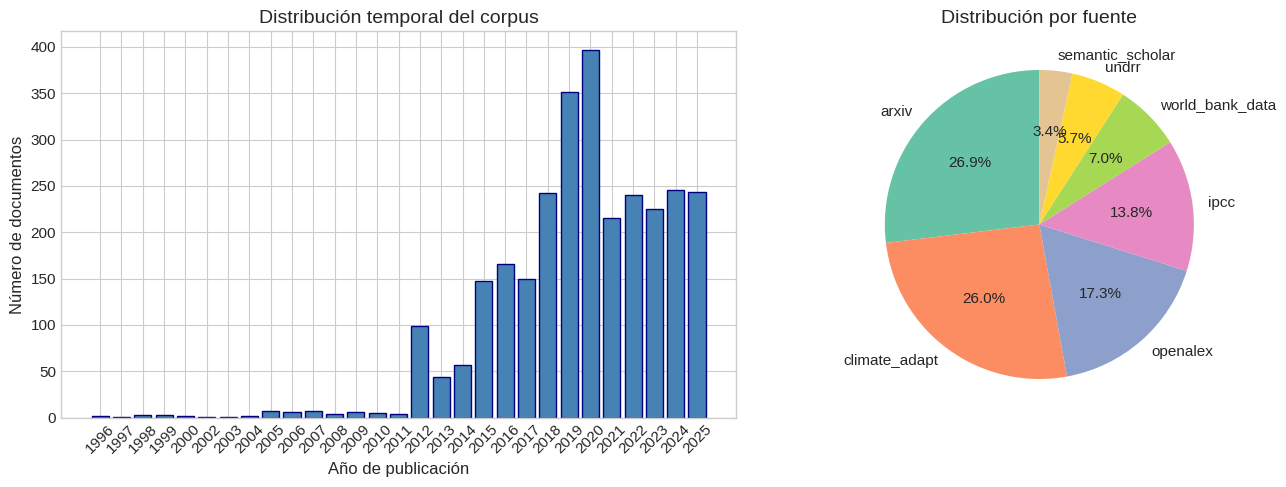


📊 Gráfico guardado en data/corpus_clima/corpus_distribution.png


In [ ]:
# Visualización de distribución temporal
if 'year' in corpus_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Distribución por año
    year_counts = corpus_df['year'].dropna().astype(int).value_counts().sort_index()
    axes[0].bar(year_counts.index.astype(str), year_counts.values, color='steelblue', edgecolor='navy')
    axes[0].set_xlabel('Año de publicación')
    axes[0].set_ylabel('Número de documentos')
    axes[0].set_title('Distribución temporal del corpus')
    axes[0].tick_params(axis='x', rotation=45)

    # Distribución por fuente
    colors = plt.cm.Set2(range(len(source_counts)))
    axes[1].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
                colors=colors, startangle=90)
    axes[1].set_title('Distribución por fuente')

    plt.tight_layout()
    plt.savefig(f"{DATA_DIR}/corpus_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\n📊 Gráfico guardado en {DATA_DIR}/corpus_distribution.png")

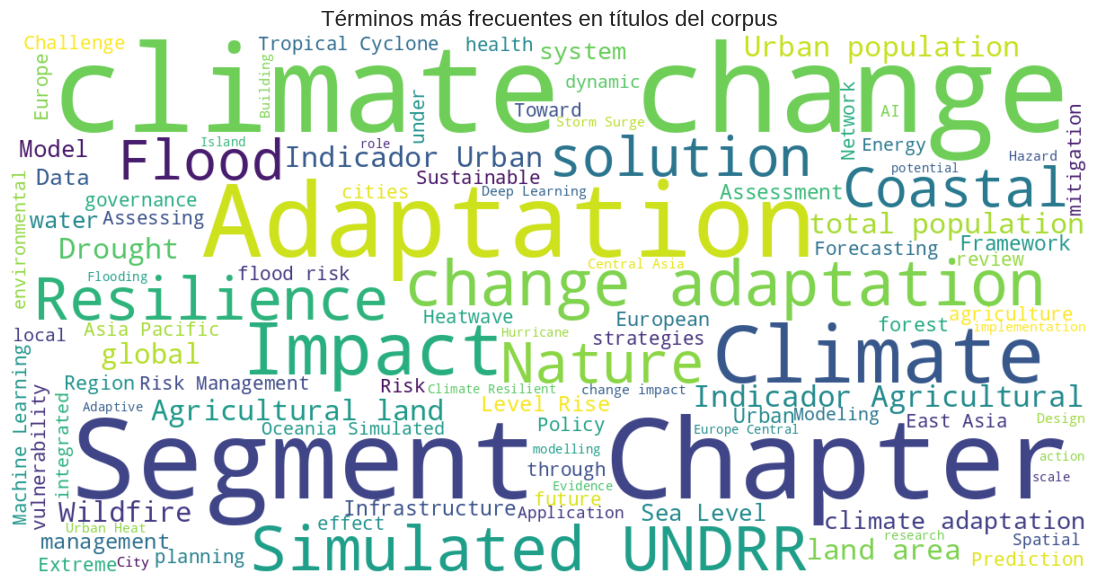


📊 Nube de palabras guardada en data/corpus_clima/wordcloud_titles.png


In [ ]:
# Nube de palabras de títulos
all_titles = ' '.join(corpus_df['title'].dropna().tolist())

# Palabras a excluir (stopwords y términos muy genéricos)
stopwords = set(['the', 'of', 'and', 'in', 'to', 'a', 'for', 'on', 'with', 'an', 'is',
                 'by', 'from', 'at', 'as', 'are', 'that', 'this', 'be', 'was', 'were',
                 'using', 'based', 'study', 'analysis', 'approach', 'case'])

wordcloud = WordCloud(width=1200, height=600,
                      background_color='white',
                      stopwords=stopwords,
                      colormap='viridis',
                      max_words=100).generate(all_titles)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Términos más frecuentes en títulos del corpus', fontsize=16)
plt.savefig(f"{DATA_DIR}/wordcloud_titles.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Nube de palabras guardada en {DATA_DIR}/wordcloud_titles.png")

### 10.2 Detección de términos del dominio climático

Verificamos qué términos de nuestra taxonomía aparecen efectivamente en el corpus. Esto nos da una medida de qué tan bien nuestras búsquedas capturaron la literatura relevante para cada aspecto del dominio.

In [ ]:
# Detección de términos de la taxonomía en el corpus
def count_taxonomy_mentions(texts: List[str], taxonomy: Dict) -> Dict:
    """
    Cuenta menciones de términos de la taxonomía en los textos.
    """
    combined_text = ' '.join(texts).lower()

    category_counts = {}
    term_counts = {}

    for category, terms in taxonomy.items():
        cat_total = 0
        for term in terms:
            count = combined_text.count(term.lower())
            if count > 0:
                term_counts[term] = count
                cat_total += count
        category_counts[category] = cat_total

    return category_counts, term_counts


# Combinar títulos y abstracts
all_text = corpus_df['title'].fillna('').tolist() + corpus_df['abstract'].fillna('').tolist()

cat_counts, term_counts = count_taxonomy_mentions(all_text, CLIMATE_TAXONOMY)

print("📊 COBERTURA DE LA TAXONOMÍA EN EL CORPUS")
print("=" * 70)
print("\n🏷️  Menciones por categoría:")
for cat, count in sorted(cat_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"   • {cat.replace('_', ' ').title()}: {count} menciones")

print("\n🔝 Top 20 términos más mencionados:")
top_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)[:20]
for term, count in top_terms:
    print(f"   • {term}: {count}")

📊 COBERTURA DE LA TAXONOMÍA EN EL CORPUS

🏷️  Menciones por categoría:
   • Hazards Water: 7246 menciones
   • Hazards Other: 1605 menciones
   • Concepts General: 1379 menciones
   • Hazards Temperature: 1098 menciones
   • Measures Ecosystem: 739 menciones
   • Measures Infrastructure: 657 menciones
   • Measures Planning: 568 menciones
   • Contexts Geographic: 490 menciones
   • Concepts Governance: 155 menciones
   • Measures Agriculture: 120 menciones
   • Measures Financial: 33 menciones

🔝 Top 20 términos más mencionados:
   • flood: 3682
   • drought: 1125
   • flooding: 940
   • wildfire: 822
   • climate adaptation: 496
   • heatwave: 418
   • sea level rise: 368
   • storm surge: 347
   • nature-based solution: 344
   • green roof: 263
   • hurricane: 246
   • climate impact: 239
   • urban area: 218
   • tropical cyclone: 207
   • early warning system: 197
   • heat wave: 187
   • climate risk: 179
   • heat stress: 170
   • urban heat island: 150
   • climate resilience: 

## 11. Resumen y Próximos Pasos

### 11.1 Resumen del corpus construido

In [ ]:
# Resumen final
print("=" * 70)
print("📊 RESUMEN FINAL DEL CORPUS DE ADAPTACIÓN CLIMÁTICA")
print("=" * 70)

print(f"""
📚 CORPUS CONSTRUIDO
   Total de documentos únicos: {len(corpus_df)}

📂 FUENTES INTEGRADAS
   • arXiv: {integration_stats['by_source'].get('arXiv', {}).get('added', 0)} artículos (preprints científicos)
   • Semantic Scholar: {integration_stats['by_source'].get('Semantic Scholar', {}).get('added', 0)} artículos (literatura revisada)
   • OpenAlex: {integration_stats['by_source'].get('OpenAlex', {}).get('added', 0)} trabajos (base académica abierta)
   • Climate-ADAPT: {integration_stats['by_source'].get('Climate-ADAPT', {}).get('added', 0)} estudios de caso (implementaciones reales)
   • World Bank: {integration_stats['by_source'].get('World Bank', {}).get('added', 0)} registros (datos de indicadores)
   • UNDRR: {integration_stats['by_source'].get('UNDRR', {}).get('added', 0)} estudios de caso (reducción de riesgo de desastres)
   • IPCC: {integration_stats['by_source'].get('IPCC', {}).get('added', 0)} segmentos (informes clave)

📅 COBERTURA TEMPORAL
   Período: {int(corpus_df['year'].min()) if corpus_df['year'].notna().any() else 'N/A'} - {int(corpus_df['year'].max()) if corpus_df['year'].notna().any() else 'N/A'}

📁 ARCHIVOS GENERADOS
   • {json_filename}
   • {csv_filename}
   • {json_latest}
   • {csv_latest}
   • {DATA_DIR}/corpus_distribution.png
   • {DATA_DIR}/wordcloud_titles.png
""")
print("=" * 70)

📊 RESUMEN FINAL DEL CORPUS DE ADAPTACIÓN CLIMÁTICA

📚 CORPUS CONSTRUIDO
   Total de documentos únicos: 2877

📂 FUENTES INTEGRADAS
   • arXiv: 774 artículos (preprints científicos)
   • Semantic Scholar: 99 artículos (literatura revisada)
   • OpenAlex: 497 trabajos (base académica abierta)
   • Climate-ADAPT: 747 estudios de caso (implementaciones reales)
   • World Bank: 200 registros (datos de indicadores)
   • UNDRR: 163 estudios de caso (reducción de riesgo de desastres)
   • IPCC: 397 segmentos (informes clave)

📅 COBERTURA TEMPORAL
   Período: 1996 - 2025

📁 ARCHIVOS GENERADOS
   • data/corpus_clima/climate_corpus_20251229_131320.json
   • data/corpus_clima/climate_corpus_20251229_131320.csv
   • data/corpus_clima/climate_corpus_latest.json
   • data/corpus_clima/climate_corpus_latest.csv
   • data/corpus_clima/corpus_distribution.png
   • data/corpus_clima/wordcloud_titles.png



### 11.2 Próximos pasos: Notebook 2

En el siguiente notebook (**Preprocesamiento de Textos y NLP para Documentos Climáticos**) trabajaremos sobre este corpus para:

Primero, **limpiar y normalizar los textos** científicos, manejando las particularidades del lenguaje técnico como unidades de medida, porcentajes, nombres de lugares y términos especializados.

Segundo, **tokenizar los abstracts** de manera adecuada para el dominio, preservando términos compuestos como "nature-based solution" o "urban heat island" que son semánticamente significativos.

Tercero, **implementar reconocimiento de entidades** para identificar automáticamente medidas de adaptación, peligros climáticos, ubicaciones geográficas, valores cuantitativos y métricas de efectividad.

Cuarto, **analizar patrones lingüísticos** que indiquen certeza, especulación, causalidad o contraste, información valiosa para la construcción del grafo.

---

### 11.3 Ejercicios propuestos

Para profundizar en el proceso de construcción de corpus, considera estos ejercicios:

1. **Ampliar las fuentes:** Investiga otras APIs relevantes como la del Banco Mundial, NASA Earthdata, o repositorios de datos climáticos nacionales, e intégralas al pipeline.

2. **Refinar las queries:** Analiza los documentos recuperados y ajusta los términos de búsqueda para mejorar la precisión o expandir la cobertura en áreas específicas.

3. **Análisis de red de coautorías:** Usando los datos de autores, construye una red de colaboraciones y analiza qué grupos de investigación son más activos en el campo.

4. **Evolución temporal de temas:** Examina cómo han cambiado los términos más frecuentes a lo largo del tiempo, identificando tendencias emergentes en la investigación de adaptación.

---

## 📓 Fin del Notebook 1

**Siguiente:** [Notebook 2: Preprocesamiento de Textos y NLP para Documentos Climáticos](./notebook_02_preprocesamiento_clima.ipynb)

---

*Proyecto de Construcción de Grafo de Conocimiento para Adaptación Climática*

*Este notebook forma parte de una serie didáctica diseñada para lingüistas y profesionales de humanidades interesados en aplicar técnicas de procesamiento de lenguaje natural a dominios especializados.*